<a href="https://colab.research.google.com/github/EdinhoAndra/PUC_MVP_ML_ANALYTICS/blob/main/MVP_ML_%26_Analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# MVP: *Machine Learning & Analytics*
**Autor:** _EDISON SILVA JUNIOR_  

**Data:** 27/09/2025

**Matrícula:** 4052024002390

**Dataset:** Base de dados do mini-índice futuro extraída da plataforma Profit Pro da Nelógica, compreendendo o período entre 02/12/2022 e 29/08/2025, no formato renko 40R



## Escopo, objetivo e definição do problema
**TODO:** Explique brevemente:
- Contexto do problema e objetivo: previsão do alvo classificado de acordo com o métido Triple Barrier, preconizado por Marcos Lopez de Prado em sua obra "Advances in Financial Machine Learning" - esse método será explicado abaixo.
- Tipo de tarefa: **séries temporais (forecasting)**.  
- Área de aplicação: mercado financeiro, os dados serão utilizados para treinar um modelo que pode ser salvo num arquivo onnx, por exemplo, e ser integrado em um algoritmo de trading quantitativo, escrito em qualquer linguagem, podendo ser utilizado em real time, sendo que os dados tabulados (features) serão construídos em real time a partir de dados de entrada (preço).
- Importante salientar que renko é uma forma de gráfico atemporal, em que cada datapoint é formado a partir de uma dada quantidade de negócios estipulada (a depender de R), não importando o tempo demore para se materializar cada barra.
Basicamente, a fórmula de renko utilizada pela Nelógica (fornecedora dos dados) é essa:

Tamanho do Renko = ("R" x tick do ativo) - 1 tick do ativo

sendo que o valor do tick para o mini-índice é de 5 pontos

Portanto, por mais que 40R tenha sido um número arbitrário, ele se encaixa dentro de uma lógica de negociação que funcione para o período intradiário (daytrade), pois quanto maior o valor de R, mais tempo se leva para que sejam formadas as barras. Também houve a necessidade de se lidar com o problema do ruído branco. Quanto menor o valor de R, mais ruído é gerado. Sendo assim, 40R, a princípio, se mostrou um valor razoável.


# Método **Triple Barrier**

## 1) O que é o Triple Barrier (TB)
Para cada instante \(t\), traçam-se **três barreiras** a partir do estado atual (preço ou PnL):

- **Superior**: ganho “suficiente” \((+u_t)\)
- **Inferior**: perda “suficiente” \((-d_t)\)
- **Vertical**: um **horizonte temporal** de \(T\) barras

Seguindo o caminho do ativo de \(t+1\) até \(t+T\), o **primeiro evento** que ocorrer define o rótulo \(y_t\).

---

## 2) Notação mínima
- \(P_t\): preço no tempo \(t\)
- \(r_{t+1}\): retorno entre \(t\) e \(t+1\)  
  • **log-retorno**: \(r_{t+1}=\ln(P_{t+1}/P_t)\) (acumula por **soma**)  
  • **percentual**: \(r_{t+1}=P_{t+1}/P_t-1\) (acumula por **composição**)
- **Retorno acumulado** de \(t\) a \(t+k\):  
  \[
  R_{t\to t+k}=
    \begin{cases}
      \sum_{j=1}^{k} r_{t+j}, & \text{(log-retorno)} \\
      \displaystyle\prod_{j=1}^{k}(1+r_{t+j})-1, & \text{(percentual)}
    \end{cases}
  \]
- \(\sigma_t\): estimativa **causal** de volatilidade (ex.: EWMA dos retornos)
- \(u_t=k_u\,\sigma_t\), \(d_t=k_d\,\sigma_t\) (tipicamente \(k_u=k_d\in[0.5,2]\))
- (Opcional) **lado** \(s_t\in\{+1,-1\}\) quando há viés direcional (ex.: operar só comprado)

Acompanhe o processo **ajustado por lado**: \(\tilde R_{t\to t+k} = s_t\,R_{t\to t+k}\).

---

## 3) Tempo de batida e rótulo
**Tempo de batida (primeiro toque)**:
\[
\tau=\min\Big\{\,k\in\{1,\dots,T\}\;:\;\tilde R_{t\to t+k}\ge u_t\;\; \text{ou}\;\; \tilde R_{t\to t+k}\le -d_t \,\Big\}
\]
(se não houver toque, defina \(\tau=T\)).

**Rótulo**:
\[
y_t=
\begin{cases}
+1, & \text{se }\tilde R_{t\to t+\tau}\ge u_t \\
-1, & \text{se }\tilde R_{t\to t+\tau}\le -d_t \\
0 \;\text{(ou }\operatorname{sign}(R_{t\to t+T})\text{)}, & \text{se }\tau=T\;(\text{barreira vertical})
\end{cases}
\]

> Observação: a variante “**zero_if_no_hit**” usa \(0\) quando só a vertical é atingida; a variante “**return_at_T**” usa \(\operatorname{sign}(R_{t\to t+T})\).

---

## 4) Procedimento passo a passo
1. **Escolha a unidade de retorno** (log vs. percentual) e mantenha a coerência para tudo.
2. **Estime \(\sigma_t\)** de modo **causal** (ex.: EWMA dos retornos).  
   - EWMA com `span`: \(\alpha=2/(\text{span}+1)\); *half-life* \(h\approx \ln 2 / [-\ln (1-\alpha)]\).
3. **Defina as barreiras**: \(u_t=k_u\sigma_t\), \(d_t=k_d\sigma_t\).
4. **Escolha \(T\)** (nº de barras) — ver Seção 6.
5. **Percorra** de \(t+1\) a \(t+T\) acumulando retorno (soma para log; produto para percentual).
6. **Rotule** com base no primeiro toque; em caso de não-toque, aplique a regra escolhida (0 ou sinal em \(T\)).

---

## 5) Por que usar Triple Barrier
- Controla **magnitude** *e* **tempo** exigidos ⇒ rótulos menos ruidosos.
- Adapta-se a **regimes de volatilidade** (barreiras respiram com \(\sigma_t\)).
- Evita forçar direção quando o movimento foi pequeno (via rótulo 0 ou decisão em \(T\)).

---

## 6) Como escolher **T** (horizonte vertical)
- **Regra de bolso (difusão)**: se \(u=d=k\cdot\sigma\), então  
  \(\sqrt{n}\approx k \Rightarrow T\approx k^2\) (ajuste fino ×(0.5–2) conforme serialização).
- **Casar com a memória do sinal**: use a *half-life* do seu filtro/sinal (ex.: half-life da EWMA) e tome \(T\in[0.5h,1.5h]\).
- **Escolha empírica** (recomendada): varra \(T\in\{1,2,3,5,8,\dots\}\) e observe:  
  • taxa de “vertical” (objetivo ~20–40% se usar `zero_if_no_hit`)  
  • balanceamento de classes (+1/0/−1)  
  • **duração mediana** até o evento.  
  Prefira \(T\) que evite extremos (quase tudo vertical ou quase nada) e tenha duração compatível com seu **embargo** na validação.

---

## 7) Boas práticas
- **Causalidade**: não use dados futuros em \(\sigma_t\) ou em qualquer feature que influencie o rótulo.
- **Coerência de unidades**: log-returns pedem \(\sigma_t\) em log; percentuais pedem \(\sigma_t\) em %.
- **Validação sem vazamento**: em *PurgedKFoldEmbargo*, use **embargo ≥ duração mediana** dos eventos (ou ~1.5×).
- **Relatório de hiperparâmetros**: documente \(k_u,k_d,T\), tipo de retorno, forma de \(\sigma_t\) e estatísticas (+1/0/−1, duração).

---



### Dependências

In [1]:

!pip install -q statsmodels lightgbm optuna openpyxl


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 64.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 76.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 37.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.9/250.9 kB 25.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.4/247.4 kB 25.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.9/232.9 kB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 112.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 607.6/607.6 kB 60.2 MB/s eta 0:00:00


In [17]:
# === Setup básico e reprodutibilidade ===
import warnings
warnings.filterwarnings('ignore')

import os, random, time, sys, math
import numpy as np
import pandas as pd
import time
from datetime import time as dtime, datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from statsmodels.tsa.stattools import adfuller
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
import lightgbm as lgb
from sklearn.metrics import (accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix,
                             mean_absolute_error, mean_squared_error, r2_score,
                             silhouette_score)

from sklearn.feature_selection import mutual_info_classif
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold, KFold, TimeSeriesSplit, RandomizedSearchCV
from scipy.stats import randint, uniform
from sklearn.model_selection import KFold
from joblib import dump, load

SEED = 42
np.random.seed(SEED)
random.seed(SEED)

# Para frameworks que suportam seed adicional (ex.: PyTorch/TensorFlow), documente aqui:
# import torch; torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)
# import tensorflow as tf; tf.random.set_seed(SEED)

print("Python:", sys.version.split()[0])
print("Seed global:", SEED)

Python: 3.12.11
Seed global: 42


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Funções python

**Helpers**

In [4]:
def span_from_halflife(h: float) -> float:
    alpha = 1 - 2**(-1.0/h)
    return 2.0/alpha - 1.0



def halflife_from_span(span: float) -> float:
    alpha = 2.0/(span + 1.0)
    return np.log(2) / (-np.log(1.0 - alpha))



def scan_T(returns, vol, up_mult=1.0, dn_mult=1.0,
           T_list=(1,2,3,5,8,10,15,20,30),
           use_log_returns=False, mode_if_vertical="zero_if_no_hit",
           side=None, tb_func=None):
    """
    tb_func: sua função triple_barrier_from_returns
    Retorna um DataFrame com métricas por T.
    """
    rows = []
    for T in T_list:
        lbl = tb_func(
            returns=returns, vol=vol, T=T,
            up_mult=up_mult, dn_mult=dn_mult,
            side=side, use_log_returns=use_log_returns,
            mode_if_vertical=mode_if_vertical
        )
        vc = lbl['label'].value_counts(normalize=True)
        rate_pos = vc.get(1,0.0); rate_zer = vc.get(0,0.0); rate_neg = vc.get(-1,0.0)
        vert_rate = (lbl['barrier_hit']=="vertical").mean()
        # duração do evento em barras:
        dur = []
        idx = lbl.index
        pos_map = {t:i for i,t in enumerate(idx)}
        for i, t_end in enumerate(lbl['t1']):
            try:
                dur.append(pos_map[t_end] - i)
            except KeyError:
                pass
        med_dur = float(np.median(dur)) if dur else np.nan

        rows.append({
            "T": T,
            "vert_rate": vert_rate,
            "rate_-1": rate_neg, "rate_0": rate_zer, "rate_+1": rate_pos,
            "median_duration": med_dur
        })
    return pd.DataFrame(rows).set_index("T").sort_index()


### Funções python

**Features**

In [5]:
def rsi(prices, timeperiod: int = 14) -> np.ndarray:
    """
    Replica o RSI da biblioteca TALIB:
      - Diferenças positivas/negativas viram gains/losses.
      - Inicialização: média aritmética de gains/losses nos N primeiros períodos.
      - Suavização de Wilder: avg_new = ((avg_prev*(N-1)) + atual) / N
      - Índices < timeperiod recebem NaN.
      - Se avgLoss == 0 em qualquer ponto, RSI = 100.0.
      - Caso len(prices) < timeperiod + 1, retorna array de zeros (compatível com o C#).

    Parâmetros
    ----------
    prices : array-like de floats
        Série de preços (close).
    timeperiod : int
        Período do RSI (padrão 14).

    Retorno
    -------
    np.ndarray
        RSI com NaN nos primeiros `timeperiod` índices, e valores a partir de `timeperiod`.
    """
    if timeperiod < 1:
        raise ValueError("timeperiod deve ser >= 1")

    x = np.asarray(prices, dtype=float)
    n = x.size

    # Mesmo comportamento do C#: se não houver dados suficientes, retorna zeros.
    out = np.zeros(n, dtype=float)
    if n < timeperiod + 1:
        return out

    gains = np.zeros(n, dtype=float)
    losses = np.zeros(n, dtype=float)

    # Diferenças
    diff = x[1:] - x[:-1]
    gains[1:] = np.where(diff > 0.0, diff, 0.0)
    losses[1:] = np.where(diff < 0.0, -diff, 0.0)

    # Inicialização (média simples dos primeiros N gains/losses)
    avg_gain = gains[1:timeperiod + 1].sum() / timeperiod
    avg_loss = losses[1:timeperiod + 1].sum() / timeperiod

    # NaN antes de timeperiod (compatível com o loop final do C#)
    out[:timeperiod] = np.nan

    # Primeiro RSI calculável (índice timeperiod)
    if avg_loss == 0.0:
        out[timeperiod] = 100.0
    else:
        rs = avg_gain / avg_loss
        out[timeperiod] = 100.0 - (100.0 / (1.0 + rs))

    # Suavização de Wilder
    for i in range(timeperiod + 1, n):
        avg_gain = ((avg_gain * (timeperiod - 1)) + gains[i]) / timeperiod
        avg_loss = ((avg_loss * (timeperiod - 1)) + losses[i]) / timeperiod

        if avg_loss == 0.0:
            out[i] = 100.0
        else:
            rs = avg_gain / avg_loss
            out[i] = 100.0 - (100.0 / (1.0 + rs))

    return out



def calculate_rsl(prices, timeperiod=14):
    """
    Calculate the Relative Strength Levy (RSL) for a given series of prices.

    Parameters:
    prices (pd.Series): Series of closing prices.
    period (int): Period over which to calculate the RSL.

    Returns:
    pd.Series: Series of RSL values.
    """
    # Calculate the moving average of the closing prices
    rolling_mean = prices.rolling(window=timeperiod).mean()

    # Calculate RSL
    rsl = (prices / rolling_mean) - 1

    return rsl



def parkinson_vol(high, low, window=20):
    """
    Parkinson volatility — usa apenas high e low, ignora open/close.
    Mais eficiente que o desvio padrão se não houver gaps.
    """
    log_hl = np.log(high / low)
    var = (log_hl ** 2).rolling(window=window).sum() * (1 / (4 * window * np.log(2)))
    return np.sqrt(var)



def garman_klass_vol(open_, high, low, close, window=20):
    """
    Garman-Klass volatility — usa open, high, low e close.
    Considera mais informação do candle.
    """
    log_hl = np.log(high / low)
    log_co = np.log(close / open_)

    rs = 0.5 * (log_hl ** 2) - (2 * np.log(2) - 1) * (log_co ** 2)

    return np.sqrt(rs.rolling(window=window).sum() / window)



def realized_vol(returns, window=20):
    """
    Realized volatility — soma dos retornos ao quadrado.
    """
    return np.sqrt((returns ** 2).rolling(window=window).sum())



def atr(high, low, close, timeperiod: int = 14) -> np.ndarray:
    """
    ATR (Average True Range) no estilo TA-Lib (Wilder):
      - TR[i] = max( high[i]-low[i], |high[i]-close[i-1]|, |low[i]-close[i-1]| )
      - ATR[timeperiod] = média simples de TR[1:timeperiod+1]
      - ATR[i] = ((ATR[i-1]*(timeperiod-1)) + TR[i]) / timeperiod  (Wilder)
      - Saída com NaN nos índices < timeperiod (como no TA-Lib)

    Parâmetros
    ----------
    high, low, close : array-like
        Séries de máxima, mínima e fechamento.
    timeperiod : int, default 14
        Período da ATR.

    Retorno
    -------
    np.ndarray
        ATR com NaN nos primeiros `timeperiod` índices.
    """
    if timeperiod < 1:
        raise ValueError("timeperiod deve ser >= 1")

    h = np.asarray(high, dtype=float)
    l = np.asarray(low, dtype=float)
    c = np.asarray(close, dtype=float)

    if not (h.size == l.size == c.size):
        raise ValueError("high, low e close devem ter o mesmo tamanho.")

    n = c.size
    out = np.full(n, np.nan, dtype=float)
    if n == 0:
        return out
    if n < timeperiod + 1:
        # TA-Lib também não consegue formar a ATR sem dados suficientes
        return out

    # True Range
    tr = np.empty(n, dtype=float)
    tr[:] = np.nan
    # i = 0 (sem close anterior): TA-Lib efetivamente não usa esse ponto; deixe como NaN
    # i >= 1
    up = h[1:] - l[1:]
    a2 = np.abs(h[1:] - c[:-1])
    a3 = np.abs(l[1:] - c[:-1])
    tr[1:] = np.maximum.reduce([up, a2, a3])

    # ATR inicial (média simples dos primeiros `timeperiod` TR válidos: índices 1..timeperiod)
    init_slice = tr[1:timeperiod+1]
    atr = np.full(n, np.nan, dtype=float)

    # Se houver NaN dentro dessa janela, o TA-Lib geralmente resultará em NaN;
    # aqui assumimos que não há NaN nos dados de entrada. Se houver, propaga.
    atr_init = np.nanmean(init_slice)
    atr[timeperiod] = atr_init

    # Suavização de Wilder
    for i in range(timeperiod + 1, n):
        # Se TR[i] for NaN, resultado vira NaN (compatível com propagação)
        if np.isnan(atr[i-1]) or np.isnan(tr[i]):
            atr[i] = np.nan
        else:
            atr[i] = ((atr[i-1] * (timeperiod - 1)) + tr[i]) / timeperiod

    return atr



### Funções python

**Alvo**

In [6]:
def ewma_std(x: pd.Series, span: int = 96, min_periods: int = 20) -> pd.Series:
    """
    Desvio-padrão EWMA (causal) de uma série (tipicamente retornos).
    """
    mu = x.ewm(span=span, adjust=False, min_periods=min_periods).mean()
    var = ((x - mu)**2).ewm(span=span, adjust=False, min_periods=min_periods).mean()
    return np.sqrt(var)



def triple_barrier(
    returns: pd.Series,
    vol: pd.Series | float,
    T: int,
    up_mult: float = 1.0,
    dn_mult: float = 1.0,
    side: int | pd.Series | None = None,
    use_log_returns: bool = True,
    mode_if_vertical: str = "zero_if_no_hit",  # ou "return_at_T"
    *,
    force_binary: bool = False,               # <<< novo
    tie_policy: str = "up",                   # "up" | "down" | "random" | "drop"
    eps: float = 0.0                          # banda para empates (~0)
) -> pd.DataFrame:
    import numpy as np
    import pandas as pd
    rng = np.random.default_rng(12345)

    if T < 1:
        raise ValueError("T deve ser >= 1")

    rets = returns.astype(float).fillna(0.0)
    idx = rets.index

    vol_series = (pd.Series(float(vol), index=idx) if isinstance(vol, (int, float))
                  else pd.Series(vol, index=idx).astype(float).reindex(idx))

    if side is None:
        side_series = pd.Series(1.0, index=idx); use_side = False
    elif isinstance(side, (int, float)):
        side_series = pd.Series(float(side), index=idx); use_side = True
    else:
        side_series = pd.Series(side, index=idx).astype(float); use_side = True

    n = len(rets)
    label = np.zeros(n, dtype=int)
    t1 = np.array([None]*n, dtype=object)
    barrier_hit = np.array([None]*n, dtype=object)
    ret_at_event = np.zeros(n, dtype=float)

    rv = rets.values
    vv = vol_series.values
    sv = side_series.values

    for i in range(n):
        j_end = min(i + T, n - 1)
        if i == j_end:
            label[i] = 0; t1[i] = idx[j_end]; barrier_hit[i] = "vertical"; ret_at_event[i] = 0.0
            continue

        up = up_mult * vv[i]
        dn = dn_mult * vv[i]
        s = sv[i] if use_side else 1.0

        hit = None; k_hit = None

        if use_log_returns:
            cum = 0.0
            for k in range(i+1, j_end+1):
                cum += rv[k]
                adj = s * cum
                if adj >= up:   hit = "up";   k_hit = k; break
                if adj <= -dn:  hit = "down"; k_hit = k; break
            final_ret = s * (cum if hit is not None else np.sum(rv[i+1:j_end+1]))
        else:
            comp = 1.0
            for k in range(i+1, j_end+1):
                comp *= (1.0 + rv[k])
                adj = s * (comp - 1.0)
                if adj >= up:   hit = "up";   k_hit = k; break
                if adj <= -dn:  hit = "down"; k_hit = k; break
            final_ret = s * ((comp - 1.0) if hit is not None
                             else np.prod(1.0 + rv[i+1:j_end+1]) - 1.0)

        if hit is not None:
            barrier_hit[i] = hit
            t1[i] = idx[k_hit]
            ret_at_event[i] = final_ret
            label[i] = 1 if hit == "up" else -1
        else:
            barrier_hit[i] = "vertical"
            t1[i] = idx[j_end]
            ret_at_event[i] = final_ret

            if mode_if_vertical == "zero_if_no_hit":
                label[i] = 0

            elif mode_if_vertical == "return_at_T":
                # --- versão original (quase sempre binária) ---
                y = 1 if final_ret > 0 else (-1 if final_ret < 0 else 0)

                # --- força binário, se solicitado ---
                if force_binary:
                    if abs(final_ret) <= eps or y == 0:
                        if tie_policy == "up":
                            y = 1
                        elif tie_policy == "down":
                            y = -1
                        elif tie_policy == "random":
                            y = 1 if rng.random() < 0.5 else -1
                        elif tie_policy == "drop":
                            y = 0  # você pode remover depois
                        else:
                            raise ValueError("tie_policy inválida.")
                label[i] = y

            else:
                raise ValueError("mode_if_vertical deve ser 'zero_if_no_hit' ou 'return_at_T'.")

    return pd.DataFrame(
        {"label": label, "t1": t1, "barrier_hit": barrier_hit, "ret_at_event": ret_at_event},
        index=idx,
    )

### Classe para validação cruzada com purge e embargo a la Lopez de Prado (Advances in Financial Machine Learning)

In [7]:
class PurgedKFoldEmbargo(KFold):
    """
    Enhanced version of KFold cross-validation with purging and embargo.

    This cross-validator prevents data leakage by:
    - Excluding training samples around the test set (purging)
    - Applying an optional embargo period after the test set
    - Validating parameters and handling edge cases robustly

    Supports both absolute and proportional embargo values.

    Parameters
    ----------
    n_splits : int, default=3
        Number of KFold splits. Must be at least 2.
    embargo : int or float, default=0
        If int: number of samples to embargo on both sides of the test set.
        If float ∈ (0, 1): fraction of the dataset to embargo (converted to absolute number).
    min_train_size : int, default=10
        Minimum number of training samples allowed after purging and embargoing.
    """

    def __init__(self, n_splits=3, embargo=0, min_train_size=10):
        if n_splits < 2:
            raise ValueError(f"n_splits must be ≥ 2 (got {n_splits}).")
        if not isinstance(embargo, (int, float)):
            raise TypeError("embargo must be either int or float.")
        if isinstance(embargo, float) and not (0 < embargo < 1):
            raise ValueError("If embargo is a float, it must be in the interval (0, 1).")
        if isinstance(embargo, int) and embargo < 0:
            raise ValueError("If embargo is an int, it must be non-negative.")
        if min_train_size < 1:
            raise ValueError("min_train_size must be ≥ 1.")

        super().__init__(n_splits=n_splits, shuffle=False, random_state=None)
        self.embargo = embargo
        self.min_train_size = min_train_size

    def split(self, X, y=None, groups=None):
        """
        Generate training and test indices with purging and embargo applied.

        Parameters
        ----------
        X : array-like of shape (n_samples, ...)
            The input data.
        y : array-like of shape (n_samples,), default=None
            The target variable (ignored, kept for compatibility).
        groups : array-like of shape (n_samples,), default=None
            Group labels for the samples (ignored in this implementation).

        Yields
        ------
        train_idx : ndarray
            The training set indices with purging and embargo applied.
        test_idx : ndarray
            The standard test set indices from KFold.
        """
        n_samples = len(X)

        # Convert fractional embargo to absolute number of samples
        if isinstance(self.embargo, float):
            embargo_abs = int(np.ceil(n_samples * self.embargo))
        else:
            embargo_abs = self.embargo

        for train_idx, test_idx in super().split(X, y, groups):
            if len(test_idx) == 0:
                continue  # Defensive check

            test_start = test_idx[0]
            test_end = test_idx[-1]

            # Compute safe train boundaries
            safe_start = max(0, test_start - embargo_abs)
            safe_end = min(n_samples, test_end + embargo_abs + 1)

            # Vectorized mask to exclude embargoed regions
            train_mask = (
                (train_idx < safe_start) |
                (train_idx >= safe_end)
            )
            new_train_idx = train_idx[train_mask]

            # Warn if the resulting training set is too small
            if len(new_train_idx) < self.min_train_size:
                msg = (f"[Split {test_start}-{test_end}] "
                       f"Training set has only {len(new_train_idx)} samples "
                       f"(< {self.min_train_size}). Embargo={embargo_abs}.")
                warnings.warn(msg, UserWarning)

            yield new_train_idx, test_idx


## 3. Dados, features e construção do alvo
- Base de dados do mini-índice futuro extraída da plataforma Profit Pro da Nelógica, compreendendo o período entre 02/12/2022 e 29/08/2025, no formato renko 40R

**Features**
- returns: retornos percentuais
-

In [8]:
# Carregar os dados
df = pd.read_excel("/content/drive/MyDrive/Colab_Files/WIN_RENKO40.xlsx")
df = df.sort_values("Date")

In [ ]:
# Contagem de bricks (renkos) por DIA de calendário
daily_counts = df.groupby(df['Date'].dt.date).size().rename('bricks')

# Estatísticas (média, mediana etc.)
media   = daily_counts.mean()
mediana = daily_counts.median()
resumo  = daily_counts.describe()  # count, mean, std, min, quartis, max

print('Média de bricks/dia:', media)
print('Mediana de bricks/dia:', mediana)
print(resumo)

Média de bricks/dia: 18.551020408163264
Mediana de bricks/dia: 16.0
count    686.000000
mean      18.551020
std       12.731461
min        2.000000
25%       12.000000
50%       16.000000
75%       22.000000
max      169.000000
Name: bricks, dtype: float64


In [10]:
df['returns'] = df['Close'].pct_change()

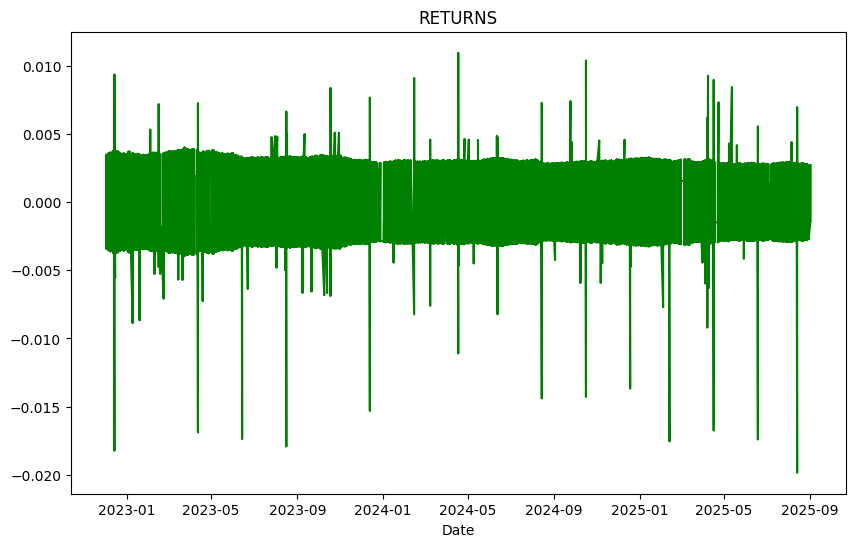

In [ ]:
# Plotar gráfico de retornos para ajudara fixar o limiar do target
plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['returns'], label = None, color='green')
plt.xlabel('Date')
plt.title('RETURNS')
#plt.legend()
plt.show()

In [ ]:
df['returns'].describe()

,returns
count,1.272500e+04
mean,-9.352258e-07
std,2.394915e-03
min,-1.984301e-02
25%,-1.712273e-03
50%,1.364271e-03
75%,1.721184e-03
max,1.095464e-02


### Testes para calcular a meia vida de vol, que será usada na calibragem do alvo

In [ ]:
# Calcular o parâmetro span a ser utilizado na média móvel exponencial (ewma) utilizando a média aproximada de bricks ocorridos por dia +-20
sp = span_from_halflife(20)
print(sp)

57.71357774643303


### Testes para calcular qual o melhor valor de T (barreira vertical)

In [ ]:
res = scan_T(
    returns=df['returns'],
    vol=ewma_std(df['returns'], span=58, min_periods=20),
    up_mult=1.0, dn_mult=1.0,
    T_list=(1,2,3,4,5,8,10,15,20,30),
    use_log_returns=False,
    mode_if_vertical='zero_if_no_hit', #"return_at_T",
    tb_func=triple_barrier
)
print(res)

    vert_rate   rate_-1    rate_0   rate_+1  median_duration
T                                                           
1    0.668317  0.164702  0.668317  0.166981              1.0
2    0.235345  0.382052  0.235345  0.382603              2.0
3    0.083530  0.455210  0.083530  0.461260              2.0
4    0.034103  0.480119  0.034103  0.485777              2.0
5    0.015559  0.490020  0.015559  0.494421              2.0
8    0.004950  0.495050  0.004950  0.500000              2.0
10   0.004322  0.495364  0.004322  0.500314              2.0
15   0.003379  0.495992  0.003379  0.500629              2.0
20   0.003300  0.495992  0.003300  0.500707              2.0
30   0.003222  0.495992  0.003222  0.500786              2.0


## Criação da variável vol que será usada pelo alvo

In [11]:
vol = ewma_std(df['returns'], span=58, min_periods=20)

## Definição do Alvo através do método Triple Barrier

In [12]:
df['target'] = triple_barrier(
    returns=df['returns'],
    vol=vol,
    T=3,
    up_mult=1.0,
    dn_mult=1.0,
    side=None,
    use_log_returns=False,
    mode_if_vertical="return_at_T", # Aqui é preciso alterar o parâmetro, pois do contrário, poderia haver problemas no treinamento de modelos como o lightgbm, por exemplo, devido ao número muito baixo da classe 0
    force_binary=True,        # <<< elimina a classe 0
    tie_policy="random",          # ou "down" / "random"
)['label'].iloc[:-3] # Remove as últimas T linhas sem rotular


In [13]:
df['RSL5'] = calculate_rsl(df['Close'], timeperiod=5)
df['RSL10'] = calculate_rsl(df['Close'], timeperiod=10)
df['RSL20'] = calculate_rsl(df['Close'], timeperiod=20)
df['RSL200'] = calculate_rsl(df['Close'], timeperiod=200)

df['RSI5'] = rsi(df['Close'], timeperiod=5)
df['RSI10'] = rsi(df['Close'], timeperiod=10)
df['RSI20'] = rsi(df['Close'], timeperiod=20)
df['RSI200'] = rsi(df['Close'], timeperiod=200)

df['ATR'] = atr(
    df['High'],
    df['Low'],
    df['Close'],
    timeperiod=20
)


df['PKS_VOL'] = parkinson_vol(
    df['High'],
    df['Low'],
    window=20
)


df['GK_VOL'] = garman_klass_vol(
    df['Open'],
    df['High'],
    df['Low'],
    df['Close'],
    window=20
)


df['realized_vol'] = realized_vol(
    df['returns'],
    window=20
)

lags = range(1, 21)
for lag in lags:
    df[f"ret_lag_{lag}"] = df["Close"].pct_change(lag)
    df[f'ATR_lag_{lag}'] = df['ATR'].shift(lag)
    df[f'PKS_VOL_lag_{lag}'] = df['PKS_VOL'].shift(lag)
    df[f'GK_VOL_lag_{lag}'] = df['GK_VOL'].shift(lag)
    df[f'realized_vol_lag_{lag}'] = df['realized_vol'].shift(lag)
    df[f'RSL5_lag_{lag}'] = df['RSL5'].shift(lag)
    df[f'RSL10_lag_{lag}'] = df['RSL10'].shift(lag)
    df[f'RSL20_lag_{lag}'] = df['RSL20'].shift(lag)
    df[f'RSL200_lag_{lag}'] = df['RSL200'].shift(lag)
    df[f'RSI5_lag_{lag}'] = df['RSI5'].shift(lag)
    df[f'RSI10_lag_{lag}'] = df['RSI10'].shift(lag)
    df[f'RSI20_lag_{lag}'] = df['RSI20'].shift(lag)
    df[f'RSI200_lag_{lag}'] = df['RSI200'].shift(lag)


df.dropna(inplace=True)

## Modelo Dummy Classifier - Baseline

In [14]:
df.set_index('Date', inplace=True)

df_dummy = df.copy()
y = df_dummy["target"]
X = df_dummy.drop(columns=["target", "Open", "High", "Low", "Close", "returns"])

In [ ]:
print(y)

Date
2022-12-13 10:30:04.730    1.0
2022-12-13 10:30:08.010    1.0
2022-12-13 10:32:43.587   -1.0
2022-12-13 10:32:44.141   -1.0
2022-12-13 10:32:52.982   -1.0
                          ... 
2025-08-29 14:04:56.351    1.0
2025-08-29 17:00:13.605   -1.0
2025-08-29 18:00:54.008   -1.0
2025-09-01 09:02:49.922   -1.0
2025-09-01 11:42:03.092   -1.0
Name: target, Length: 12503, dtype: float64


In [ ]:
class_counts = y.value_counts()
print(class_counts)

target
 1.0    6297
-1.0    6206
Name: count, dtype: int64


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)

# “most_frequent” = sempre prevê a classe majoritária do treino
dummy = DummyClassifier(strategy="most_frequent", random_state=SEED)
dummy.fit(X_train, y_train)

y_pred = dummy.predict(X_test)
print("Acurácia:", accuracy_score(y_test, y_pred))
print("\nRelatório:\n", classification_report(y_test, y_pred))
print("\nMatriz de confusão:\n", confusion_matrix(y_test, y_pred))

Acurácia: 0.5037984806077569

Relatório:
               precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00      1241
         1.0       0.50      1.00      0.67      1260

    accuracy                           0.50      2501
   macro avg       0.25      0.50      0.34      2501
weighted avg       0.25      0.50      0.34      2501


Matriz de confusão:
 [[   0 1241]
 [   0 1260]]


In [ ]:
# ============================
# Sanitização
# ============================
def sanitize_df_numeric(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    for c in df.columns:
        if df[c].dtype == "object":
            df[c] = pd.to_numeric(df[c], errors="coerce")
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    return df

# Garanta tipos limpos
X = sanitize_df_numeric(X).astype("float32")
y = pd.Series(y).astype("int64")

# Remova colunas completamente NaN (após coercion)
null_all = X.columns[X.isna().all()]
if len(null_all) > 0:
    X = X.drop(columns=list(null_all))

# Preenche eventuais NaNs remanescentes com mediana (por coluna) — simples e robusto p/ KNN
X = X.fillna(X.median(numeric_only=True))

# ============================
# ENS por fold (sem vazamento)
# ============================
def make_eff_sample_weights(y_fit: pd.Series,
                            y_eval: pd.Series | None,
                            classes_all: np.ndarray,
                            beta: float = 0.999):
    """
    Calcula pesos por classe a partir APENAS do y_fit (treino).
    No KNN usaremos apenas no cálculo da métrica (sample_weight no f1_score).
    """
    counts = y_fit.value_counts().reindex(classes_all, fill_value=0).astype(int).values
    counts = np.maximum(counts, 1)

    eff = (1.0 - np.power(beta, counts)) / (1.0 - beta)
    w_eff = 1.0 / eff
    w_eff = w_eff / w_eff.mean()

    class_weight_eff = {int(c): float(w) for c, w in zip(classes_all, w_eff)}
    sw_fit = y_fit.map(class_weight_eff).astype("float32")
    sw_eval = None if y_eval is None else y_eval.map(class_weight_eff).astype("float32")
    return class_weight_eff, sw_fit, sw_eval

# ============================
# Ranqueamento por Mutual Information (no TREINO do fold)
# ============================
def rank_features_by_mi(X_tr: pd.DataFrame, y_tr: pd.Series) -> np.ndarray:
    """
    Retorna índices das features ordenados (desc) por mutual information.
    MI é calculada apenas no conjunto de TREINO do fold, evitando vazamento.
    """
    # Padroniza (KNN depende de escala; MI aqui fica estável numericamente)
    scaler = StandardScaler()
    X_tr_s = scaler.fit_transform(X_tr.values.astype("float32"))
    mi = mutual_info_classif(X_tr_s, y_tr.values, discrete_features=False, random_state=42)
    mi = np.nan_to_num(mi, nan=0.0, posinf=0.0, neginf=0.0)
    order = np.argsort(mi)[::-1]
    return order, mi

# ============================
# Objetivo (seleção + tunagem) para KNN
# ============================
def objective_knn(trial: optuna.trial.Trial, X: pd.DataFrame, y: pd.Series, cv) -> float:
    classes_all = np.array(sorted(np.unique(y)))
    if classes_all.size < 2:
        raise ValueError("Dataset com menos de 2 classes.")

    n_feats = X.shape[1]
    k_hi = max(5, min(n_feats, n_feats // 2 if n_feats >= 20 else n_feats))
    top_k = trial.suggest_int("top_k", min(5, n_feats), k_hi)

    # Hiperparâmetros do KNN
    n_neighbors = trial.suggest_int("n_neighbors", 3, 75)  # simples e eficaz
    weights = trial.suggest_categorical("weights", ["uniform", "distance"])
    metric = trial.suggest_categorical("metric", ["minkowski", "chebyshev"])
    p = trial.suggest_categorical("p", [1, 2]) if metric == "minkowski" else 2
    leaf_size = trial.suggest_int("leaf_size", 20, 60)

    # ENS: só na MÉTRICA (f1)
    eff_beta = trial.suggest_float("eff_beta", 0.90, 0.9999)

    f1_scores = []
    used_folds = 0

    for fold, (tr_idx, va_idx) in enumerate(cv.split(X, y), start=1):
        Xtr, Xva = X.iloc[tr_idx], X.iloc[va_idx]
        ytr, yva = y.iloc[tr_idx], y.iloc[va_idx]

        if ytr.nunique() < 2:
            continue

        # Pesos ENS apenas para avaliar
        _, _, sw_va = make_eff_sample_weights(ytr, yva, classes_all, beta=eff_beta)

        # Seleção top-k por MI (no TREINO)
        order, _mi = rank_features_by_mi(Xtr, ytr)
        sel_idx = order[:min(top_k, n_feats)]
        sel_cols = X.columns[sel_idx]

        # Padronização (fit no TREINO; aplica no VAL)
        scaler = StandardScaler()
        Xtr_s = scaler.fit_transform(Xtr[sel_cols].values.astype("float32"))
        Xva_s = scaler.transform(Xva[sel_cols].values.astype("float32"))

        # Treina KNN
        knn = KNeighborsClassifier(
            n_neighbors=n_neighbors,
            weights=weights,
            metric=metric,
            p=p,
            leaf_size=leaf_size,
            algorithm="auto",
            n_jobs=-1
        )
        knn.fit(Xtr_s, ytr.values)

        # Avaliação (macro F1, ponderado por ENS no VAL)
        y_pred = knn.predict(Xva_s)
        f1 = f1_score(yva.values, y_pred, average="macro", sample_weight=sw_va.values if sw_va is not None else None)
        f1_scores.append(f1)
        used_folds += 1

        trial.report(float(np.mean(f1_scores)), step=fold)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    if used_folds == 0:
        raise optuna.exceptions.TrialPruned()

    return float(np.mean(f1_scores))

# ============================
# Callback de plateau (conta APENAS trials COMPLETOS)
# ============================
def make_plateau_stopper(patience=50, min_delta=1e-4):
    state = {"best": -np.inf, "bad": 0}
    def _cb(study: optuna.Study, trial: optuna.trial.FrozenTrial):
        if trial.state != optuna.trial.TrialState.COMPLETE:
            return
        val = trial.value
        if val is None:
            return
        if val > state["best"] + min_delta:
            state["best"] = val
            state["bad"] = 0
        else:
            state["bad"] += 1
            if state["bad"] >= patience:
                study.stop()
    return _cb

# ============================
# Seleção FINAL estável (MI por fold)
# ============================
def stable_selected_features_mi(
    X: pd.DataFrame,
    y: pd.Series,
    cv,
    top_k: int,
    presence_threshold: float = 0.6,
) -> list:
    counts = {c: 0 for c in X.columns}
    n_feats = X.shape[1]
    k_eff = int(min(top_k, n_feats))

    mi_acum = []  # para fallback (mediana das MIs)

    splits = list(cv.split(X, y))
    for fold, (tr_idx, va_idx) in enumerate(splits, start=1):
        Xtr, ytr = X.iloc[tr_idx], y.iloc[tr_idx]

        order, mi = rank_features_by_mi(Xtr, ytr)
        sel_idx = order[:k_eff]
        for c in X.columns[sel_idx]:
            counts[c] += 1

        # alinhar vetor MI ao índice de X.columns
        mi_vec = np.zeros(n_feats, dtype="float32")
        mi_vec[order] = mi[order]
        mi_acum.append(mi_vec)

    need = int(np.ceil(presence_threshold * len(splits)))
    selected = [c for c, cnt in counts.items() if cnt >= need]

    if len(selected) < k_eff:
        med = np.median(np.vstack(mi_acum), axis=0)  # robusto
        pool = [c for c in X.columns if c not in selected]
        order_pool = np.argsort(med[[X.columns.get_loc(c) for c in pool]])[::-1]
        selected += [pool[i] for i in order_pool[:(k_eff - len(selected))]]

    return selected

# ============================
# Validador temporal
# ============================
split = 10
emb = 4  # int (amostras) ou float (fração), e.g., 0.02
tscv = PurgedKFoldEmbargo(n_splits=split, embargo=emb)

# ============================
# Optuna com PRUNER + PLATEAU
# ============================
pruner = optuna.pruners.MedianPruner(n_warmup_steps=2)
sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction="maximize", sampler=sampler, pruner=pruner)

plateau_cb = make_plateau_stopper(patience=50, min_delta=1e-4)

n_trials = 50  # ajuste se quiser mais/menos
study.optimize(lambda tr: objective_knn(tr, X, y, tscv),
               n_trials=n_trials,
               callbacks=[plateau_cb])

print("Best params (KNN) + top_k + eff_beta:")
print(study.best_params)

# ============================
# Seleção FINAL estável e treino FINAL
# ============================
best_top_k   = int(study.best_params["top_k"])
best_params  = {k: v for k, v in study.best_params.items() if k not in ("top_k", "eff_beta")}
best_eff_beta = float(study.best_params.get("eff_beta", 0.999))

selected_features = stable_selected_features_mi(
    X, y, tscv, best_top_k, presence_threshold=0.6
)
print(f"Features finais selecionadas ({len(selected_features)}):")
print(selected_features)

# Treino final: padroniza e ajusta KNN com melhores hiperparâmetros
scaler_final = StandardScaler().fit(X[selected_features].values.astype("float32"))
X_sel_s = scaler_final.transform(X[selected_features].values.astype("float32"))

final_knn = KNeighborsClassifier(
    **best_params,
    algorithm="auto",
    n_jobs=-1
)
final_knn.fit(X_sel_s, y.values)

# Uso:
# y_pred = final_knn.predict(scaler_final.transform(X_new[selected_features].astype("float32").values))
# y_proba = final_knn.predict_proba(scaler_final.transform(X_new[selected_features].astype("float32").values))


[I 2025-09-28 01:13:17,566] A new study created in memory with name: no-name-de258a15-3fc8-495d-8069-37dac5932221
[I 2025-09-28 01:14:33,216] Trial 0 finished with value: 0.5044396540447974 and parameters: {'top_k': 54, 'n_neighbors': 72, 'weights': 'uniform', 'metric': 'minkowski', 'p': 2, 'leaf_size': 44, 'eff_beta': 0.970736450521825}. Best is trial 0 with value: 0.5044396540447974.
[I 2025-09-28 01:15:48,827] Trial 1 finished with value: 0.48987605538989965 and parameters: {'top_k': 7, 'n_neighbors': 73, 'weights': 'uniform', 'metric': 'chebyshev', 'leaf_size': 32, 'eff_beta': 0.9524231675200606}. Best is trial 0 with value: 0.5044396540447974.
[I 2025-09-28 01:17:04,810] Trial 2 finished with value: 0.5075572760644609 and parameters: {'top_k': 62, 'n_neighbors': 24, 'weights': 'uniform', 'metric': 'chebyshev', 'leaf_size': 38, 'eff_beta': 0.978439078543162}. Best is trial 2 with value: 0.5075572760644609.
[I 2025-09-28 01:18:20,380] Trial 3 finished with value: 0.5065727082120051 

Best params (KNN) + top_k + eff_beta:
{'top_k': 109, 'n_neighbors': 26, 'weights': 'distance', 'metric': 'chebyshev', 'leaf_size': 26, 'eff_beta': 0.923878616502206}
Features finais selecionadas (109):
['RSL200', 'RSI20', 'RSI200', 'realized_vol', 'PKS_VOL_lag_1', 'GK_VOL_lag_1', 'realized_vol_lag_1', 'RSL10_lag_1', 'RSL200_lag_1', 'RSI5_lag_1', 'RSI20_lag_1', 'ret_lag_2', 'PKS_VOL_lag_2', 'realized_vol_lag_2', 'RSI5_lag_2', 'ATR_lag_3', 'realized_vol_lag_3', 'RSL200_lag_3', 'RSI20_lag_3', 'realized_vol_lag_4', 'RSL10_lag_4', 'RSL20_lag_4', 'RSI20_lag_4', 'RSI200_lag_4', 'ret_lag_5', 'ATR_lag_5', 'PKS_VOL_lag_5', 'realized_vol_lag_5', 'RSL10_lag_5', 'RSL20_lag_5', 'RSI20_lag_5', 'ret_lag_6', 'realized_vol_lag_6', 'RSL200_lag_6', 'RSI5_lag_6', 'RSI200_lag_6', 'ret_lag_7', 'ATR_lag_7', 'realized_vol_lag_7', 'RSL10_lag_7', 'RSI10_lag_7', 'realized_vol_lag_8', 'RSL20_lag_8', 'RSL200_lag_8', 'ret_lag_9', 'ATR_lag_9', 'realized_vol_lag_9', 'RSL5_lag_9', 'RSL20_lag_9', 'RSI10_lag_9', 'ret_lag

KNeighborsClassifier(leaf_size=26, metric='chebyshev', n_jobs=-1,
                     n_neighbors=26, weights='distance')

Acurácia (treino): 1.0

Relatório (treino):
               precision    recall  f1-score   support

          -1       1.00      1.00      1.00      3974
           1       1.00      1.00      1.00      4027

    accuracy                           1.00      8001
   macro avg       1.00      1.00      1.00      8001
weighted avg       1.00      1.00      1.00      8001

Acurácia (val): 0.5397301349325337

Relatório (val):
               precision    recall  f1-score   support

          -1       0.54      0.57      0.55      1002
           1       0.54      0.51      0.53       999

    accuracy                           0.54      2001
   macro avg       0.54      0.54      0.54      2001
weighted avg       0.54      0.54      0.54      2001

Acurácia (teste): 0.5293882447021192

Relatório (teste):
               precision    recall  f1-score   support

          -1       0.52      0.59      0.55      1230
           1       0.54      0.47      0.51      1271

    accuracy             

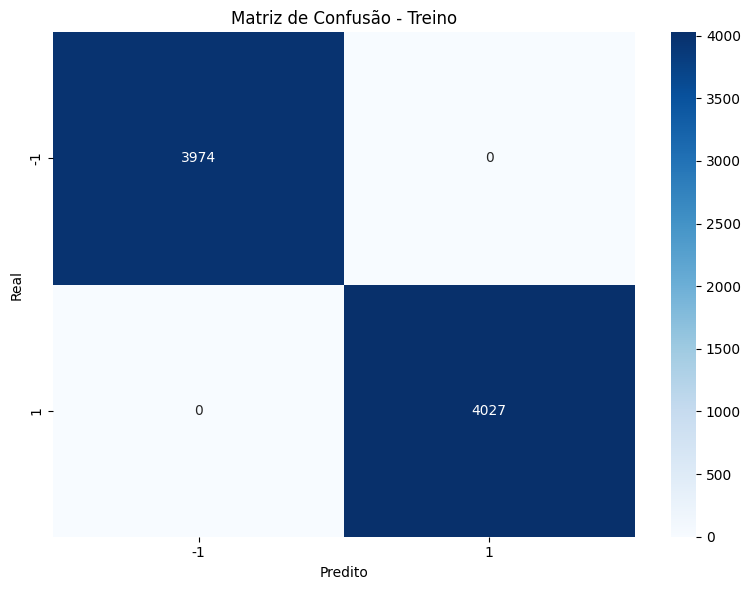

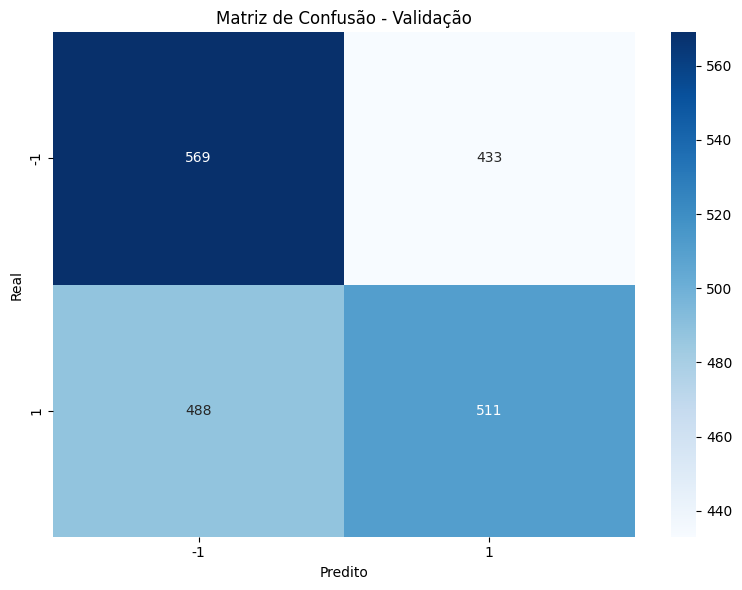

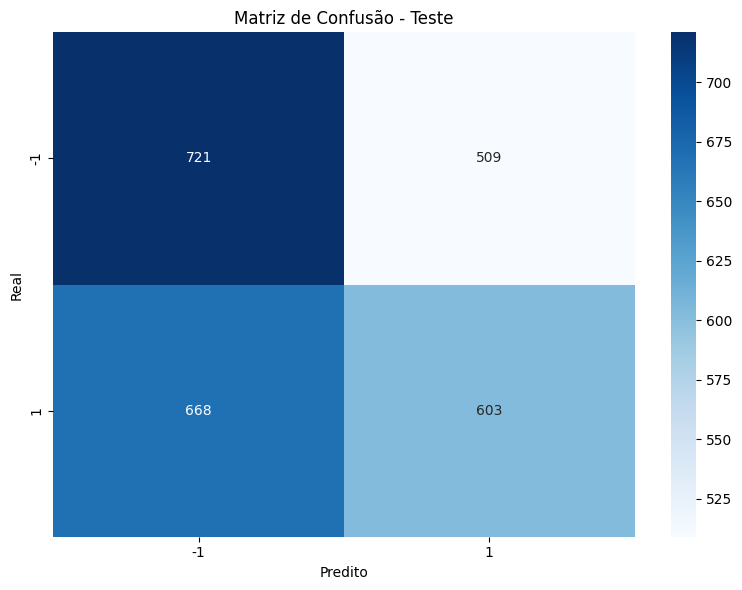

In [ ]:
# 1) Seleciona features finais
X = X[selected_features].copy()

# 2) Guarda índice original (se quiser rastrear depois)
X_index = X.index

# 3) Split temporal (sem embaralhar)
X_train_full, X_test, y_train_full, y_test, idx_train_full, idx_test = train_test_split(
    X, y, X_index, test_size=0.20, shuffle=False
)

X_train, X_val, y_train, y_val, idx_train, idx_val = train_test_split(
    X_train_full, y_train_full, idx_train_full, test_size=0.20, shuffle=False
)

# 4) Padronização (fit no TREINO; transforma VAL/TESTE)
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train.astype("float32"))
X_val_s   = scaler.transform(X_val.astype("float32"))
X_test_s  = scaler.transform(X_test.astype("float32"))

# 5) Instancia KNN com melhores params (garantindo n_neighbors válido)
best_params_safe = dict(best_params)
if "n_neighbors" in best_params_safe:
    best_params_safe["n_neighbors"] = int(min(best_params_safe["n_neighbors"], len(X_train_s)))
else:
    best_params_safe["n_neighbors"] = 5

# --- monta o pipeline completo ---
model = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("knn",    KNeighborsClassifier(**best_params_safe, algorithm="auto", n_jobs=-1))
])

# 6) Treino (sem eval_set)
model.fit(X_train_s, y_train)

# --- salvar e recarregar, atribuindo a 'model' ---
MODEL_PATH = "knn_pipeline.joblib"
dump(model, MODEL_PATH, compress=3)

# sobrescreve a variável 'model' com o pipeline recarregado do arquivo
model = load(MODEL_PATH)

# 7) Avaliar no conjunto de treino
y_pred_train = model.predict(X_train_s)
print("Acurácia (treino):", accuracy_score(y_train, y_pred_train))
print("\nRelatório (treino):\n", classification_report(y_train, y_pred_train))

# 8) Avaliar no conjunto de validação
y_pred_val = model.predict(X_val_s)
print("Acurácia (val):", accuracy_score(y_val, y_pred_val))
print("\nRelatório (val):\n", classification_report(y_val, y_pred_val))

# 9) Avaliar no conjunto de teste
y_pred_test = model.predict(X_test_s)
print("Acurácia (teste):", accuracy_score(y_test, y_pred_test))
print("\nRelatório (teste):\n", classification_report(y_test, y_pred_test))

# 10) Matrizes de confusão (mantendo todas as classes na mesma ordem)
classes = np.sort(pd.unique(y))
labels  = list(classes)

def plot_cm(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=[str(l) for l in labels],
                yticklabels=[str(l) for l in labels])
    plt.title(title)
    plt.xlabel('Predito')
    plt.ylabel('Real')
    plt.tight_layout()
    plt.show()

plot_cm(y_train, y_pred_train, "Matriz de Confusão - Treino")
plot_cm(y_val,   y_pred_val,   "Matriz de Confusão - Validação")
plot_cm(y_test,  y_pred_test,  "Matriz de Confusão - Teste")

[PCA] n_features orig: 109 → n_components: 18
[PCA] variância explicada acumulada: 0.9520
Acurácia (treino): 1.0

Relatório (treino):
               precision    recall  f1-score   support

          -1       1.00      1.00      1.00      3974
           1       1.00      1.00      1.00      4027

    accuracy                           1.00      8001
   macro avg       1.00      1.00      1.00      8001
weighted avg       1.00      1.00      1.00      8001

Acurácia (val): 0.5157421289355323

Relatório (val):
               precision    recall  f1-score   support

          -1       0.52      0.48      0.50      1002
           1       0.51      0.55      0.53       999

    accuracy                           0.52      2001
   macro avg       0.52      0.52      0.52      2001
weighted avg       0.52      0.52      0.52      2001

Acurácia (teste): 0.5061975209916033

Relatório (teste):
               precision    recall  f1-score   support

          -1       0.50      0.51      0.50 

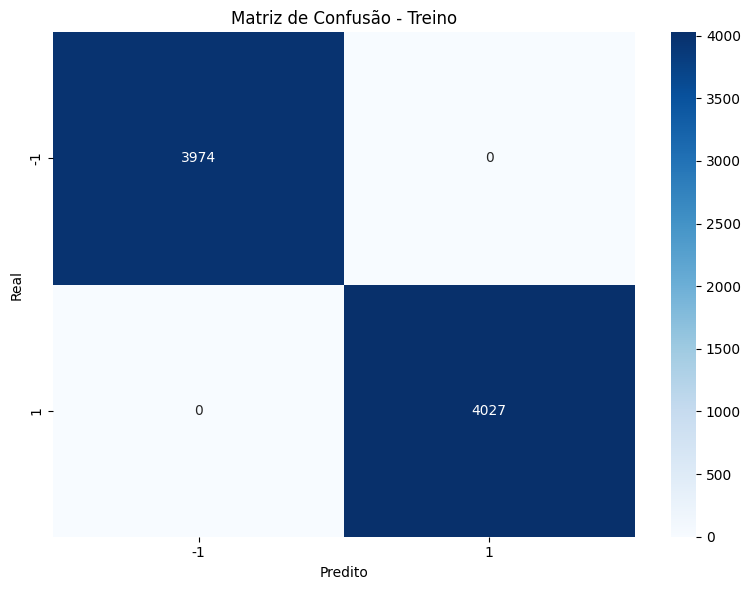

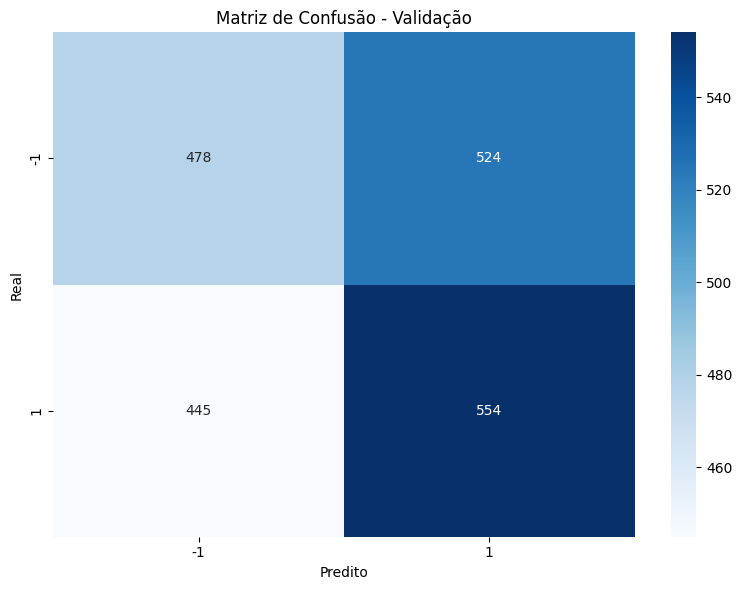

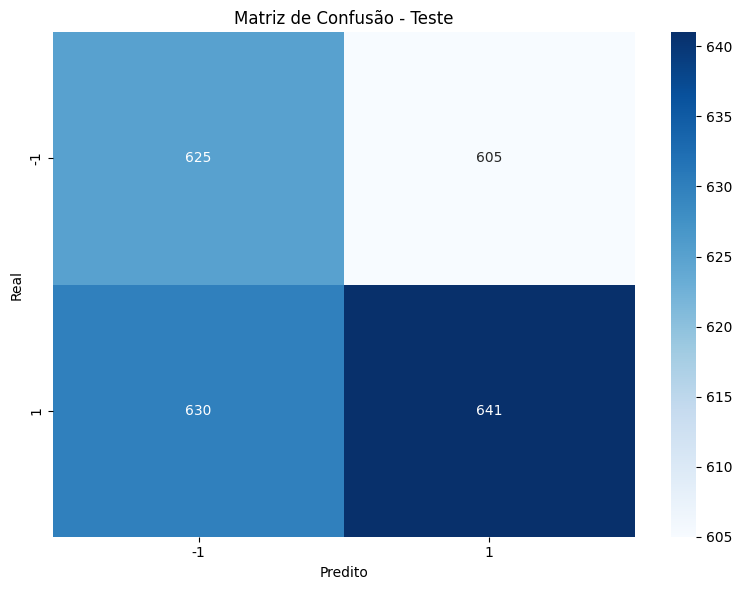

In [ ]:
# =========================
# Parâmetro do PCA
# =========================
# Pode ser float (0<valor<=1) para "variância explicada",
# ou int (nº fixo de componentes).
PCA_COMPONENTS = 0.95

'''# 1) Seleciona features finais
X = X[selected_features].copy().astype("float32")

# 2) Guarda índice original (se quiser rastrear depois)
X_index = X.index

# 3) Split temporal (sem embaralhar)
X_train_full, X_test, y_train_full, y_test, idx_train_full, idx_test = train_test_split(
    X, y, X_index, test_size=0.20, shuffle=False
)

X_train, X_val, y_train, y_val, idx_train, idx_val = train_test_split(
    X_train_full, y_train_full, idx_train_full, test_size=0.20, shuffle=False
)

# 4) Padronização (fit no TREINO; transforma VAL/TESTE)
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train.astype("float32"))
X_val_s   = scaler.transform(X_val.astype("float32"))
X_test_s  = scaler.transform(X_test.astype("float32"))'''

# 5) PCA (fit no TREINO; transforma VAL/TESTE)
pca = PCA(n_components=PCA_COMPONENTS, svd_solver="auto", whiten=False)
X_train_p = pca.fit_transform(X_train_s)
X_val_p   = pca.transform(X_val_s)
X_test_p  = pca.transform(X_test_s)

print(f"[PCA] n_features orig: {X_train_s.shape[1]} → n_components: {X_train_p.shape[1]}")
if hasattr(pca, "explained_variance_ratio_"):
    print(f"[PCA] variância explicada acumulada: {pca.explained_variance_ratio_.cumsum()[-1]:.4f}")

# 6) Instancia KNN com melhores params (garantindo n_neighbors válido)
best_params_safe = dict(best_params)
if "n_neighbors" in best_params_safe:
    best_params_safe["n_neighbors"] = int(min(best_params_safe["n_neighbors"], len(X_train_p)))
else:
    best_params_safe["n_neighbors"] = 5

# --- monta o pipeline completo ---
model = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("pca",    pca),
    ("knn",    KNeighborsClassifier(**best_params_safe, algorithm="auto", n_jobs=-1))
])

# 7) Treino (sem eval_set)
model.fit(X_train_p, y_train)

# --- salvar e recarregar, atribuindo a 'model' ---
MODEL_PATH = "knn_pipeline_withPCA.joblib"
dump(model, MODEL_PATH, compress=3)

# sobrescreve a variável 'model' com o pipeline recarregado do arquivo
model = load(MODEL_PATH)

# 8) Avaliar no conjunto de treino
y_pred_train = model.predict(X_train_p)
print("Acurácia (treino):", accuracy_score(y_train, y_pred_train))
print("\nRelatório (treino):\n", classification_report(y_train, y_pred_train))

# 9) Avaliar no conjunto de validação
y_pred_val = model.predict(X_val_p)
print("Acurácia (val):", accuracy_score(y_val, y_pred_val))
print("\nRelatório (val):\n", classification_report(y_val, y_pred_val))

# 10) Avaliar no conjunto de teste
y_pred_test = model.predict(X_test_p)
print("Acurácia (teste):", accuracy_score(y_test, y_pred_test))
print("\nRelatório (teste):\n", classification_report(y_test, y_pred_test))

# 11) Matrizes de confusão (ordem fixa das classes)
classes = np.sort(pd.unique(y))
labels  = list(classes)

def plot_cm(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=[str(l) for l in labels],
                yticklabels=[str(l) for l in labels])
    plt.title(title)
    plt.xlabel('Predito')
    plt.ylabel('Real')
    plt.tight_layout()
    plt.show()

plot_cm(y_train, y_pred_train, "Matriz de Confusão - Treino")
plot_cm(y_val,   y_pred_val,   "Matriz de Confusão - Validação")
plot_cm(y_test,  y_pred_test,  "Matriz de Confusão - Teste")


⚠️ Removendo 450 duplicatas de índice em X (keep='last')
⚠️ Removendo 450 duplicatas de índice em DF_OHLC (keep='last')


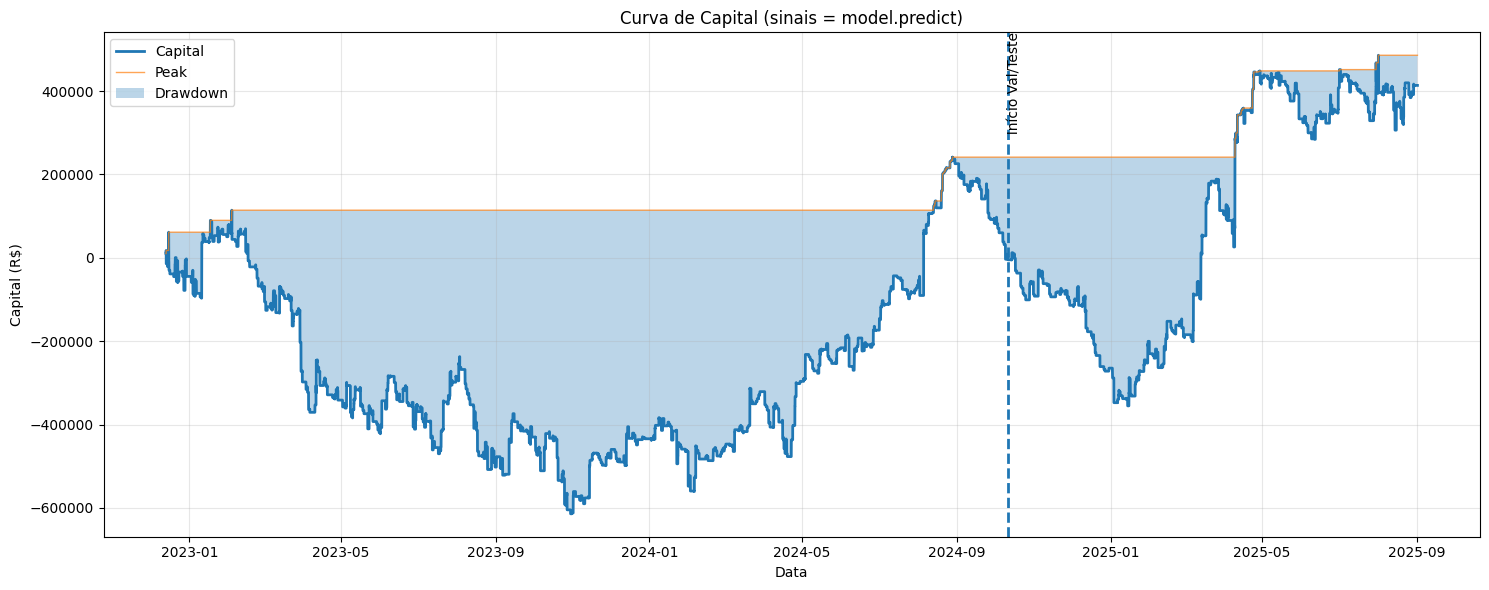

Trades: 8759 | Capital Final: R$ 413,663.95 | Retorno Total: 4036.64%
📈 Total de Trades (legs fechadas): 8759
✅ Trades Vencedores: 3704 (42.3%)
❌ Trades Perdedores: 5055
💰 Lucro Total: R$ 403,663.95
📊 Retorno Total: 4036.64%
📊 Lucro Médio por Trade: R$ 46.09
💚 Lucro Médio (Winners): R$ 2,570.98
💔 Perda Média (Losers): R$ -1,804.01
⚖️  Risk/Reward: 1.43
📈 Sharpe Ratio: 0.251
📉 Máximo Drawdown: R$ -728,297.55 (-149.9%)
🏁 Capital Inicial: R$ 10,000.00
🏁 Capital Final: R$ 413,663.95
⛔ Stop Diário (R$): 4,000.00
⛔ Dias com Stop Diário: 60


In [ ]:
# =========================================================
# Parâmetros do Backtest
# =========================================================
VALOR_POR_PONTO  = 0.20
STOP_PONTOS      = 1500
SLIPPAGE         = 2
CUSTO_OPERACAO   = 0.0
CAPITAL_INICIAL  = 10000.0
HORA_FECHAMENTO  = dtime(18, 0)
NUM_CONTRATOS    = 25
MAX_PERDA_DIARIA = 4000.0
STOP_ANCHOR      = "entry"        # "entry" ou "signal_open"

# =========================================================
# 0) Carrega o modelo salvo (NÃO TREINA)
# =========================================================
MODEL_PATH = "knn_pipeline.joblib"  # ajuste se necessário
model = load(MODEL_PATH)

# =========================================================
# Helpers de alinhamento e OHLC
# =========================================================
def ensure_ohlc(df_like: pd.DataFrame) -> pd.DataFrame:
    """
    Retorna um DF com colunas ['Date','Open','High','Low','Close'].
    Aceita nomes alternativos (PT/EN) e cria 'Date' a partir do índice se for DatetimeIndex.
    """
    tmp = df_like.copy()

    # 1) Garantir coluna Date
    if "Date" not in tmp.columns:
        if isinstance(tmp.index, pd.DatetimeIndex):
            tmp = tmp.reset_index()
            idx_name = tmp.columns[0]
            tmp = tmp.rename(columns={idx_name: "Date"})
        else:
            lower = {c.lower(): c for c in tmp.columns}
            for cand in ["date", "datetime", "timestamp", "data", "time"]:
                if cand in lower:
                    tmp = tmp.rename(columns={lower[cand]: "Date"})
                    break

    # 2) Mapear OHLC (case-insensitive)
    lower = {c.lower(): c for c in tmp.columns}
    def pick(*cands):
        for c in cands:
            if c in lower:
                return lower[c]
        return None

    ren = {}
    if "Open" not in tmp.columns:
        c = pick("open", "abertura", "o")
        if c: ren[c] = "Open"
    if "High" not in tmp.columns:
        c = pick("high", "max", "máxima", "maxima", "h")
        if c: ren[c] = "High"
    if "Low" not in tmp.columns:
        c = pick("low", "min", "mínima", "minima", "l")
        if c: ren[c] = "Low"
    if "Close" not in tmp.columns:
        c = pick("close", "fechamento", "c", "close_price", "price", "ultimo", "último")
        if c: ren[c] = "Close"

    if ren:
        tmp = tmp.rename(columns=ren)

    missing = [c for c in ["Date","Open","High","Low","Close"] if c not in tmp.columns]
    if missing:
        raise KeyError(
            f"Faltam colunas {missing}. Disponíveis: {list(df_like.columns)}. "
            "Se a data está no índice, este patch já faz reset_index automaticamente."
        )

    # 3) Tipos + validação
    tmp["Date"] = pd.to_datetime(tmp["Date"], errors="coerce")
    for c in ["Open","High","Low","Close"]:
        tmp[c] = pd.to_numeric(tmp[c], errors="coerce")
    if tmp[["Date","Open","High","Low","Close"]].isna().any().any():
        raise ValueError("NaNs encontrados em Date/Open/High/Low/Close após padronização.")

    return tmp[["Date","Open","High","Low","Close"]].copy()

def drop_dup_index(obj, keep="last", name="obj"):
    """
    Remove rótulos duplicados do índice (mantendo o último por padrão).
    Funciona para Series e DataFrames.
    """
    idx = obj.index
    if idx.has_duplicates:
        # mensagem opcional para depuração:
        print(f"⚠️ Removendo {idx.duplicated().sum()} duplicatas de índice em {name} (keep='{keep}')")
        return obj[~idx.duplicated(keep=keep)]
    return obj

def _tz_naive(idx: pd.Index) -> pd.Index:
    if isinstance(idx, pd.DatetimeIndex):
        return idx.tz_localize(None) if idx.tz is not None else idx
    return idx

def align_three(X_df: pd.DataFrame, y_s: pd.Series, ohlc_df: pd.DataFrame):
    """
    Alinha X, y e OHLC por:
      - interseção de índices (com normalização de timezone);
      - fallback posicional se não houver interseção mas os comprimentos forem iguais.
    Retorna X_al, y_al, D_al.
    """
    # normaliza timezone
    Xi = _tz_naive(X_df.index)
    yi = _tz_naive(y_s.index)
    Di = _tz_naive(ohlc_df.index)
    if not X_df.index.equals(Xi):   X_df = X_df.copy(); X_df.index = Xi
    if not y_s.index.equals(yi):    y_s  = y_s.copy();  y_s.index  = yi
    if not ohlc_df.index.equals(Di): ohlc_df = ohlc_df.copy(); ohlc_df.index = Di

    # remove duplicatas antes de intersectar
    X_df   = drop_dup_index(X_df, keep="last", name="X")
    y_s    = drop_dup_index(y_s,  keep="last", name="y")
    ohlc_df= drop_dup_index(ohlc_df, keep="last", name="DF_OHLC")

    inter = X_df.index.intersection(y_s.index).intersection(ohlc_df.index)

    # fallback posicional (mesmo tamanho, sem interseção)
    if len(inter) == 0 and (len(X_df) == len(y_s) == len(ohlc_df)):
        ohlc_df = ohlc_df.sort_values("Date").copy()
        X_df = X_df.sort_index()
        y_s = y_s.loc[X_df.index]
        ohlc_df.index = X_df.index
        inter = X_df.index

    if len(inter) == 0:
        raise RuntimeError(
            "Índices de X, y e DF_OHLC não se intersectam e o fallback posicional não pôde ser aplicado.\n"
            f"info: len(X)={len(X_df)}, len(y)={len(y_s)}, len(DF_OHLC)={len(ohlc_df)}\n"
            f"tipos de índice: X={type(X_df.index)}, y={type(y_s.index)}, OHLC={type(ohlc_df.index)}"
        )

    X_al = X_df.loc[inter]
    y_al = y_s.loc[inter]
    D_al = ohlc_df.loc[inter]
    return X_al, y_al, D_al

# =========================================================
# 1) PATCH OHLC a partir do seu 'df' de preços
#    -> se seu DF tem outro nome, troque 'df' por ele abaixo.
# =========================================================
base_prices = df.copy()                     # <<< troque se necessário
DF_OHLC     = ensure_ohlc(base_prices)

# =========================================================
# 2) Harmoniza features de X com o modelo
# =========================================================
feat_in = list(getattr(model, "feature_names_in_", []))
if feat_in:
    feature_cols = [c for c in feat_in if c in X.columns]
    if len(feature_cols) != len(feat_in):
        faltantes = [c for c in feat_in if c not in X.columns]
        print(f"⚠️ Aviso: features ausentes em X foram ignoradas: {faltantes}")
else:
    feature_cols = X.columns.tolist()

X_used = X[feature_cols].copy()
X_used = X_used.fillna(X_used.median(numeric_only=True))  # defesa contra NaN

# =========================================================
# 3) Alinha X, y, DF_OHLC (remove duplicatas e normaliza timezone)
# =========================================================
# Se X é DatetimeIndex, usar Date como índice para o OHLC facilita intersectar
if isinstance(X_used.index, pd.DatetimeIndex):
    DF_OHLC = DF_OHLC.set_index(pd.to_datetime(DF_OHLC["Date"]))

# y como Series (caso seja array)
if not isinstance(y, pd.Series):
    y = pd.Series(y, index=X_used.index)

X_used, y, DF_OHLC = align_three(X_used, y, DF_OHLC)

# =========================================================
# 4) Splits (sem embaralhar)
# =========================================================
X_index = X_used.index
X_train_full, X_test, y_train_full, y_test, idx_train_full, idx_test = train_test_split(
    X_used, y, X_index, test_size=0.20, shuffle=False
)
X_train, X_val, y_train, y_val, idx_train, idx_val = train_test_split(
    X_train_full, y_train_full, idx_train_full, test_size=0.20, shuffle=False
)

# =========================================================
# 5) PREVISÕES (modelo já carregado)
# =========================================================
yhat_train = pd.Series(model.predict(X_train), index=idx_train, name="pred")
yhat_val   = pd.Series(model.predict(X_val),   index=idx_val,   name="pred")
yhat_test  = pd.Series(model.predict(X_test),  index=idx_test,  name="pred")

# Concatena, ordena e REMOVE duplicatas no índice de previsões
yhat_all = pd.concat([yhat_train, yhat_val, yhat_test]).sort_index()
yhat_all = drop_dup_index(yhat_all.astype(int), keep="last", name="yhat_all")

# =========================================================
# 6) Monta DF do backtest com DF_OHLC já alinhado
# =========================================================
df_src_bt = DF_OHLC.loc[yhat_all.index].copy()

df_test = df_src_bt[["Date","Open","High","Low","Close"]].copy()
df_test["Date"] = pd.to_datetime(df_test["Date"])
df_test = df_test.sort_index()

# Garantir índice único em df_test também (por via das dúvidas)
df_test = drop_dup_index(df_test, keep="last", name="df_test")

df_test["date_only"] = df_test["Date"].dt.date
df_test["time_only"] = df_test["Date"].dt.time

# <<< AQUI ESTAVA O ERRO: use .loc com yhat_all já deduplicado >>>
df_test["prediction"] = yhat_all.loc[df_test.index].astype(int)

# Sinal válido no candle corrente = sinal do candle anterior
df_test["sig_prev"]  = df_test["prediction"].shift(1)
df_test["open_prev"] = df_test["Open"].shift(1)
df_test["is_last_candle_day"] = df_test["date_only"] != df_test["date_only"].shift(-1)

# Remove 1ª linha inválida pelo shift, mantendo índice original
df_test = df_test.dropna(subset=["sig_prev", "open_prev"]).copy()

# Marca OOS (val+test) pelos índices dos splits
oos_index = set(idx_val) | set(idx_test)
df_test["is_oos"] = df_test.index.isin(oos_index)
dt_oos_start = df_test.loc[df_test["is_oos"], "Date"].min() if df_test["is_oos"].any() else None

# =========================================================
# 7) Backtest
# =========================================================
capital = CAPITAL_INICIAL
legs = []
historico_trades = []
equity_curve = []
net_pos_vec = []
avg_entry_vec = []
closest_stop_vec = []

_leg_counter = 0
current_day = None
realized_pl_today = 0.0
halted_today = False

def apply_slippage(price, side, slippage_points):
    if slippage_points == 0: return price
    return price + (slippage_points if side == 1 else -slippage_points)

def trade_pl(exit_price, entry_price, side, contracts):
    pontos = (exit_price - entry_price) * side
    return pontos * VALOR_POR_PONTO * contracts

def net_side(legs):
    return 0 if len(legs) == 0 else legs[0]['side']

def avg_entry_price(legs):
    if not legs: return np.nan
    q = sum(l['qty'] for l in legs)
    return sum(l['entry'] * l['qty'] for l in legs) / q if q > 0 else np.nan

def closest_stop(legs):
    if not legs: return np.nan
    s = net_side(legs)
    stops = [l['stop'] for l in legs]
    if s == 1: return max(stops)
    if s == -1: return min(stops)
    return np.nan

def _calc_stop(sig, entry_px, oref):
    if STOP_ANCHOR == "entry":
        return entry_px - STOP_PONTOS if sig == 1 else entry_px + STOP_PONTOS
    elif STOP_ANCHOR == "signal_open":
        return oref - STOP_PONTOS if sig == 1 else oref + STOP_PONTOS
    else:
        raise ValueError("STOP_ANCHOR deve ser 'entry' ou 'signal_open'.")

def close_leg(leg, dt, exit_price, motivo):
    global capital, realized_pl_today, halted_today
    pl = trade_pl(exit_price, leg['entry'], leg['side'], leg['qty']) - CUSTO_OPERACAO
    capital += pl
    realized_pl_today += pl
    historico_trades.append({
        'data_entrada': leg['entry_time'],
        'data_saida': dt,
        'tipo': 'Compra' if leg['side'] == 1 else 'Venda',
        'contratos': leg['qty'],
        'preco_entrada': leg['entry'],
        'preco_saida': exit_price,
        'retorno_pontos': (exit_price - leg['entry']) * leg['side'],
        'pl': pl,
        'motivo_saida': motivo,
        'leg_id': leg['leg_id']
    })
    if realized_pl_today <= -MAX_PERDA_DIARIA:
        halted_today = True

for _, row in df_test.iterrows():
    dt   = row["Date"]
    d    = row["date_only"]
    t    = row["time_only"]
    o    = float(row["Open"])
    h    = float(row["High"])
    l    = float(row["Low"])
    c    = float(row["Close"])

    # Virada de dia reseta o stop diário
    if (current_day is None) or (d != current_day):
        current_day = d
        realized_pl_today = 0.0
        halted_today = False

    sig  = int(row["sig_prev"])    # {-1,0,1}
    oref = float(row["open_prev"]) # abertura do candle do sinal

    # 1) Flatten/Reverse no open
    if legs and (sig == 0 or (sig in (1, -1) and sig != net_side(legs))):
        exit_price_all = apply_slippage(o, -net_side(legs), SLIPPAGE)
        for leg in list(legs):
            close_leg(leg, dt, exit_price_all, "Flatten/Reverse no Open")
        legs.clear()

        if (not halted_today) and (sig in (1, -1)) and (NUM_CONTRATOS > 0):
            _leg_counter += 1
            entry_px = apply_slippage(o, sig, SLIPPAGE)
            stop_px  = _calc_stop(sig, entry_px, oref)
            legs.append({
                'side': sig, 'qty': NUM_CONTRATOS, 'entry': entry_px, 'entry_time': dt,
                'stop': stop_px, 'ref_open': oref, 'leg_id': _leg_counter
            })

    # 2) Abertura/Empilhamento
    elif (not halted_today) and (sig in (1, -1)) and NUM_CONTRATOS > 0:
        if (not legs) or (sig == net_side(legs)):
            _leg_counter += 1
            entry_px = apply_slippage(o, sig, SLIPPAGE)
            stop_px  = _calc_stop(sig, entry_px, oref)
            legs.append({
                'side': sig, 'qty': NUM_CONTRATOS, 'entry': entry_px, 'entry_time': dt,
                'stop': stop_px, 'ref_open': oref, 'leg_id': _leg_counter
            })

    # 3) Stops intrabar
    if legs:
        s = net_side(legs)
        if s == 1:
            triggered = [leg for leg in legs if l <= leg['stop']]
            for leg in list(triggered):
                exit_px = apply_slippage(leg['stop'], -leg['side'], SLIPPAGE)
                close_leg(leg, dt, exit_px, "Stop")
                legs.remove(leg)
        else:
            triggered = [leg for leg in legs if h >= leg['stop']]
            for leg in list(triggered):
                exit_px = apply_slippage(leg['stop'], -leg['side'], SLIPPAGE)
                close_leg(leg, dt, exit_px, "Stop")
                legs.remove(leg)

    # 4) Stop Diário
    if legs and halted_today:
        s = net_side(legs)
        exit_px_stopdia = apply_slippage(c, -s, SLIPPAGE)
        for leg in list(legs):
            close_leg(leg, dt, exit_px_stopdia, "Stop Diário (flatten)")
            legs.remove(leg)

    # 5) Fechamento obrigatório do dia
    if legs and (t >= HORA_FECHAMENTO or row["is_last_candle_day"]):
        s = net_side(legs)
        exit_px_day = apply_slippage(c, -s, SLIPPAGE)
        for leg in list(legs):
            close_leg(leg, dt, exit_px_day, "Fechamento Daytrade")
            legs.remove(leg)

    # Séries
    equity_curve.append(capital)
    net_pos_vec.append(net_side(legs))
    avg_entry_vec.append(avg_entry_price(legs))
    closest_stop_vec.append(closest_stop(legs))

# Fecha o que sobrou no fim
if legs:
    last_close = float(df_test.iloc[-1]["Close"])
    last_dt    = df_test.iloc[-1]["Date"]
    s = net_side(legs)
    exit_px_final = apply_slippage(last_close, -s, SLIPPAGE)
    for leg in list(legs):
        close_leg(leg, last_dt, exit_px_final, "Fechamento Série")
        legs.remove(leg)

# =========================================================
# 8) Resultados + Curva de Capital com linha vertical OOS
# =========================================================
df_test["capital"] = equity_curve
df_test["posicao"] = net_pos_vec
df_test["preco_entrada_media"] = avg_entry_vec
df_test["stop_mais_proximo"] = closest_stop_vec

df_test["peak"] = df_test["capital"].cummax()
df_test["drawdown"] = df_test["capital"] - df_test["peak"]

plt.figure(figsize=(15, 6))
ax = plt.gca()
ax.plot(df_test["Date"], df_test["capital"], label="Capital", linewidth=2)
ax.plot(df_test["Date"], df_test["peak"], label="Peak", linewidth=1, alpha=0.7)
ax.fill_between(df_test["Date"], df_test["peak"], df_test["capital"],
                where=(df_test["capital"] < df_test["peak"]),
                alpha=0.3, label='Drawdown')
if dt_oos_start is not None:
    ax.axvline(pd.to_datetime(dt_oos_start), linestyle="--", linewidth=2)
    ax.text(pd.to_datetime(dt_oos_start), ax.get_ylim()[1],
            "  Início Val/Teste", rotation=90, va='top', ha='left')
ax.set_title("Curva de Capital (sinais = model.predict)")
ax.set_xlabel("Data"); ax.set_ylabel("Capital (R$)")
ax.grid(True, alpha=0.3); ax.legend()
plt.tight_layout()
plt.show()

# Sumário simples
total_trades = len(pd.DataFrame(historico_trades))
capital_final = df_test["capital"].iloc[-1]
retorno_total = ((capital_final - CAPITAL_INICIAL) / CAPITAL_INICIAL) * 100.0
print(f"Trades: {total_trades} | Capital Final: R$ {capital_final:,.2f} | Retorno Total: {retorno_total:.2f}%")

# (Opcional) DF de sinais para inspecionar/guardar
df_signals = df_test[["Date","prediction","sig_prev","Open","High","Low","Close"]].copy()

# =========================================================
# 9) Métricas detalhadas + prints "executivo"
# =========================================================
df_historico = pd.DataFrame(historico_trades)

if not df_historico.empty:
    total_trades = int(len(df_historico))
    trades_vencedores = int((df_historico['pl'] > 0).sum())
    trades_perdedores = int((df_historico['pl'] <= 0).sum())
    win_rate = (trades_vencedores / total_trades * 100.0) if total_trades > 0 else 0.0

    total_pl = float(df_historico['pl'].sum())
    mean_pl  = float(df_historico['pl'].mean())
    std_pl   = float(df_historico['pl'].std(ddof=1)) if total_trades > 1 else 0.0

    lucro_medio = float(df_historico.loc[df_historico['pl'] > 0, 'pl'].mean()) if trades_vencedores > 0 else 0.0
    perda_media = float(df_historico.loc[df_historico['pl'] <= 0, 'pl'].mean()) if trades_perdedores > 0 else 0.0
    risk_reward = (abs(lucro_medio / perda_media) if perda_media < 0 else np.nan)

    sharpe = (mean_pl / std_pl * np.sqrt(252)) if (std_pl and std_pl > 0) else np.nan

    # drawdown já foi calculado acima; se quiser garantir:
    if "peak" not in df_test.columns:
        df_test["peak"] = df_test["capital"].cummax()
    if "drawdown" not in df_test.columns:
        df_test["drawdown"] = df_test["capital"] - df_test["peak"]

    max_dd = float(df_test["drawdown"].min())
    peak_max = float(df_test["peak"].max()) if len(df_test) else np.nan
    max_dd_pct = (max_dd / peak_max * 100.0) if peak_max and not np.isnan(peak_max) else np.nan

    capital_inicial = float(CAPITAL_INICIAL)
    capital_final   = float(df_test["capital"].iloc[-1]) if len(df_test) else capital_inicial
    retorno_total   = ((capital_final - capital_inicial) / capital_inicial) * 100.0 if capital_inicial else np.nan

    # Dias com Stop Diário (usa 'motivo_saida' do histórico)
    mask_stop = df_historico['motivo_saida'].astype(str).str.contains('Stop Diário', na=False)
    dias_stop_diario = pd.to_datetime(df_historico.loc[mask_stop, 'data_saida']).dt.date.nunique()

    # ======= PRINTS REQUERIDOS =======
    print(f"📈 Total de Trades (legs fechadas): {total_trades}")
    print(f"✅ Trades Vencedores: {trades_vencedores} ({win_rate:.1f}%)")
    print(f"❌ Trades Perdedores: {trades_perdedores}")
    print(f"💰 Lucro Total: R$ {total_pl:,.2f}")
    print(f"📊 Retorno Total: {retorno_total:.2f}%")
    print(f"📊 Lucro Médio por Trade: R$ {mean_pl:,.2f}")
    print(f"💚 Lucro Médio (Winners): R$ {lucro_medio:,.2f}")
    print(f"💔 Perda Média (Losers): R$ {perda_media:,.2f}")
    print(f"⚖️  Risk/Reward: {risk_reward:.2f}")
    print(f"📈 Sharpe Ratio: {sharpe:.3f}")
    print(f"📉 Máximo Drawdown: R$ {max_dd:,.2f} ({max_dd_pct:.1f}%)")
    print(f"🏁 Capital Inicial: R$ {capital_inicial:,.2f}")
    print(f"🏁 Capital Final: R$ {capital_final:,.2f}")
    print(f"⛔ Stop Diário (R$): {MAX_PERDA_DIARIA:,.2f}")
    print(f"⛔ Dias com Stop Diário: {dias_stop_diario}")

else:
    # Sem trades: ainda assim imprimimos um resumo consistente
    capital_inicial = float(CAPITAL_INICIAL)
    capital_final   = float(df_test["capital"].iloc[-1]) if len(df_test) else capital_inicial
    retorno_total   = ((capital_final - capital_inicial) / capital_inicial) * 100.0 if capital_inicial else np.nan

    # drawdown/peak (se não existirem)
    if "peak" not in df_test.columns:
        df_test["peak"] = df_test["capital"].cummax()
    if "drawdown" not in df_test.columns:
        df_test["drawdown"] = df_test["capital"] - df_test["peak"]

    max_dd = float(df_test["drawdown"].min())
    peak_max = float(df_test["peak"].max()) if len(df_test) else np.nan
    max_dd_pct = (max_dd / peak_max * 100.0) if peak_max and not np.isnan(peak_max) else np.nan

    print("⚠️ Nenhum trade foi executado no período de backtest.")
    print(f"🏁 Capital Inicial: R$ {capital_inicial:,.2f}")
    print(f"🏁 Capital Final: R$ {capital_final:,.2f}")
    print(f"📊 Retorno Total: {retorno_total:.2f}%")
    print(f"📉 Máximo Drawdown: R$ {max_dd:,.2f} ({max_dd_pct:.1f}%)")



⚠️ Fallback: usando as primeiras 18 colunas de X para casar com n_features_in_ do passo 'StandardScaler'.
⚠️ Removendo 450 duplicatas de índice em X (keep='last')
⚠️ Removendo 450 duplicatas de índice em DF_OHLC (keep='last')
⚠️ Aviso: fallback para model.predict (sem máscara de PCs). Motivo: name 're' is not defined
⚠️ Aviso: fallback para model.predict (sem máscara de PCs). Motivo: name 're' is not defined
⚠️ Aviso: fallback para model.predict (sem máscara de PCs). Motivo: name 're' is not defined


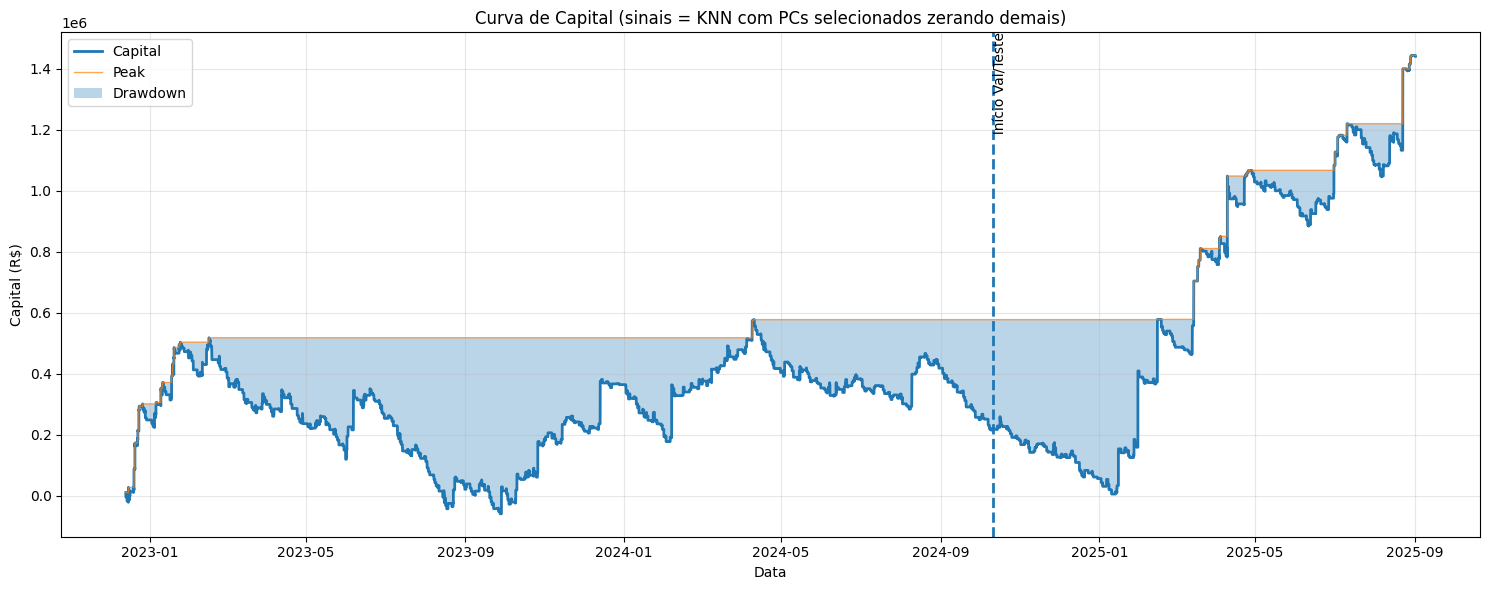

Trades: 7464 | Capital Final: R$ 1,441,454.35 | Retorno Total: 14314.54%
📈 Total de Trades (legs fechadas): 7464
✅ Trades Vencedores: 2996 (40.1%)
❌ Trades Perdedores: 4468
💰 Lucro Total: R$ 1,431,454.35
📊 Retorno Total: 14314.54%
📊 Lucro Médio por Trade: R$ 191.78
💚 Lucro Médio (Winners): R$ 2,991.16
💔 Perda Média (Losers): R$ -1,685.33
⚖️  Risk/Reward: 1.77
📈 Sharpe Ratio: 0.988
📉 Máximo Drawdown: R$ -577,656.15 (-40.0%)
🏁 Capital Inicial: R$ 10,000.00
🏁 Capital Final: R$ 1,441,454.35
⛔ Stop Diário (R$): 4,000.00
⛔ Dias com Stop Diário: 281


In [ ]:
# =========================================================
# Parâmetros do Backtest
# =========================================================
VALOR_POR_PONTO  = 0.20
STOP_PONTOS      = 700
SLIPPAGE         = 2
CUSTO_OPERACAO   = 0.0
CAPITAL_INICIAL  = 10000.0
HORA_FECHAMENTO  = dtime(18, 0)
NUM_CONTRATOS    = 25
MAX_PERDA_DIARIA = 4000.0
STOP_ANCHOR      = "entry"        # "entry" ou "signal_open"

# =========================================================
# 0) Carrega o modelo salvo (NÃO TREINA)
# =========================================================
MODEL_PATH = "knn_pipeline_withPCA.joblib"  # ajuste se necessário
model = load(MODEL_PATH)

# =========================================================
# Helpers: OHLC e alinhamento
# =========================================================
def ensure_ohlc(df_like: pd.DataFrame) -> pd.DataFrame:
    tmp = df_like.copy()
    # Date
    if "Date" not in tmp.columns:
        if isinstance(tmp.index, pd.DatetimeIndex):
            tmp = tmp.reset_index()
            idx_name = tmp.columns[0]
            tmp = tmp.rename(columns={idx_name: "Date"})
        else:
            lower = {c.lower(): c for c in tmp.columns}
            for cand in ["date","datetime","timestamp","data","time"]:
                if cand in lower:
                    tmp = tmp.rename(columns={lower[cand]: "Date"})
                    break
    # Mapear OHLC
    lower = {c.lower(): c for c in tmp.columns}
    def pick(*cands):
        for c in cands:
            if c in lower: return lower[c]
        return None
    ren = {}
    if "Open"  not in tmp.columns:
        c = pick("open","abertura","o");              ren[c] = "Open"  if c else None
    if "High"  not in tmp.columns:
        c = pick("high","max","máxima","maxima","h"); ren[c] = "High"  if c else None
    if "Low"   not in tmp.columns:
        c = pick("low","min","mínima","minima","l");  ren[c] = "Low"   if c else None
    if "Close" not in tmp.columns:
        c = pick("close","fechamento","c","close_price","price","ultimo","último")
        ren[c] = "Close" if c else None
    ren = {k:v for k,v in ren.items() if k is not None}
    if ren: tmp = tmp.rename(columns=ren)

    missing = [c for c in ["Date","Open","High","Low","Close"] if c not in tmp.columns]
    if missing:
        raise KeyError(f"Faltam colunas {missing}. Disponíveis: {list(df_like.columns)}.")

    tmp["Date"] = pd.to_datetime(tmp["Date"], errors="coerce")
    for c in ["Open","High","Low","Close"]:
        tmp[c] = pd.to_numeric(tmp[c], errors="coerce")
    if tmp[["Date","Open","High","Low","Close"]].isna().any().any():
        raise ValueError("NaNs em Date/Open/High/Low/Close após padronização.")
    return tmp[["Date","Open","High","Low","Close"]].copy()

def drop_dup_index(obj, keep="last", name="obj"):
    if obj.index.has_duplicates:
        print(f"⚠️ Removendo {obj.index.duplicated().sum()} duplicatas de índice em {name} (keep='{keep}')")
        return obj[~obj.index.duplicated(keep=keep)]
    return obj

def _tz_naive(idx: pd.Index) -> pd.Index:
    if isinstance(idx, pd.DatetimeIndex):
        return idx.tz_localize(None) if idx.tz is not None else idx
    return idx

def align_three(X_df: pd.DataFrame, y_s: pd.Series, ohlc_df: pd.DataFrame):
    Xi = _tz_naive(X_df.index); yi = _tz_naive(y_s.index); Di = _tz_naive(ohlc_df.index)
    if not X_df.index.equals(Xi):   X_df = X_df.copy(); X_df.index = Xi
    if not y_s.index.equals(yi):    y_s  = y_s.copy();  y_s.index  = yi
    if not ohlc_df.index.equals(Di): ohlc_df = ohlc_df.copy(); ohlc_df.index = Di
    X_df    = drop_dup_index(X_df,    name="X")
    y_s     = drop_dup_index(y_s,     name="y")
    ohlc_df = drop_dup_index(ohlc_df, name="DF_OHLC")
    inter = X_df.index.intersection(y_s.index).intersection(ohlc_df.index)
    if len(inter) == 0 and (len(X_df)==len(y_s)==len(ohlc_df)):
        ohlc_df = ohlc_df.sort_values("Date").copy()
        X_df = X_df.sort_index()
        y_s = y_s.loc[X_df.index]
        ohlc_df.index = X_df.index
        inter = X_df.index
    if len(inter) == 0:
        raise RuntimeError("Sem interseção entre índices de X, y e DF_OHLC e fallback posicional falhou.")
    return X_df.loc[inter], y_s.loc[inter], ohlc_df.loc[inter]

# =========================================================
# 1) OHLC a partir do seu 'df' de preços
# =========================================================
base_prices = df.copy()             # <<< troque se necessário
DF_OHLC     = ensure_ohlc(base_prices)

# =========================================================
# 2) Descobre **as MESMAS colunas de entrada** usadas no treino
#    Prioridades:
#    - model.feature_names_in_
#    - feature_names_in_ de algum passo do pipeline (ex.: scaler/pca)
#    - se nada existir: usa o N esperado pelo primeiro passo que tiver n_features_in_
#      e pega as primeiras N colunas de X (fallback)
# =========================================================
def discover_train_input_columns(model, X_df):
    # 1) do próprio pipeline
    if hasattr(model, "feature_names_in_"):
        return list(model.feature_names_in_)
    # 2) de passos internos (ordem: scaler, pca, knn)
    if isinstance(model, Pipeline):
        for step in ["scaler", "standardscaler", "preprocess", "preprocessor"]:
            if step in model.named_steps and hasattr(model.named_steps[step], "feature_names_in_"):
                return list(model.named_steps[step].feature_names_in_)
        # qualquer passo com feature_names_in_
        for _, st in model.named_steps.items():
            if hasattr(st, "feature_names_in_"):
                return list(st.feature_names_in_)
        # 3) se nenhum nome disponível, tenta usar contagem
        #    pega o primeiro passo com n_features_in_ (ex.: StandardScaler)
        for _, st in model.named_steps.items():
            if hasattr(st, "n_features_in_"):
                m = int(st.n_features_in_)
                if X_df.shape[1] >= m:
                    print(f"⚠️ Fallback: usando as primeiras {m} colunas de X para casar com n_features_in_ do passo '{type(st).__name__}'.")
                    return list(X_df.columns[:m])
    # 4) último recurso: mantém todas (pode falhar se o pipeline exigir menos)
    print("⚠️ Aviso: não foi possível inferir colunas de treino. Usando X.columns (pode falhar).")
    return list(X_df.columns)

TRAIN_INPUT = discover_train_input_columns(model, X)

# Reindexa X para ter **exatamente** as colunas do treino, na mesma ordem
X_used = (
    X.reindex(columns=TRAIN_INPUT)
     .apply(pd.to_numeric, errors="coerce")
     .fillna(0.0)
)

# =========================================================
# 3) Alinha X, y, DF_OHLC
# =========================================================
if isinstance(X_used.index, pd.DatetimeIndex):
    DF_OHLC = DF_OHLC.set_index(pd.to_datetime(DF_OHLC["Date"]))
if not isinstance(y, pd.Series):
    y = pd.Series(y, index=X_used.index)

X_used, y, DF_OHLC = align_three(X_used, y, DF_OHLC)

# =========================================================
# 4) Splits temporais
# =========================================================
X_index = X_used.index
X_train_full, X_test, y_train_full, y_test, idx_train_full, idx_test = train_test_split(
    X_used, y, X_index, test_size=0.20, shuffle=False
)
X_train, X_val, y_train, y_val, idx_train, idx_val = train_test_split(
    X_train_full, y_train_full, idx_train_full, test_size=0.20, shuffle=False
)

# =========================================================
# 5) PREVISÕES no espaço do KNN (pós-PCA do pipeline)
#    -> usa model[:-1].transform(X_aligned) para obter exatamente as features do KNN
#    -> aplica máscara de PCs (selected_features) zerando os demais (sem alterar dimensão)
# =========================================================
def pipeline_has_knn(m):
    return isinstance(m, Pipeline) and isinstance(m.steps[-1][1], KNeighborsClassifier)

def transformed_to_knn_space(m, X_df):
    """Retorna Z = features que chegam no KNN (após **todo** pré-processamento)."""
    if not pipeline_has_knn(m):
        raise RuntimeError("O objeto carregado não é Pipeline[KNN] — não é possível extrair espaço do KNN.")
    return m[:-1].transform(X_df)   # aplica todos os passos exceto o KNN

def get_knn_step(m):
    return m.steps[-1][1] if pipeline_has_knn(m) else None

def normalize_selected_to_indices(sel, d_dim):
    """
    Converte selected_features para índices (0..d-1).
    Aceita inteiros, 'PCk', 'Fk', 'k' (pega sufixo numérico).
    """
    if sel is None:
        return None
    idxs = []
    for s in sel:
        if isinstance(s, int):
            i = s
        else:
            s = str(s)
            mnum = re.search(r'(\d+)$', s)
            if not mnum:
                continue
            i = int(mnum.group(1))
        if 0 <= i < d_dim:
            idxs.append(i)
    return sorted(set(idxs))

# normaliza selected_features do seu ambiente
try:
    sel_hint = list(selected_features)
except NameError:
    sel_hint = None

def predict_with_masked_pcs(m, X_df, sel_hint=None):
    # **sempre** alinhar as colunas de entrada
    X_aligned = (
        X_df.reindex(columns=TRAIN_INPUT)
            .apply(pd.to_numeric, errors="coerce")
            .fillna(0.0)
    )
    # transforma até o KNN (respeita exatamente o que o scaler/pca esperam)
    Z = transformed_to_knn_space(m, X_aligned)      # shape (n, d)
    d = Z.shape[1]
    idxs = normalize_selected_to_indices(sel_hint, d)
    if idxs is not None and len(idxs) > 0:
        Z_mask = np.zeros_like(Z)
        Z_mask[:, idxs] = Z[:, idxs]               # mantém só PCs selecionados; zera o resto
    else:
        Z_mask = Z
    knn = get_knn_step(m)
    return pd.Series(knn.predict(Z_mask), index=X_aligned.index, name="pred")

def predict_wrapper(m, X_df):
    try:
        return predict_with_masked_pcs(m, X_df, sel_hint)
    except Exception as e:
        print(f"⚠️ Aviso: fallback para model.predict (sem máscara de PCs). Motivo: {e}")
        # ainda assim alinhar colunas p/ pipeline não quebrar
        X_aligned = (
            X_df.reindex(columns=TRAIN_INPUT)
                .apply(pd.to_numeric, errors="coerce")
                .fillna(0.0)
        )
        return pd.Series(m.predict(X_aligned), index=X_aligned.index, name="pred")

# Previsões
yhat_train = predict_wrapper(model, X_train)
yhat_val   = predict_wrapper(model, X_val)
yhat_test  = predict_wrapper(model, X_test)

# Concatena e deduplica índice
def drop_dup_index_series(s, keep="last", name="series"):
    return s[~s.index.duplicated(keep=keep)] if s.index.has_duplicates else s

yhat_all = pd.concat([yhat_train, yhat_val, yhat_test]).sort_index().astype(int)
yhat_all = drop_dup_index_series(yhat_all, name="yhat_all")

# =========================================================
# 6) DF do backtest alinhado
# =========================================================
df_src_bt = DF_OHLC.loc[yhat_all.index].copy()

df_test = df_src_bt[["Date","Open","High","Low","Close"]].copy()
df_test["Date"] = pd.to_datetime(df_test["Date"])
df_test = df_test.sort_index()
df_test = drop_dup_index(df_test, keep="last", name="df_test")

df_test["date_only"] = df_test["Date"].dt.date
df_test["time_only"] = df_test["Date"].dt.time

df_test["prediction"] = yhat_all.loc[df_test.index].astype(int)

# Sinal válido no candle corrente = sinal do candle anterior
df_test["sig_prev"]  = df_test["prediction"].shift(1)
df_test["open_prev"] = df_test["Open"].shift(1)
df_test["is_last_candle_day"] = df_test["date_only"] != df_test["date_only"].shift(-1)

# Remove 1ª linha inválida pelo shift
df_test = df_test.dropna(subset=["sig_prev", "open_prev"]).copy()

# Marca OOS (val+test) pelos índices dos splits
oos_index = set(idx_val) | set(idx_test)
df_test["is_oos"] = df_test.index.isin(oos_index)
dt_oos_start = df_test.loc[df_test["is_oos"], "Date"].min() if df_test["is_oos"].any() else None

# =========================================================
# 7) Backtest
# =========================================================
capital = CAPITAL_INICIAL
legs = []
historico_trades = []
equity_curve = []
net_pos_vec = []
avg_entry_vec = []
closest_stop_vec = []

_leg_counter = 0
current_day = None
realized_pl_today = 0.0
halted_today = False

def apply_slippage(price, side, slippage_points):
    return price if slippage_points == 0 else price + (slippage_points if side == 1 else -slippage_points)

def trade_pl(exit_price, entry_price, side, contracts):
    pontos = (exit_price - entry_price) * side
    return pontos * VALOR_POR_PONTO * contracts

def net_side(legs):
    return 0 if len(legs) == 0 else legs[0]['side']

def avg_entry_price(legs):
    if not legs: return np.nan
    q = sum(l['qty'] for l in legs)
    return sum(l['entry'] * l['qty'] for l in legs) / q if q > 0 else np.nan

def closest_stop(legs):
    if not legs: return np.nan
    s = net_side(legs)
    stops = [l['stop'] for l in legs]
    return max(stops) if s == 1 else (min(stops) if s == -1 else np.nan)

def _calc_stop(sig, entry_px, oref):
    if STOP_ANCHOR == "entry":
        return entry_px - STOP_PONTOS if sig == 1 else entry_px + STOP_PONTOS
    elif STOP_ANCHOR == "signal_open":
        return oref - STOP_PONTOS if sig == 1 else oref + STOP_PONTOS
    else:
        raise ValueError("STOP_ANCHOR deve ser 'entry' ou 'signal_open'.")

def close_leg(leg, dt, exit_price, motivo):
    global capital, realized_pl_today, halted_today
    pl = trade_pl(exit_price, leg['entry'], leg['side'], leg['qty']) - CUSTO_OPERACAO
    capital += pl
    realized_pl_today += pl
    historico_trades.append({
        'data_entrada': leg['entry_time'],
        'data_saida': dt,
        'tipo': 'Compra' if leg['side'] == 1 else 'Venda',
        'contratos': leg['qty'],
        'preco_entrada': leg['entry'],
        'preco_saida': exit_price,
        'retorno_pontos': (exit_price - leg['entry']) * leg['side'],
        'pl': pl,
        'motivo_saida': motivo,
        'leg_id': leg['leg_id']
    })
    if realized_pl_today <= -MAX_PERDA_DIARIA:
        halted_today = True

for _, row in df_test.iterrows():
    dt   = row["Date"]
    d    = row["date_only"]
    t    = row["time_only"]
    o    = float(row["Open"])
    h    = float(row["High"])
    l    = float(row["Low"])
    c    = float(row["Close"])

    if (current_day is None) or (d != current_day):
        current_day = d
        realized_pl_today = 0.0
        halted_today = False

    sig  = int(row["sig_prev"])
    oref = float(row["open_prev"])

    # 1) Flatten/Reverse no open
    if legs and (sig == 0 or (sig in (1, -1) and sig != net_side(legs))):
        exit_price_all = apply_slippage(o, -net_side(legs), SLIPPAGE)
        for leg in list(legs):
            close_leg(leg, dt, exit_price_all, "Flatten/Reverse no Open")
        legs.clear()
        if (not halted_today) and (sig in (1, -1)) and (NUM_CONTRATOS > 0):
            _leg_counter += 1
            entry_px = apply_slippage(o, sig, SLIPPAGE)
            stop_px  = _calc_stop(sig, entry_px, oref)
            legs.append({'side': sig, 'qty': NUM_CONTRATOS, 'entry': entry_px,
                         'entry_time': dt, 'stop': stop_px, 'ref_open': oref,
                         'leg_id': _leg_counter})

    # 2) Abertura/Empilhamento
    elif (not halted_today) and (sig in (1, -1)) and NUM_CONTRATOS > 0:
        if (not legs) or (sig == net_side(legs)):
            _leg_counter += 1
            entry_px = apply_slippage(o, sig, SLIPPAGE)
            stop_px  = _calc_stop(sig, entry_px, oref)
            legs.append({'side': sig, 'qty': NUM_CONTRATOS, 'entry': entry_px,
                         'entry_time': dt, 'stop': stop_px, 'ref_open': oref,
                         'leg_id': _leg_counter})

    # 3) Stops intrabar
    if legs:
        s = net_side(legs)
        if s == 1:
            triggered = [leg for leg in legs if l <= leg['stop']]
            for leg in list(triggered):
                exit_px = apply_slippage(leg['stop'], -leg['side'], SLIPPAGE)
                close_leg(leg, dt, exit_px, "Stop")
                legs.remove(leg)
        else:
            triggered = [leg for leg in legs if h >= leg['stop']]
            for leg in list(triggered):
                exit_px = apply_slippage(leg['stop'], -leg['side'], SLIPPAGE)
                close_leg(leg, dt, exit_px, "Stop")
                legs.remove(leg)

    # 4) Stop Diário (flatten)
    if legs and halted_today:
        s = net_side(legs)
        exit_px_stopdia = apply_slippage(c, -s, SLIPPAGE)
        for leg in list(legs):
            close_leg(leg, dt, exit_px_stopdia, "Stop Diário (flatten)")
            legs.remove(leg)

    # 5) Fechamento obrigatório do dia
    if legs and (t >= HORA_FECHAMENTO or row["is_last_candle_day"]):
        s = net_side(legs)
        exit_px_day = apply_slippage(c, -s, SLIPPAGE)
        for leg in list(legs):
            close_leg(leg, dt, exit_px_day, "Fechamento Daytrade")
            legs.remove(leg)

    # Séries
    equity_curve.append(capital)
    net_pos_vec.append(net_side(legs))
    avg_entry_vec.append(avg_entry_price(legs))
    closest_stop_vec.append(closest_stop(legs))

# Fecha o que sobrou no fim
if legs:
    last_close = float(df_test.iloc[-1]["Close"])
    last_dt    = df_test.iloc[-1]["Date"]
    s = net_side(legs)
    exit_px_final = apply_slippage(last_close, -s, SLIPPAGE)
    for leg in list(legs):
        close_leg(leg, last_dt, exit_px_final, "Fechamento Série")
        legs.remove(leg)

# =========================================================
# 8) Resultados + Curva de Capital (linha vertical no início OOS)
# =========================================================
df_test["capital"] = equity_curve
df_test["posicao"] = net_pos_vec
df_test["preco_entrada_media"] = avg_entry_vec
df_test["stop_mais_proximo"] = closest_stop_vec

df_test["peak"] = df_test["capital"].cummax()
df_test["drawdown"] = df_test["capital"] - df_test["peak"]

plt.figure(figsize=(15, 6))
ax = plt.gca()
ax.plot(df_test["Date"], df_test["capital"], label="Capital", linewidth=2)
ax.plot(df_test["Date"], df_test["peak"], label="Peak", linewidth=1, alpha=0.7)
ax.fill_between(df_test["Date"], df_test["peak"], df_test["capital"],
                where=(df_test["capital"] < df_test["peak"]),
                alpha=0.3, label='Drawdown')
if dt_oos_start is not None:
    ax.axvline(pd.to_datetime(dt_oos_start), linestyle="--", linewidth=2)
    ax.text(pd.to_datetime(dt_oos_start), ax.get_ylim()[1],
            "  Início Val/Teste", rotation=90, va='top', ha='left')
ax.set_title("Curva de Capital (sinais = KNN com PCs selecionados zerando demais)")
ax.set_xlabel("Data"); ax.set_ylabel("Capital (R$)")
ax.grid(True, alpha=0.3); ax.legend()
plt.tight_layout()
plt.show()

# Sumário simples
total_trades  = len(pd.DataFrame(historico_trades))
capital_final = float(df_test["capital"].iloc[-1])
retorno_total = ((capital_final - CAPITAL_INICIAL) / CAPITAL_INICIAL) * 100.0
print(f"Trades: {total_trades} | Capital Final: R$ {capital_final:,.2f} | Retorno Total: {retorno_total:.2f}%")

# (Opcional) DF de sinais
df_signals = df_test[["Date","prediction","sig_prev","Open","High","Low","Close"]].copy()

# =========================================================
# 9) Métricas detalhadas + prints "executivo"
# =========================================================
df_historico = pd.DataFrame(historico_trades)

if not df_historico.empty:
    total_trades = int(len(df_historico))
    trades_vencedores = int((df_historico['pl'] > 0).sum())
    trades_perdedores = int((df_historico['pl'] <= 0).sum())
    win_rate = (trades_vencedores / total_trades * 100.0) if total_trades > 0 else 0.0

    total_pl = float(df_historico['pl'].sum())
    mean_pl  = float(df_historico['pl'].mean())
    std_pl   = float(df_historico['pl'].std(ddof=1)) if total_trades > 1 else 0.0

    lucro_medio = float(df_historico.loc[df_historico['pl'] > 0, 'pl'].mean()) if trades_vencedores > 0 else 0.0
    perda_media = float(df_historico.loc[df_historico['pl'] <= 0, 'pl'].mean()) if trades_perdedores > 0 else 0.0
    risk_reward = (abs(lucro_medio / perda_media) if perda_media < 0 else np.nan)

    sharpe = (mean_pl / std_pl * np.sqrt(252)) if (std_pl and std_pl > 0) else np.nan

    # drawdown já foi calculado acima; se quiser garantir:
    if "peak" not in df_test.columns:
        df_test["peak"] = df_test["capital"].cummax()
    if "drawdown" not in df_test.columns:
        df_test["drawdown"] = df_test["capital"] - df_test["peak"]

    max_dd = float(df_test["drawdown"].min())
    peak_max = float(df_test["peak"].max()) if len(df_test) else np.nan
    max_dd_pct = (max_dd / peak_max * 100.0) if peak_max and not np.isnan(peak_max) else np.nan

    capital_inicial = float(CAPITAL_INICIAL)
    capital_final   = float(df_test["capital"].iloc[-1]) if len(df_test) else capital_inicial
    retorno_total   = ((capital_final - capital_inicial) / capital_inicial) * 100.0 if capital_inicial else np.nan

    # Dias com Stop Diário (usa 'motivo_saida' do histórico)
    mask_stop = df_historico['motivo_saida'].astype(str).str.contains('Stop Diário', na=False)
    dias_stop_diario = pd.to_datetime(df_historico.loc[mask_stop, 'data_saida']).dt.date.nunique()

    # ======= PRINTS REQUERIDOS =======
    print(f"📈 Total de Trades (legs fechadas): {total_trades}")
    print(f"✅ Trades Vencedores: {trades_vencedores} ({win_rate:.1f}%)")
    print(f"❌ Trades Perdedores: {trades_perdedores}")
    print(f"💰 Lucro Total: R$ {total_pl:,.2f}")
    print(f"📊 Retorno Total: {retorno_total:.2f}%")
    print(f"📊 Lucro Médio por Trade: R$ {mean_pl:,.2f}")
    print(f"💚 Lucro Médio (Winners): R$ {lucro_medio:,.2f}")
    print(f"💔 Perda Média (Losers): R$ {perda_media:,.2f}")
    print(f"⚖️  Risk/Reward: {risk_reward:.2f}")
    print(f"📈 Sharpe Ratio: {sharpe:.3f}")
    print(f"📉 Máximo Drawdown: R$ {max_dd:,.2f} ({max_dd_pct:.1f}%)")
    print(f"🏁 Capital Inicial: R$ {capital_inicial:,.2f}")
    print(f"🏁 Capital Final: R$ {capital_final:,.2f}")
    print(f"⛔ Stop Diário (R$): {MAX_PERDA_DIARIA:,.2f}")
    print(f"⛔ Dias com Stop Diário: {dias_stop_diario}")

else:
    # Sem trades: ainda assim imprimimos um resumo consistente
    capital_inicial = float(CAPITAL_INICIAL)
    capital_final   = float(df_test["capital"].iloc[-1]) if len(df_test) else capital_inicial
    retorno_total   = ((capital_final - capital_inicial) / capital_inicial) * 100.0 if capital_inicial else np.nan

    # drawdown/peak (se não existirem)
    if "peak" not in df_test.columns:
        df_test["peak"] = df_test["capital"].cummax()
    if "drawdown" not in df_test.columns:
        df_test["drawdown"] = df_test["capital"] - df_test["peak"]

    max_dd = float(df_test["drawdown"].min())
    peak_max = float(df_test["peak"].max()) if len(df_test) else np.nan
    max_dd_pct = (max_dd / peak_max * 100.0) if peak_max and not np.isnan(peak_max) else np.nan

    print("⚠️ Nenhum trade foi executado no período de backtest.")
    print(f"🏁 Capital Inicial: R$ {capital_inicial:,.2f}")
    print(f"🏁 Capital Final: R$ {capital_final:,.2f}")
    print(f"📊 Retorno Total: {retorno_total:.2f}%")
    print(f"📉 Máximo Drawdown: R$ {max_dd:,.2f} ({max_dd_pct:.1f}%)")



### Tunning do modelo LightGBM com Optuna

In [28]:
df_light = df.copy()
y = df_light["target"]
X = df_light.drop(columns=["target", "Open", "High", "Low", "Close", "returns"])

# ============================
# Configs CONSISTENTES (um único lugar p/ alterar)
# ============================
SEED                = SEED
PLATEAU_PATIENCE    = 10      # mesmo usado no make_plateau_stopper
ES_MIN_DELTA        = 1e-4
ES_ROUNDS_MAIN      = 10      # early stopping nos fits do objective (train/val)
ES_ROUNDS_STABLE    = 10      # early stopping na seleção estável

# ============================
# Sanitização
# ============================
def sanitize_df_numeric(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    for c in df.columns:
        if df[c].dtype == "object":
            df[c] = pd.to_numeric(df[c], errors="coerce")
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    return df

# Garanta tipos limpos
X = sanitize_df_numeric(X)
y = pd.Series(y).astype("int64")

# ============================
# Util: seleção top-k via SHAP nativo (no TREINO)
# ============================
def topk_by_shap_from_training(model: lgb.LGBMClassifier, X_train: pd.DataFrame):
    """
    Retorna (order, per_feature_shap):
      - order: índices das features ordenados (desc) por |SHAP| médio
      - per_feature_shap: vetor (n_features,) com a importância média (|SHAP|)
    Funciona para binário e multiclasse.
    """
    contribs = model.predict(X_train, pred_contrib=True)  # numpy-like
    contribs = np.asarray(contribs)
    n, m = contribs.shape
    p = X_train.shape[1]

    classes = getattr(model, "classes_", None)
    n_class = len(classes) if classes is not None else None

    if m == p + 1:
        # binário: (p + 1) incluindo bias
        per_feature = np.mean(np.abs(contribs[:, :p]), axis=0)
    else:
        # multiclasse: n_class * (p + 1)
        if n_class is None:
            n_class = int(round(m / (p + 1)))
        expected = n_class * (p + 1)
        if expected != m:
            raise ValueError(
                f"pred_contrib shape mismatch: got {m}, expected {expected} = n_class({n_class})*(p+1). "
                "Verifique se objetivo é multiclass e se p/n_classes estão corretos."
            )
        contribs = contribs.reshape(n, n_class, p + 1)
        per_feature = np.mean(np.abs(contribs[:, :, :p]), axis=(0, 1))

    per_feature = np.nan_to_num(per_feature, nan=0.0, posinf=0.0, neginf=0.0)
    order = np.argsort(per_feature)[::-1]
    return order, per_feature

# ============================
# Objetivo conjunto (seleção + tunagem) — callbacks com ES_ROUNDS_MAIN
# ============================
def objective_joint(trial: optuna.trial.Trial, X: pd.DataFrame, y: pd.Series, cv) -> float:
    # Nº de classes no DATASET COMPLETO (para definir objetivo/num_class)
    classes_all = np.array(sorted(np.unique(y)))
    n_classes_total = int(classes_all.size)
    if n_classes_total < 2:
        raise ValueError("O dataset inteiro tem menos de 2 classes — não é possível treinar classificação.")

    base_objective = "binary" if n_classes_total == 2 else "multiclass"
    base_metric    = "binary_logloss" if n_classes_total == 2 else "multi_logloss"

    # Espaço de busca (sem early_stopping_rounds aqui)
    params = {
        "objective": base_objective,
        "metric": base_metric,
        "verbosity": -1,
        "boosting_type": trial.suggest_categorical("boosting_type", ["gbdt", "dart"]),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.05),
        "num_leaves": trial.suggest_int("num_leaves", 16, 255),
        "max_depth": trial.suggest_int("max_depth", 3, 7),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.6, 1.0),
        "feature_fraction_bynode": trial.suggest_float("feature_fraction_bynode", 0.6, 1.0),
        # Se sua versão do LightGBM não suportar 'data_sample_strategy', remova a linha abaixo:
        "data_sample_strategy": trial.suggest_categorical("data_sample_strategy", ["bagging", "goss"]),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 30),
        "min_sum_hessian_in_leaf": trial.suggest_float("min_sum_hessian_in_leaf", 1e-4, 1e-1, log=True),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0.05, 0.1),
        "max_bin": trial.suggest_int("max_bin", 128, 555),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.5, 5.0),
        "n_estimators": trial.suggest_int("n_estimators", 600, 2500),
        "extra_trees": trial.suggest_categorical("extra_trees", [True, False]),
        "n_jobs": -1,
        "force_col_wise": True
    }
    if base_objective == "multiclass":
        params["num_class"] = n_classes_total

    # top-k para seleção por SHAP
    n_feats = X.shape[1]
    k_hi = max(10, min(n_feats, n_feats // 2 if n_feats >= 20 else n_feats))
    top_k = trial.suggest_int("top_k", 10, k_hi)

    f1_scores = []
    used_folds = 0

    for fold, (tr_idx, va_idx) in enumerate(cv.split(X, y), start=1):
        Xtr, Xva = X.iloc[tr_idx], X.iloc[va_idx]
        ytr, yva = y.iloc[tr_idx], y.iloc[va_idx]

        # --- GUARDA: precisa de pelo menos 2 classes no TREINO ---
        if ytr.nunique() < 2:
            continue

        # 1) Treino full-features (para SHAP)
        model_full = lgb.LGBMClassifier(**params, random_state=SEED + 1000 + fold)
        model_full.fit(
            Xtr, ytr,
            eval_set=[(Xva, yva)],
            eval_metric=base_metric,
            callbacks=[lgb.early_stopping(ES_ROUNDS_MAIN, verbose=False)]
        )

        # 2) Seleção top-k (no treino)
        order, _ = topk_by_shap_from_training(model_full, Xtr)
        k_eff = int(min(top_k, n_feats))
        sel_cols = X.columns[order[:k_eff]]

        # 3) Re-treina no subconjunto e avalia
        model_sel = lgb.LGBMClassifier(**params, random_state=SEED + 2000 + fold)
        model_sel.fit(
            Xtr[sel_cols], ytr,
            eval_set=[(Xva[sel_cols], yva)],
            eval_metric=base_metric,
            callbacks=[lgb.early_stopping(ES_ROUNDS_MAIN, verbose=False)]
        )

        preds = model_sel.predict(Xva[sel_cols])
        f1 = f1_score(yva, preds, average="macro")
        f1_scores.append(f1)
        used_folds += 1

        mean_so_far = float(np.mean(f1_scores))
        trial.report(mean_so_far, step=fold)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    if used_folds == 0:
        raise optuna.exceptions.TrialPruned()

    return float(np.mean(f1_scores))

# ============================
# Callback de plateau (conta APENAS trials COMPLETOS)
# ============================
def make_plateau_stopper(patience=PLATEAU_PATIENCE, min_delta=ES_MIN_DELTA):
    state = {"best": -np.inf, "bad": 0}
    def _cb(study: optuna.Study, trial: optuna.trial.FrozenTrial):
        if trial.state != optuna.trial.TrialState.COMPLETE:
            return
        val = trial.value
        if val is None:
            return
        if val > state["best"] + min_delta:
            state["best"] = val
            state["bad"] = 0
        else:
            state["bad"] += 1
            if state["bad"] >= patience:
                study.stop()
    return _cb

# ============================
# Seleção FINAL estável (com melhores params+top_k)
# ============================
def stable_selected_features(
    X: pd.DataFrame,
    y: pd.Series,
    cv,
    best_params: dict,
    top_k: int,
    presence_threshold: float = 0.6
) -> list:
    counts = {c: 0 for c in X.columns}
    n_feats = X.shape[1]
    k_eff = int(min(top_k, n_feats))

    for fold, (tr_idx, va_idx) in enumerate(cv.split(X, y), start=1):
        Xtr, ytr = X.iloc[tr_idx], y.iloc[tr_idx]

        # Treina full para medir SHAP no treino
        model_full = lgb.LGBMClassifier(**best_params, random_state=SEED + 3000 + fold)
        model_full.fit(
            Xtr, ytr,
            eval_set=[(Xtr, ytr)],
            eval_metric="multi_logloss" if best_params.get("objective", "") == "multiclass" else "binary_logloss",
            callbacks=[lgb.early_stopping(ES_ROUNDS_STABLE, verbose=False)]
        )
        order, _ = topk_by_shap_from_training(model_full, Xtr)
        for c in X.columns[order[:k_eff]]:
            counts[c] += 1

    need = int(np.ceil(presence_threshold * len(list(cv.split(X, y)))))
    selected = [c for c, cnt in counts.items() if cnt >= need]

    if len(selected) < k_eff:
        acc = []
        for fold, (tr_idx, va_idx) in enumerate(cv.split(X, y), start=1):
            Xtr, ytr = X.iloc[tr_idx], y.iloc[tr_idx]
            model_full = lgb.LGBMClassifier(**best_params, random_state=SEED + 4000 + fold)
            model_full.fit(
                Xtr, ytr,
                eval_set=[(Xtr, ytr)],
                eval_metric="multi_logloss" if best_params.get("objective", "") == "multiclass" else "binary_logloss",
                callbacks=[lgb.early_stopping(ES_ROUNDS_STABLE, verbose=False)]
            )
            _, abs_shap_f = topk_by_shap_from_training(model_full, Xtr)
            acc.append(abs_shap_f)
        med = np.median(np.vstack(acc), axis=0)
        pool = [c for c in X.columns if c not in selected]
        order_pool = np.argsort(med[[X.columns.get_loc(c) for c in pool]])[::-1]
        selected += [pool[i] for i in order_pool[:(k_eff - len(selected))]]

    return selected

# ============================
# Validador temporal (seu KFold com embargo)
# ============================
split = 10
emb = 4  # pode ser int (amostras) ou float (fração), p.ex. 0.02
tscv = PurgedKFoldEmbargo(n_splits=split, embargo=emb)  # <- sua classe; fallback usa TSSplit sem embargo

# ============================
# Optuna com PRUNER + PLATEAU
# ============================
pruner  = optuna.pruners.MedianPruner(n_warmup_steps=2)
sampler = optuna.samplers.TPESampler(seed=SEED)
study   = optuna.create_study(direction="maximize", sampler=sampler, pruner=pruner)

plateau_cb = make_plateau_stopper(patience=PLATEAU_PATIENCE, min_delta=ES_MIN_DELTA)

n_trials = 20
study.optimize(lambda tr: objective_joint(tr, X, y, tscv),
               n_trials=n_trials,
               callbacks=[plateau_cb])

print("Melhores parâmetros + top_k:")
print(study.best_params)

# ============================
# Seleção FINAL estável e treino FINAL (exemplo)
# ============================
best_params = {k: v for k, v in study.best_params.items() if k not in ("top_k",)}
best_params.update({
    "objective": "multiclass" if len(np.unique(y)) > 2 else "binary",
    "metric": "multi_logloss" if len(np.unique(y)) > 2 else "binary_logloss",
    "verbosity": -1,
    "boosting_type": best_params.get("boosting_type", "gbdt"),
    "n_jobs": -1,
    "force_col_wise": True
})
best_top_k = int(study.best_params["top_k"])

selected_features = stable_selected_features(
    X, y, tscv, best_params, best_top_k, presence_threshold=0.6
)
print(f"Features finais selecionadas ({len(selected_features)}):")
print(selected_features)

# Exemplo de treino final (opcional)
'''
X_sel = X[selected_features].copy()
final_model = lgb.LGBMClassifier(**best_params, random_state=SEED + 5000)
final_model.fit(
    X_sel, y,
    eval_set=[(X_sel, y)],
    eval_metric=best_params["metric"],
    callbacks=[lgb.early_stopping(ES_ROUNDS_STABLE, verbose=False)]
)
'''


[I 2025-09-28 20:17:29,998] A new study created in memory with name: no-name-3c417f91-7be5-4860-ae9c-f39150615dd7
[I 2025-09-28 20:18:34,524] Trial 0 finished with value: 0.5124197229946905 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.03927975767245621, 'num_leaves': 159, 'max_depth': 3, 'feature_fraction': 0.662397808134481, 'feature_fraction_bynode': 0.6232334448672797, 'data_sample_strategy': 'bagging', 'min_child_samples': 23, 'min_sum_hessian_in_leaf': 0.00011527987128232407, 'min_gain_to_split': 0.09849549260809973, 'max_bin': 484, 'reg_alpha': 0.21233911067827616, 'reg_lambda': 1.318212352431953, 'n_estimators': 948, 'extra_trees': False, 'top_k': 64}. Best is trial 0 with value: 0.5124197229946905.
[I 2025-09-28 20:22:23,571] Trial 1 finished with value: 0.5075958806273021 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.015579754426081675, 'num_leaves': 86, 'max_depth': 4, 'feature_fraction': 0.7824279936868144, 'feature_fraction_bynode': 0.91407038

Melhores parâmetros + top_k:
{'boosting_type': 'gbdt', 'learning_rate': 0.04438808931823901, 'num_leaves': 31, 'max_depth': 6, 'feature_fraction': 0.737691866387846, 'feature_fraction_bynode': 0.8217568809020577, 'data_sample_strategy': 'goss', 'min_child_samples': 10, 'min_sum_hessian_in_leaf': 0.001215008399352439, 'min_gain_to_split': 0.056804122792067355, 'max_bin': 371, 'reg_alpha': 0.5778184909527353, 'reg_lambda': 1.1127249133733441, 'n_estimators': 1068, 'extra_trees': False, 'top_k': 90}
Features finais selecionadas (90):
['RSL5', 'RSL200', 'RSI200', 'ATR', 'GK_VOL', 'realized_vol', 'ret_lag_1', 'GK_VOL_lag_1', 'realized_vol_lag_1', 'RSL5_lag_1', 'ret_lag_2', 'realized_vol_lag_2', 'RSL5_lag_2', 'ret_lag_3', 'realized_vol_lag_3', 'RSL5_lag_3', 'ret_lag_4', 'RSL5_lag_4', 'ret_lag_5', 'GK_VOL_lag_5', 'realized_vol_lag_5', 'RSL5_lag_5', 'ATR_lag_6', 'RSL5_lag_7', 'RSL5_lag_8', 'RSL10_lag_8', 'ret_lag_9', 'realized_vol_lag_9', 'RSL5_lag_9', 'ret_lag_10', 'RSL5_lag_10', 'RSL10_lag_1

'\nX_sel = X[selected_features].copy()\nfinal_model = lgb.LGBMClassifier(**best_params, random_state=SEED + 5000)\nfinal_model.fit(\n    X_sel, y,\n    eval_set=[(X_sel, y)],\n    eval_metric=best_params["metric"],\n    callbacks=[lgb.early_stopping(ES_ROUNDS_STABLE, verbose=False)]\n)\n'

Acurácia no conjunto de treino: 1.0
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00      3014
           1       1.00      1.00      1.00      3112

    accuracy                           1.00      6126
   macro avg       1.00      1.00      1.00      6126
weighted avg       1.00      1.00      1.00      6126

Acurácia no conjunto de validação: 0.5003808073115004
              precision    recall  f1-score   support

          -1       0.52      0.39      0.45      1351
           1       0.49      0.62      0.55      1275

    accuracy                           0.50      2626
   macro avg       0.50      0.50      0.50      2626
weighted avg       0.50      0.50      0.49      2626

Acurácia no conjunto de teste: 0.512396694214876
              precision    recall  f1-score   support

          -1       0.50      0.41      0.45      1841
           1       0.52      0.61      0.56      1910

    accuracy                           0.51

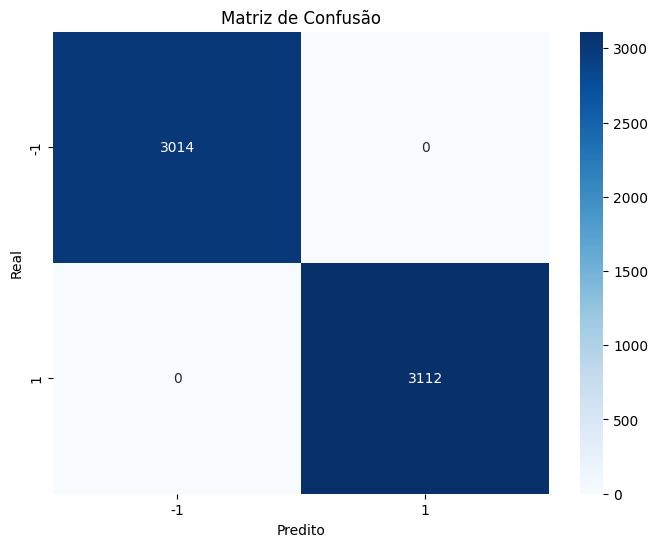

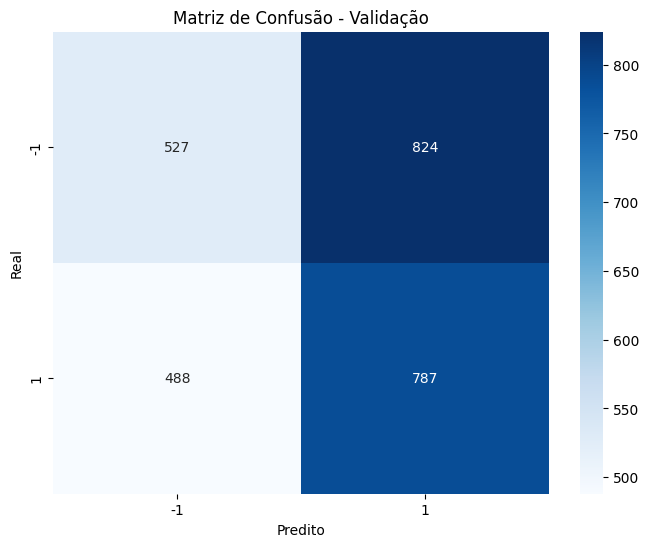

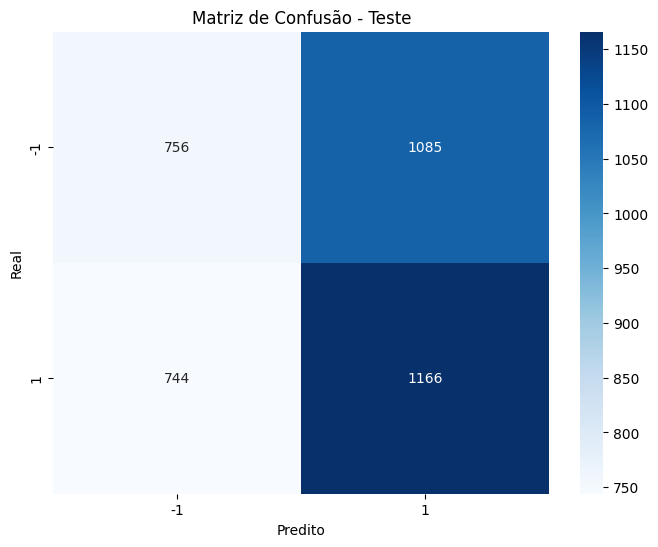

In [30]:
# 1) Seleciona features finais
X = X[selected_features].copy()

# Descobre o conjunto de classes na base inteira (ordem fixa)
classes = np.sort(y.unique())
n_classes = len(classes)

# 6. Treino/validação/teste clássico
model = lgb.LGBMClassifier(random_state=SEED, **best_params)

# Salvar índice original
X_index = X.index

# Split com os índices corretos preservados
X_train_full, X_test, y_train_full, y_test, idx_train_full, idx_test = train_test_split(
    X, y, X_index, test_size=0.30, shuffle=False
)

X_train, X_val, y_train, y_val, idx_train, idx_val = train_test_split(
    X_train_full, y_train_full, idx_train_full, test_size=0.30, shuffle=False
)



model.fit(X_train, y_train,
          eval_set=[(X_val, y_val)])

# --- salvar e recarregar, atribuindo a 'model' ---
MODEL_PATH = "/content/drive/MyDrive/Colab_Files/lightGBM.joblib"
dump(model, MODEL_PATH, compress=3)

# sobrescreve a variável 'model' com o pipeline recarregado do arquivo
model = load(MODEL_PATH)


# 7. Avaliar no conjunto de treino
y_pred_train = model.predict(X_train)
print("Acurácia no conjunto de treino:", accuracy_score(y_train, y_pred_train))
print(classification_report(y_train, y_pred_train))

# 8. Avaliar no conjunto de validação
y_pred_val = model.predict(X_val)
print("Acurácia no conjunto de validação:", accuracy_score(y_val, y_pred_val))
print(classification_report(y_val, y_pred_val))


# 9. Avaliar no conjunto de teste
y_pred = model.predict(X_test)
print("Acurácia no conjunto de teste:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


# Garante que classes é um array/lista de rótulos
labels = list(classes)  # ou model.classes_ se preferir

# 9. Plotar matriz de confusão do treino
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_train, y_pred_train, labels=labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[str(l) for l in labels],
            yticklabels=[str(l) for l in labels])
plt.title('Matriz de Confusão')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.show()

# 10. Plotar matriz de confusão do validação
cm_val = confusion_matrix(y_val, y_pred_val, labels=labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues',
            xticklabels=[str(l) for l in labels],
            yticklabels=[str(l) for l in labels])
plt.title('Matriz de Confusão - Validação')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.show()

# 11. Plotar matriz de confusão do teste
cm_test = confusion_matrix(y_test, y_pred, labels=labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues',
            xticklabels=[str(l) for l in labels],
            yticklabels=[str(l) for l in labels])
plt.title('Matriz de Confusão - Teste')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.show()

⚠️ Removendo 450 duplicatas de índice em X (keep='last')
⚠️ Removendo 450 duplicatas de índice em y (keep='last')
⚠️ Removendo 450 duplicatas de índice em DF_OHLC (keep='last')


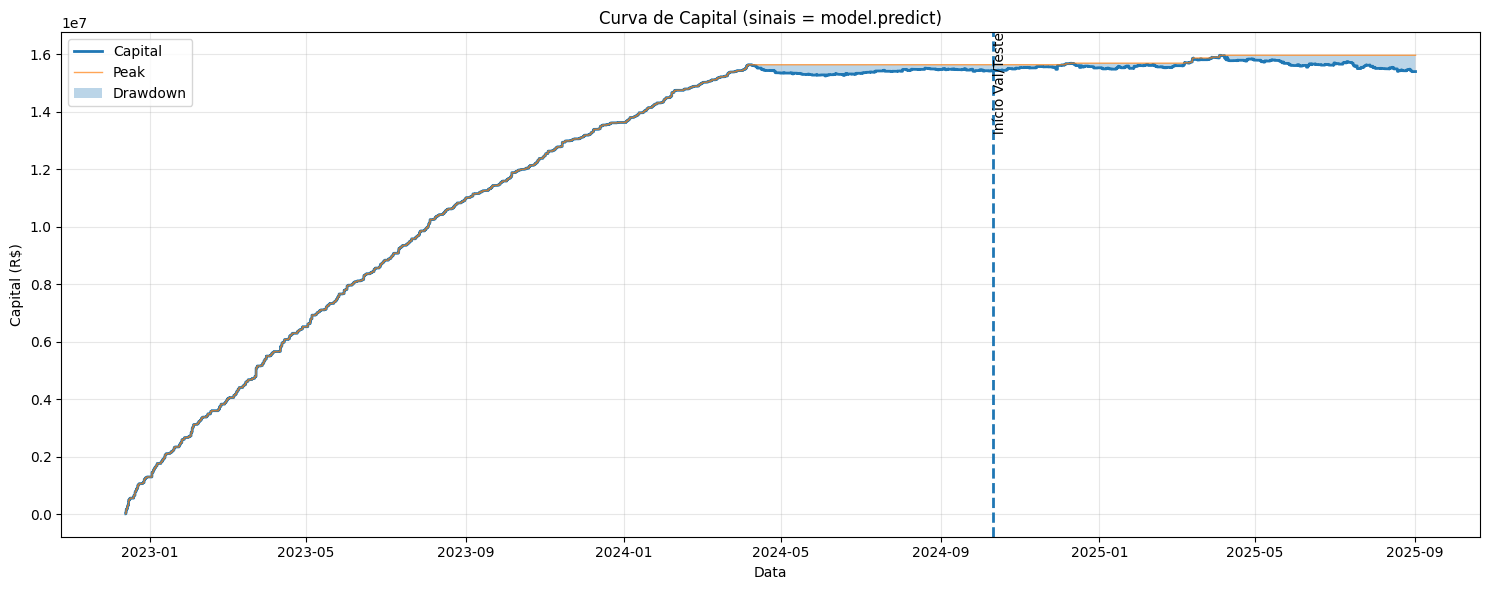

Trades: 10378 | Capital Final: R$ 15,392,005.95 | Retorno Total: 153820.06%
📈 Total de Trades (legs fechadas): 10378
✅ Trades Vencedores: 6783 (65.4%)
❌ Trades Perdedores: 3595
💰 Lucro Total: R$ 15,382,005.95
📊 Retorno Total: 153820.06%
📊 Lucro Médio por Trade: R$ 1,482.17
💚 Lucro Médio (Winners): R$ 2,980.06
💔 Perda Média (Losers): R$ -1,344.01
⚖️  Risk/Reward: 2.22
📈 Sharpe Ratio: 7.671
📉 Máximo Drawdown: R$ -570,137.90 (-3.6%)
🏁 Capital Inicial: R$ 10,000.00
🏁 Capital Final: R$ 15,392,005.95
⛔ Stop Diário (R$): 4,000.00
⛔ Dias com Stop Diário: 36


In [31]:
# =========================================================
# Parâmetros do Backtest
# =========================================================
VALOR_POR_PONTO  = 0.20
STOP_PONTOS      = 1500
SLIPPAGE         = 2
CUSTO_OPERACAO   = 0.0
CAPITAL_INICIAL  = 10000.0
HORA_FECHAMENTO  = dtime(18, 0)
NUM_CONTRATOS    = 25
MAX_PERDA_DIARIA = 4000.0
STOP_ANCHOR      = "entry"        # "entry" ou "signal_open"

# =========================================================
# 0) Carrega o modelo salvo (NÃO TREINA)
# =========================================================
MODEL_PATH = "/content/drive/MyDrive/Colab_Files/lightGBM.joblib"  # ajuste se necessário
model = load(MODEL_PATH)

# =========================================================
# Helpers de alinhamento e OHLC
# =========================================================
def ensure_ohlc(df_like: pd.DataFrame) -> pd.DataFrame:
    """
    Retorna um DF com colunas ['Date','Open','High','Low','Close'].
    Aceita nomes alternativos (PT/EN) e cria 'Date' a partir do índice se for DatetimeIndex.
    """
    tmp = df_like.copy()

    # 1) Garantir coluna Date
    if "Date" not in tmp.columns:
        if isinstance(tmp.index, pd.DatetimeIndex):
            tmp = tmp.reset_index()
            idx_name = tmp.columns[0]
            tmp = tmp.rename(columns={idx_name: "Date"})
        else:
            lower = {c.lower(): c for c in tmp.columns}
            for cand in ["date", "datetime", "timestamp", "data", "time"]:
                if cand in lower:
                    tmp = tmp.rename(columns={lower[cand]: "Date"})
                    break

    # 2) Mapear OHLC (case-insensitive)
    lower = {c.lower(): c for c in tmp.columns}
    def pick(*cands):
        for c in cands:
            if c in lower:
                return lower[c]
        return None

    ren = {}
    if "Open" not in tmp.columns:
        c = pick("open", "abertura", "o")
        if c: ren[c] = "Open"
    if "High" not in tmp.columns:
        c = pick("high", "max", "máxima", "maxima", "h")
        if c: ren[c] = "High"
    if "Low" not in tmp.columns:
        c = pick("low", "min", "mínima", "minima", "l")
        if c: ren[c] = "Low"
    if "Close" not in tmp.columns:
        c = pick("close", "fechamento", "c", "close_price", "price", "ultimo", "último")
        if c: ren[c] = "Close"

    if ren:
        tmp = tmp.rename(columns=ren)

    missing = [c for c in ["Date","Open","High","Low","Close"] if c not in tmp.columns]
    if missing:
        raise KeyError(
            f"Faltam colunas {missing}. Disponíveis: {list(df_like.columns)}. "
            "Se a data está no índice, este patch já faz reset_index automaticamente."
        )

    # 3) Tipos + validação
    tmp["Date"] = pd.to_datetime(tmp["Date"], errors="coerce")
    for c in ["Open","High","Low","Close"]:
        tmp[c] = pd.to_numeric(tmp[c], errors="coerce")
    if tmp[["Date","Open","High","Low","Close"]].isna().any().any():
        raise ValueError("NaNs encontrados em Date/Open/High/Low/Close após padronização.")

    return tmp[["Date","Open","High","Low","Close"]].copy()

def drop_dup_index(obj, keep="last", name="obj"):
    """
    Remove rótulos duplicados do índice (mantendo o último por padrão).
    Funciona para Series e DataFrames.
    """
    idx = obj.index
    if idx.has_duplicates:
        # mensagem opcional para depuração:
        print(f"⚠️ Removendo {idx.duplicated().sum()} duplicatas de índice em {name} (keep='{keep}')")
        return obj[~idx.duplicated(keep=keep)]
    return obj

def _tz_naive(idx: pd.Index) -> pd.Index:
    if isinstance(idx, pd.DatetimeIndex):
        return idx.tz_localize(None) if idx.tz is not None else idx
    return idx

def align_three(X_df: pd.DataFrame, y_s: pd.Series, ohlc_df: pd.DataFrame):
    """
    Alinha X, y e OHLC por:
      - interseção de índices (com normalização de timezone);
      - fallback posicional se não houver interseção mas os comprimentos forem iguais.
    Retorna X_al, y_al, D_al.
    """
    # normaliza timezone
    Xi = _tz_naive(X_df.index)
    yi = _tz_naive(y_s.index)
    Di = _tz_naive(ohlc_df.index)
    if not X_df.index.equals(Xi):   X_df = X_df.copy(); X_df.index = Xi
    if not y_s.index.equals(yi):    y_s  = y_s.copy();  y_s.index  = yi
    if not ohlc_df.index.equals(Di): ohlc_df = ohlc_df.copy(); ohlc_df.index = Di

    # remove duplicatas antes de intersectar
    X_df   = drop_dup_index(X_df, keep="last", name="X")
    y_s    = drop_dup_index(y_s,  keep="last", name="y")
    ohlc_df= drop_dup_index(ohlc_df, keep="last", name="DF_OHLC")

    inter = X_df.index.intersection(y_s.index).intersection(ohlc_df.index)

    # fallback posicional (mesmo tamanho, sem interseção)
    if len(inter) == 0 and (len(X_df) == len(y_s) == len(ohlc_df)):
        ohlc_df = ohlc_df.sort_values("Date").copy()
        X_df = X_df.sort_index()
        y_s = y_s.loc[X_df.index]
        ohlc_df.index = X_df.index
        inter = X_df.index

    if len(inter) == 0:
        raise RuntimeError(
            "Índices de X, y e DF_OHLC não se intersectam e o fallback posicional não pôde ser aplicado.\n"
            f"info: len(X)={len(X_df)}, len(y)={len(y_s)}, len(DF_OHLC)={len(ohlc_df)}\n"
            f"tipos de índice: X={type(X_df.index)}, y={type(y_s.index)}, OHLC={type(ohlc_df.index)}"
        )

    X_al = X_df.loc[inter]
    y_al = y_s.loc[inter]
    D_al = ohlc_df.loc[inter]
    return X_al, y_al, D_al

# =========================================================
# 1) PATCH OHLC a partir do seu 'df' de preços
#    -> se seu DF tem outro nome, troque 'df' por ele abaixo.
# =========================================================
base_prices = df.copy()                     # <<< troque se necessário
DF_OHLC     = ensure_ohlc(base_prices)

# =========================================================
# 2) Harmoniza features de X com o modelo
# =========================================================
feat_in = list(getattr(model, "feature_names_in_", []))
if feat_in:
    feature_cols = [c for c in feat_in if c in X.columns]
    if len(feature_cols) != len(feat_in):
        faltantes = [c for c in feat_in if c not in X.columns]
        print(f"⚠️ Aviso: features ausentes em X foram ignoradas: {faltantes}")
else:
    feature_cols = X.columns.tolist()

X_used = X[feature_cols].copy()
X_used = X_used.fillna(X_used.median(numeric_only=True))  # defesa contra NaN

# =========================================================
# 3) Alinha X, y, DF_OHLC (remove duplicatas e normaliza timezone)
# =========================================================
# Se X é DatetimeIndex, usar Date como índice para o OHLC facilita intersectar
if isinstance(X_used.index, pd.DatetimeIndex):
    DF_OHLC = DF_OHLC.set_index(pd.to_datetime(DF_OHLC["Date"]))

# y como Series (caso seja array)
if not isinstance(y, pd.Series):
    y = pd.Series(y, index=X_used.index)

X_used, y, DF_OHLC = align_three(X_used, y, DF_OHLC)

# =========================================================
# 4) Splits (sem embaralhar)
# =========================================================
X_index = X_used.index
X_train_full, X_test, y_train_full, y_test, idx_train_full, idx_test = train_test_split(
    X_used, y, X_index, test_size=0.20, shuffle=False
)
X_train, X_val, y_train, y_val, idx_train, idx_val = train_test_split(
    X_train_full, y_train_full, idx_train_full, test_size=0.20, shuffle=False
)

# =========================================================
# 5) PREVISÕES (modelo já carregado)
# =========================================================
yhat_train = pd.Series(model.predict(X_train), index=idx_train, name="pred")
yhat_val   = pd.Series(model.predict(X_val),   index=idx_val,   name="pred")
yhat_test  = pd.Series(model.predict(X_test),  index=idx_test,  name="pred")

# Concatena, ordena e REMOVE duplicatas no índice de previsões
yhat_all = pd.concat([yhat_train, yhat_val, yhat_test]).sort_index()
yhat_all = drop_dup_index(yhat_all.astype(int), keep="last", name="yhat_all")

# =========================================================
# 6) Monta DF do backtest com DF_OHLC já alinhado
# =========================================================
df_src_bt = DF_OHLC.loc[yhat_all.index].copy()

df_test = df_src_bt[["Date","Open","High","Low","Close"]].copy()
df_test["Date"] = pd.to_datetime(df_test["Date"])
df_test = df_test.sort_index()

# Garantir índice único em df_test também (por via das dúvidas)
df_test = drop_dup_index(df_test, keep="last", name="df_test")

df_test["date_only"] = df_test["Date"].dt.date
df_test["time_only"] = df_test["Date"].dt.time

# <<< AQUI ESTAVA O ERRO: use .loc com yhat_all já deduplicado >>>
df_test["prediction"] = yhat_all.loc[df_test.index].astype(int)

# Sinal válido no candle corrente = sinal do candle anterior
df_test["sig_prev"]  = df_test["prediction"].shift(1)
df_test["open_prev"] = df_test["Open"].shift(1)
df_test["is_last_candle_day"] = df_test["date_only"] != df_test["date_only"].shift(-1)

# Remove 1ª linha inválida pelo shift, mantendo índice original
df_test = df_test.dropna(subset=["sig_prev", "open_prev"]).copy()

# Marca OOS (val+test) pelos índices dos splits
oos_index = set(idx_val) | set(idx_test)
df_test["is_oos"] = df_test.index.isin(oos_index)
dt_oos_start = df_test.loc[df_test["is_oos"], "Date"].min() if df_test["is_oos"].any() else None

# =========================================================
# 7) Backtest
# =========================================================
capital = CAPITAL_INICIAL
legs = []
historico_trades = []
equity_curve = []
net_pos_vec = []
avg_entry_vec = []
closest_stop_vec = []

_leg_counter = 0
current_day = None
realized_pl_today = 0.0
halted_today = False

def apply_slippage(price, side, slippage_points):
    if slippage_points == 0: return price
    return price + (slippage_points if side == 1 else -slippage_points)

def trade_pl(exit_price, entry_price, side, contracts):
    pontos = (exit_price - entry_price) * side
    return pontos * VALOR_POR_PONTO * contracts

def net_side(legs):
    return 0 if len(legs) == 0 else legs[0]['side']

def avg_entry_price(legs):
    if not legs: return np.nan
    q = sum(l['qty'] for l in legs)
    return sum(l['entry'] * l['qty'] for l in legs) / q if q > 0 else np.nan

def closest_stop(legs):
    if not legs: return np.nan
    s = net_side(legs)
    stops = [l['stop'] for l in legs]
    if s == 1: return max(stops)
    if s == -1: return min(stops)
    return np.nan

def _calc_stop(sig, entry_px, oref):
    if STOP_ANCHOR == "entry":
        return entry_px - STOP_PONTOS if sig == 1 else entry_px + STOP_PONTOS
    elif STOP_ANCHOR == "signal_open":
        return oref - STOP_PONTOS if sig == 1 else oref + STOP_PONTOS
    else:
        raise ValueError("STOP_ANCHOR deve ser 'entry' ou 'signal_open'.")

def close_leg(leg, dt, exit_price, motivo):
    global capital, realized_pl_today, halted_today
    pl = trade_pl(exit_price, leg['entry'], leg['side'], leg['qty']) - CUSTO_OPERACAO
    capital += pl
    realized_pl_today += pl
    historico_trades.append({
        'data_entrada': leg['entry_time'],
        'data_saida': dt,
        'tipo': 'Compra' if leg['side'] == 1 else 'Venda',
        'contratos': leg['qty'],
        'preco_entrada': leg['entry'],
        'preco_saida': exit_price,
        'retorno_pontos': (exit_price - leg['entry']) * leg['side'],
        'pl': pl,
        'motivo_saida': motivo,
        'leg_id': leg['leg_id']
    })
    if realized_pl_today <= -MAX_PERDA_DIARIA:
        halted_today = True

for _, row in df_test.iterrows():
    dt   = row["Date"]
    d    = row["date_only"]
    t    = row["time_only"]
    o    = float(row["Open"])
    h    = float(row["High"])
    l    = float(row["Low"])
    c    = float(row["Close"])

    # Virada de dia reseta o stop diário
    if (current_day is None) or (d != current_day):
        current_day = d
        realized_pl_today = 0.0
        halted_today = False

    sig  = int(row["sig_prev"])    # {-1,0,1}
    oref = float(row["open_prev"]) # abertura do candle do sinal

    # 1) Flatten/Reverse no open
    if legs and (sig == 0 or (sig in (1, -1) and sig != net_side(legs))):
        exit_price_all = apply_slippage(o, -net_side(legs), SLIPPAGE)
        for leg in list(legs):
            close_leg(leg, dt, exit_price_all, "Flatten/Reverse no Open")
        legs.clear()

        if (not halted_today) and (sig in (1, -1)) and (NUM_CONTRATOS > 0):
            _leg_counter += 1
            entry_px = apply_slippage(o, sig, SLIPPAGE)
            stop_px  = _calc_stop(sig, entry_px, oref)
            legs.append({
                'side': sig, 'qty': NUM_CONTRATOS, 'entry': entry_px, 'entry_time': dt,
                'stop': stop_px, 'ref_open': oref, 'leg_id': _leg_counter
            })

    # 2) Abertura/Empilhamento
    elif (not halted_today) and (sig in (1, -1)) and NUM_CONTRATOS > 0:
        if (not legs) or (sig == net_side(legs)):
            _leg_counter += 1
            entry_px = apply_slippage(o, sig, SLIPPAGE)
            stop_px  = _calc_stop(sig, entry_px, oref)
            legs.append({
                'side': sig, 'qty': NUM_CONTRATOS, 'entry': entry_px, 'entry_time': dt,
                'stop': stop_px, 'ref_open': oref, 'leg_id': _leg_counter
            })

    # 3) Stops intrabar
    if legs:
        s = net_side(legs)
        if s == 1:
            triggered = [leg for leg in legs if l <= leg['stop']]
            for leg in list(triggered):
                exit_px = apply_slippage(leg['stop'], -leg['side'], SLIPPAGE)
                close_leg(leg, dt, exit_px, "Stop")
                legs.remove(leg)
        else:
            triggered = [leg for leg in legs if h >= leg['stop']]
            for leg in list(triggered):
                exit_px = apply_slippage(leg['stop'], -leg['side'], SLIPPAGE)
                close_leg(leg, dt, exit_px, "Stop")
                legs.remove(leg)

    # 4) Stop Diário
    if legs and halted_today:
        s = net_side(legs)
        exit_px_stopdia = apply_slippage(c, -s, SLIPPAGE)
        for leg in list(legs):
            close_leg(leg, dt, exit_px_stopdia, "Stop Diário (flatten)")
            legs.remove(leg)

    # 5) Fechamento obrigatório do dia
    if legs and (t >= HORA_FECHAMENTO or row["is_last_candle_day"]):
        s = net_side(legs)
        exit_px_day = apply_slippage(c, -s, SLIPPAGE)
        for leg in list(legs):
            close_leg(leg, dt, exit_px_day, "Fechamento Daytrade")
            legs.remove(leg)

    # Séries
    equity_curve.append(capital)
    net_pos_vec.append(net_side(legs))
    avg_entry_vec.append(avg_entry_price(legs))
    closest_stop_vec.append(closest_stop(legs))

# Fecha o que sobrou no fim
if legs:
    last_close = float(df_test.iloc[-1]["Close"])
    last_dt    = df_test.iloc[-1]["Date"]
    s = net_side(legs)
    exit_px_final = apply_slippage(last_close, -s, SLIPPAGE)
    for leg in list(legs):
        close_leg(leg, last_dt, exit_px_final, "Fechamento Série")
        legs.remove(leg)

# =========================================================
# 8) Resultados + Curva de Capital com linha vertical OOS
# =========================================================
df_test["capital"] = equity_curve
df_test["posicao"] = net_pos_vec
df_test["preco_entrada_media"] = avg_entry_vec
df_test["stop_mais_proximo"] = closest_stop_vec

df_test["peak"] = df_test["capital"].cummax()
df_test["drawdown"] = df_test["capital"] - df_test["peak"]

plt.figure(figsize=(15, 6))
ax = plt.gca()
ax.plot(df_test["Date"], df_test["capital"], label="Capital", linewidth=2)
ax.plot(df_test["Date"], df_test["peak"], label="Peak", linewidth=1, alpha=0.7)
ax.fill_between(df_test["Date"], df_test["peak"], df_test["capital"],
                where=(df_test["capital"] < df_test["peak"]),
                alpha=0.3, label='Drawdown')
if dt_oos_start is not None:
    ax.axvline(pd.to_datetime(dt_oos_start), linestyle="--", linewidth=2)
    ax.text(pd.to_datetime(dt_oos_start), ax.get_ylim()[1],
            "  Início Val/Teste", rotation=90, va='top', ha='left')
ax.set_title("Curva de Capital (sinais = model.predict)")
ax.set_xlabel("Data"); ax.set_ylabel("Capital (R$)")
ax.grid(True, alpha=0.3); ax.legend()
plt.tight_layout()
plt.show()

# Sumário simples
total_trades = len(pd.DataFrame(historico_trades))
capital_final = df_test["capital"].iloc[-1]
retorno_total = ((capital_final - CAPITAL_INICIAL) / CAPITAL_INICIAL) * 100.0
print(f"Trades: {total_trades} | Capital Final: R$ {capital_final:,.2f} | Retorno Total: {retorno_total:.2f}%")

# (Opcional) DF de sinais para inspecionar/guardar
df_signals = df_test[["Date","prediction","sig_prev","Open","High","Low","Close"]].copy()

# =========================================================
# 9) Métricas detalhadas + prints "executivo"
# =========================================================
df_historico = pd.DataFrame(historico_trades)

if not df_historico.empty:
    total_trades = int(len(df_historico))
    trades_vencedores = int((df_historico['pl'] > 0).sum())
    trades_perdedores = int((df_historico['pl'] <= 0).sum())
    win_rate = (trades_vencedores / total_trades * 100.0) if total_trades > 0 else 0.0

    total_pl = float(df_historico['pl'].sum())
    mean_pl  = float(df_historico['pl'].mean())
    std_pl   = float(df_historico['pl'].std(ddof=1)) if total_trades > 1 else 0.0

    lucro_medio = float(df_historico.loc[df_historico['pl'] > 0, 'pl'].mean()) if trades_vencedores > 0 else 0.0
    perda_media = float(df_historico.loc[df_historico['pl'] <= 0, 'pl'].mean()) if trades_perdedores > 0 else 0.0
    risk_reward = (abs(lucro_medio / perda_media) if perda_media < 0 else np.nan)

    sharpe = (mean_pl / std_pl * np.sqrt(252)) if (std_pl and std_pl > 0) else np.nan

    # drawdown já foi calculado acima; se quiser garantir:
    if "peak" not in df_test.columns:
        df_test["peak"] = df_test["capital"].cummax()
    if "drawdown" not in df_test.columns:
        df_test["drawdown"] = df_test["capital"] - df_test["peak"]

    max_dd = float(df_test["drawdown"].min())
    peak_max = float(df_test["peak"].max()) if len(df_test) else np.nan
    max_dd_pct = (max_dd / peak_max * 100.0) if peak_max and not np.isnan(peak_max) else np.nan

    capital_inicial = float(CAPITAL_INICIAL)
    capital_final   = float(df_test["capital"].iloc[-1]) if len(df_test) else capital_inicial
    retorno_total   = ((capital_final - capital_inicial) / capital_inicial) * 100.0 if capital_inicial else np.nan

    # Dias com Stop Diário (usa 'motivo_saida' do histórico)
    mask_stop = df_historico['motivo_saida'].astype(str).str.contains('Stop Diário', na=False)
    dias_stop_diario = pd.to_datetime(df_historico.loc[mask_stop, 'data_saida']).dt.date.nunique()

    # ======= PRINTS REQUERIDOS =======
    print(f"📈 Total de Trades (legs fechadas): {total_trades}")
    print(f"✅ Trades Vencedores: {trades_vencedores} ({win_rate:.1f}%)")
    print(f"❌ Trades Perdedores: {trades_perdedores}")
    print(f"💰 Lucro Total: R$ {total_pl:,.2f}")
    print(f"📊 Retorno Total: {retorno_total:.2f}%")
    print(f"📊 Lucro Médio por Trade: R$ {mean_pl:,.2f}")
    print(f"💚 Lucro Médio (Winners): R$ {lucro_medio:,.2f}")
    print(f"💔 Perda Média (Losers): R$ {perda_media:,.2f}")
    print(f"⚖️  Risk/Reward: {risk_reward:.2f}")
    print(f"📈 Sharpe Ratio: {sharpe:.3f}")
    print(f"📉 Máximo Drawdown: R$ {max_dd:,.2f} ({max_dd_pct:.1f}%)")
    print(f"🏁 Capital Inicial: R$ {capital_inicial:,.2f}")
    print(f"🏁 Capital Final: R$ {capital_final:,.2f}")
    print(f"⛔ Stop Diário (R$): {MAX_PERDA_DIARIA:,.2f}")
    print(f"⛔ Dias com Stop Diário: {dias_stop_diario}")

else:
    # Sem trades: ainda assim imprimimos um resumo consistente
    capital_inicial = float(CAPITAL_INICIAL)
    capital_final   = float(df_test["capital"].iloc[-1]) if len(df_test) else capital_inicial
    retorno_total   = ((capital_final - capital_inicial) / capital_inicial) * 100.0 if capital_inicial else np.nan

    # drawdown/peak (se não existirem)
    if "peak" not in df_test.columns:
        df_test["peak"] = df_test["capital"].cummax()
    if "drawdown" not in df_test.columns:
        df_test["drawdown"] = df_test["capital"] - df_test["peak"]

    max_dd = float(df_test["drawdown"].min())
    peak_max = float(df_test["peak"].max()) if len(df_test) else np.nan
    max_dd_pct = (max_dd / peak_max * 100.0) if peak_max and not np.isnan(peak_max) else np.nan

    print("⚠️ Nenhum trade foi executado no período de backtest.")
    print(f"🏁 Capital Inicial: R$ {capital_inicial:,.2f}")
    print(f"🏁 Capital Final: R$ {capital_final:,.2f}")
    print(f"📊 Retorno Total: {retorno_total:.2f}%")
    print(f"📉 Máximo Drawdown: R$ {max_dd:,.2f} ({max_dd_pct:.1f}%)")



In [33]:
df_light2 = df.copy()
y = df_light2["target"]
X = df_light2.drop(columns=["target", "Open", "High", "Low", "Close", "returns"])

# ============================
# Imports
# ============================
import numpy as np
import pandas as pd
import optuna
import lightgbm as lgb
from sklearn.metrics import f1_score
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

# (Opcional) fallback simples para o seu validador, caso não esteja importado no ambiente
try:
    PurgedKFoldEmbargo
except NameError:
    try:
        from sklearn.model_selection import TimeSeriesSplit as PurgedKFoldEmbargo
    except Exception:
        pass

# ============================
# Configs CONSISTENTES (um único lugar p/ alterar)
# ============================
try:
    SEED
except NameError:
    SEED = 42

PLATEAU_PATIENCE    = 10      # mesmo usado no make_plateau_stopper
ES_MIN_DELTA        = 1e-4
ES_ROUNDS_MAIN      = 10      # early stopping nos fits do objective (train/val)
ES_ROUNDS_STABLE    = 10      # early stopping na seleção estável

# >>> Preferência por MENOS features
FEATURE_GROWTH_REL   = 0.25   # aumento relativo permitido (25%)
FEATURE_GROWTH_ABS   = 10     # aumento absoluto permitido (10 features)
FEATURE_MIN_IMPROVE  = 0.005  # ganho mínimo de F1 exigido p/ aceitar aumento grande de top_k
FEATURE_TIE_EPS      = 1e-6   # margem para considerar empate técnico de F1
FEATURE_TIE_BONUS    = 1e-6   # bônus minúsculo para preferir menos features em empate

# ============================
# Sanitização
# ============================
def sanitize_df_numeric(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    for c in df.columns:
        if df[c].dtype == "object":
            df[c] = pd.to_numeric(df[c], errors="coerce")
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    return df

# Garanta tipos limpos
X = sanitize_df_numeric(X)
y = pd.Series(y).astype("int64")

# ============================
# Util: seleção top-k via SHAP nativo (no TREINO)
# ============================
def topk_by_shap_from_training(model: lgb.LGBMClassifier, X_train: pd.DataFrame):
    """
    Retorna (order, per_feature_shap):
      - order: índices das features ordenados (desc) por |SHAP| médio
      - per_feature_shap: vetor (n_features,) com a importância média (|SHAP|)
    Funciona para binário e multiclasse.
    """
    contribs = model.predict(X_train, pred_contrib=True)  # numpy-like
    contribs = np.asarray(contribs)
    n, m = contribs.shape
    p = X_train.shape[1]

    classes = getattr(model, "classes_", None)
    n_class = len(classes) if classes is not None else None

    if m == p + 1:
        # binário: (p + 1) incluindo bias
        per_feature = np.mean(np.abs(contribs[:, :p]), axis=0)
    else:
        # multiclasse: n_class * (p + 1)
        if n_class is None:
            n_class = int(round(m / (p + 1)))
        expected = n_class * (p + 1)
        if expected != m:
            raise ValueError(
                f"pred_contrib shape mismatch: got {m}, expected {expected} = n_class({n_class})*(p+1). "
                "Verifique se objetivo é multiclass e se p/n_classes estão corretos."
            )
        contribs = contribs.reshape(n, n_class, p + 1)
        per_feature = np.mean(np.abs(contribs[:, :, :p]), axis=(0, 1))

    per_feature = np.nan_to_num(per_feature, nan=0.0, posinf=0.0, neginf=0.0)
    order = np.argsort(per_feature)[::-1]
    return order, per_feature

# ============================
# Objetivo conjunto (seleção + tunagem) — com favorecimento a MENOS features
# ============================
def objective_joint(trial: optuna.trial.Trial, X: pd.DataFrame, y: pd.Series, cv) -> float:
    # Nº de classes no DATASET COMPLETO (para definir objetivo/num_class)
    classes_all = np.array(sorted(np.unique(y)))
    n_classes_total = int(classes_all.size)
    if n_classes_total < 2:
        raise ValueError("O dataset inteiro tem menos de 2 classes — não é possível treinar classificação.")

    base_objective = "binary" if n_classes_total == 2 else "multiclass"
    base_metric    = "binary_logloss" if n_classes_total == 2 else "multi_logloss"

    # Espaço de busca (sem early_stopping_rounds; usamos callback)
    params = {
        "objective": base_objective,
        "metric": base_metric,
        "verbosity": -1,
        "boosting_type": trial.suggest_categorical("boosting_type", ["gbdt", "dart"]),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.05),
        "num_leaves": trial.suggest_int("num_leaves", 16, 255),
        "max_depth": trial.suggest_int("max_depth", 3, 7),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.6, 1.0),
        "feature_fraction_bynode": trial.suggest_float("feature_fraction_bynode", 0.6, 1.0),
        # Se sua versão do LightGBM não suportar 'data_sample_strategy', remova a linha abaixo:
        "data_sample_strategy": trial.suggest_categorical("data_sample_strategy", ["bagging", "goss"]),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 30),
        "min_sum_hessian_in_leaf": trial.suggest_float("min_sum_hessian_in_leaf", 1e-4, 1e-1, log=True),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0.05, 0.1),
        "max_bin": trial.suggest_int("max_bin", 128, 555),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.5, 5.0),
        "n_estimators": trial.suggest_int("n_estimators", 600, 2500),
        "extra_trees": trial.suggest_categorical("extra_trees", [True, False]),
        "n_jobs": -1,
        "force_col_wise": True
    }
    if base_objective == "multiclass":
        params["num_class"] = n_classes_total

    # top-k para seleção por SHAP
    n_feats = X.shape[1]
    k_hi = max(10, min(n_feats, n_feats // 2 if n_feats >= 20 else n_feats))
    top_k = trial.suggest_int("top_k", 10, k_hi)

    f1_scores = []
    used_folds = 0

    for fold, (tr_idx, va_idx) in enumerate(cv.split(X, y), start=1):
        Xtr, Xva = X.iloc[tr_idx], X.iloc[va_idx]
        ytr, yva = y.iloc[tr_idx], y.iloc[va_idx]

        # --- GUARDA: precisa de pelo menos 2 classes no TREINO ---
        if ytr.nunique() < 2:
            continue

        # 1) Treino full-features (para SHAP)
        model_full = lgb.LGBMClassifier(**params, random_state=SEED + 1000 + fold)
        model_full.fit(
            Xtr, ytr,
            eval_set=[(Xva, yva)],
            eval_metric=base_metric,
            callbacks=[lgb.early_stopping(ES_ROUNDS_MAIN, verbose=False)]
        )

        # 2) Seleção top-k (no treino)
        order, _ = topk_by_shap_from_training(model_full, Xtr)
        k_eff = int(min(top_k, n_feats))
        sel_cols = X.columns[order[:k_eff]]

        # 3) Re-treina no subconjunto e avalia
        model_sel = lgb.LGBMClassifier(**params, random_state=SEED + 2000 + fold)
        model_sel.fit(
            Xtr[sel_cols], ytr,
            eval_set=[(Xva[sel_cols], yva)],
            eval_metric=base_metric,
            callbacks=[lgb.early_stopping(ES_ROUNDS_MAIN, verbose=False)]
        )

        preds = model_sel.predict(Xva[sel_cols])
        f1 = f1_score(yva, preds, average="macro")
        f1_scores.append(f1)
        used_folds += 1

        mean_so_far = float(np.mean(f1_scores))
        trial.report(mean_so_far, step=fold)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    if used_folds == 0:
        raise optuna.exceptions.TrialPruned()

    f1_mean = float(np.mean(f1_scores))

    # ============================
    # >>> Gate de features:
    # Bloqueia avanço se top_k crescer "muito" x melhor atual sem melhora mínima de F1
    # ============================
    # Lê melhor atual (se houver)
    best_val = None
    best_k   = None
    try:
        if len(trial.study.best_trials) > 0:
            best_val = trial.study.best_value
            # também tentamos ler do user_attrs (rastreamento robusto)
            best_k = trial.study.user_attrs.get("best_top_k", None)
            if best_k is None:
                best_k = trial.study.best_trial.params.get("top_k", None)
    except Exception:
        pass

    if (best_val is not None) and (best_k is not None):
        # crescimento significativo?
        growth_abs = top_k - int(best_k)
        growth_rel = growth_abs / max(1, int(best_k))
        big_growth = (growth_abs > FEATURE_GROWTH_ABS) or (growth_rel > FEATURE_GROWTH_REL)

        # se cresceu muito e NÃO melhorou o suficiente, derruba o score para não ser best
        if big_growth and (f1_mean < best_val + FEATURE_MIN_IMPROVE):
            # penalização forte garante que não supera o best atual
            return f1_mean - 1.0  # desloca bem abaixo

        # desempate a favor de MENOS features quando F1 empata
        if abs(f1_mean - best_val) <= FEATURE_TIE_EPS and top_k < int(best_k):
            # um bônus minúsculo para vencer o empate
            return f1_mean + FEATURE_TIE_BONUS

    return f1_mean

# ============================
# Callback de plateau (conta APENAS trials COMPLETOS)
# ============================
def make_plateau_stopper(patience=PLATEAU_PATIENCE, min_delta=ES_MIN_DELTA):
    state = {"best": -np.inf, "bad": 0}
    def _cb(study: optuna.Study, trial: optuna.trial.FrozenTrial):
        if trial.state != optuna.trial.TrialState.COMPLETE:
            return
        val = trial.value
        if val is None:
            return
        if val > state["best"] + min_delta:
            state["best"] = val
            state["bad"] = 0
        else:
            state["bad"] += 1
            if state["bad"] >= patience:
                study.stop()
    return _cb

# ============================
# Callback de rastreamento do melhor top_k
# ============================
def feature_tracking_callback(study: optuna.Study, trial: optuna.trial.FrozenTrial):
    """Mantém user_attrs atualizados com o top_k do melhor trial vigente."""
    if trial.state != optuna.trial.TrialState.COMPLETE:
        return
    try:
        if study.best_trial.number == trial.number:
            k = trial.params.get("top_k", None)
            if k is not None:
                study.set_user_attr("best_top_k", int(k))
            study.set_user_attr("best_value", float(trial.value) if trial.value is not None else None)
    except Exception:
        pass

# ============================
# Seleção FINAL estável (com melhores params+top_k)
# ============================
def stable_selected_features(
    X: pd.DataFrame,
    y: pd.Series,
    cv,
    best_params: dict,
    top_k: int,
    presence_threshold: float = 0.6
) -> list:
    counts = {c: 0 for c in X.columns}
    n_feats = X.shape[1]
    k_eff = int(min(top_k, n_feats))

    for fold, (tr_idx, va_idx) in enumerate(cv.split(X, y), start=1):
        Xtr, ytr = X.iloc[tr_idx], y.iloc[tr_idx]

        # Treina full para medir SHAP no treino
        model_full = lgb.LGBMClassifier(**best_params, random_state=SEED + 3000 + fold)
        model_full.fit(
            Xtr, ytr,
            eval_set=[(Xtr, ytr)],
            eval_metric="multi_logloss" if best_params.get("objective", "") == "multiclass" else "binary_logloss",
            callbacks=[lgb.early_stopping(ES_ROUNDS_STABLE, verbose=False)]
        )
        order, _ = topk_by_shap_from_training(model_full, Xtr)
        for c in X.columns[order[:k_eff]]:
            counts[c] += 1

    need = int(np.ceil(presence_threshold * len(list(cv.split(X, y)))))
    selected = [c for c, cnt in counts.items() if cnt >= need]

    if len(selected) < k_eff:
        acc = []
        for fold, (tr_idx, va_idx) in enumerate(cv.split(X, y), start=1):
            Xtr, ytr = X.iloc[tr_idx], y.iloc[tr_idx]
            model_full = lgb.LGBMClassifier(**best_params, random_state=SEED + 4000 + fold)
            model_full.fit(
                Xtr, ytr,
                eval_set=[(Xtr, ytr)],
                eval_metric="multi_logloss" if best_params.get("objective", "") == "multiclass" else "binary_logloss",
                callbacks=[lgb.early_stopping(ES_ROUNDS_STABLE, verbose=False)]
            )
            _, abs_shap_f = topk_by_shap_from_training(model_full, Xtr)
            acc.append(abs_shap_f)
        med = np.median(np.vstack(acc), axis=0)
        pool = [c for c in X.columns if c not in selected]
        order_pool = np.argsort(med[[X.columns.get_loc(c) for c in pool]])[::-1]
        selected += [pool[i] for i in order_pool[:(k_eff - len(selected))]]

    return selected

# ============================
# Validador temporal (seu KFold com embargo)
# ============================
split = 10
emb = 4  # pode ser int (amostras) ou float (fração), p.ex. 0.02
tscv = PurgedKFoldEmbargo(n_splits=split, embargo=emb)  # <- sua classe; fallback usa TSSplit sem embargo

# ============================
# Optuna com PRUNER + PLATEAU + rastreador de features
# ============================
pruner  = optuna.pruners.MedianPruner(n_warmup_steps=2)
sampler = optuna.samplers.TPESampler(seed=SEED)
study   = optuna.create_study(direction="maximize", sampler=sampler, pruner=pruner)

plateau_cb = make_plateau_stopper(patience=PLATEAU_PATIENCE, min_delta=ES_MIN_DELTA)

n_trials = 20
study.optimize(
    lambda tr: objective_joint(tr, X, y, tscv),
    n_trials=n_trials,
    callbacks=[plateau_cb, feature_tracking_callback]  # <- mantém best_top_k atualizado
)

print("Melhores parâmetros + top_k:")
print(study.best_params)

# ============================
# Seleção FINAL estável e treino FINAL (exemplo)
# ============================
best_params = {k: v for k, v in study.best_params.items() if k not in ("top_k",)}
best_params.update({
    "objective": "multiclass" if len(np.unique(y)) > 2 else "binary",
    "metric": "multi_logloss" if len(np.unique(y)) > 2 else "binary_logloss",
    "verbosity": -1,
    "boosting_type": best_params.get("boosting_type", "gbdt"),
    "n_jobs": -1,
    "force_col_wise": True
})
best_top_k = int(study.best_params["top_k"])

selected_features = stable_selected_features(
    X, y, tscv, best_params, best_top_k, presence_threshold=0.6
)
print(f"Features finais selecionadas ({len(selected_features)}):")
print(selected_features)

# Exemplo de treino final (opcional)
'''
X_sel = X[selected_features].copy()
final_model = lgb.LGBMClassifier(**best_params, random_state=SEED + 5000)
final_model.fit(
    X_sel, y,
    eval_set=[(X_sel, y)],
    eval_metric=best_params["metric"],
    callbacks=[lgb.early_stopping(ES_ROUNDS_STABLE, verbose=False)]
)
'''



[I 2025-09-28 20:53:37,964] A new study created in memory with name: no-name-494363c2-69f5-435f-82f7-8722c737c41a
[I 2025-09-28 20:54:41,081] Trial 0 finished with value: 0.5124197229946905 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.03927975767245621, 'num_leaves': 159, 'max_depth': 3, 'feature_fraction': 0.662397808134481, 'feature_fraction_bynode': 0.6232334448672797, 'data_sample_strategy': 'bagging', 'min_child_samples': 23, 'min_sum_hessian_in_leaf': 0.00011527987128232407, 'min_gain_to_split': 0.09849549260809973, 'max_bin': 484, 'reg_alpha': 0.21233911067827616, 'reg_lambda': 1.318212352431953, 'n_estimators': 948, 'extra_trees': False, 'top_k': 64}. Best is trial 0 with value: 0.5124197229946905.
[I 2025-09-28 20:58:34,427] Trial 1 finished with value: 0.5075958806273021 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.015579754426081675, 'num_leaves': 86, 'max_depth': 4, 'feature_fraction': 0.7824279936868144, 'feature_fraction_bynode': 0.91407038

Melhores parâmetros + top_k:
{'boosting_type': 'dart', 'learning_rate': 0.04214688307596458, 'num_leaves': 60, 'max_depth': 7, 'feature_fraction': 0.8157368967662603, 'feature_fraction_bynode': 0.922976062065625, 'data_sample_strategy': 'bagging', 'min_child_samples': 7, 'min_sum_hessian_in_leaf': 0.00048284249748183273, 'min_gain_to_split': 0.07135538943131282, 'max_bin': 478, 'reg_alpha': 0.8607305832563434, 'reg_lambda': 0.5312845873903582, 'n_estimators': 1570, 'extra_trees': True, 'top_k': 25}
Features finais selecionadas (25):
['RSL5', 'GK_VOL', 'realized_vol', 'GK_VOL_lag_1', 'realized_vol_lag_1', 'RSL5_lag_1', 'ret_lag_2', 'ret_lag_3', 'RSL5_lag_5', 'RSL10_lag_8', 'ret_lag_11', 'GK_VOL_lag_12', 'ATR_lag_14', 'ATR_lag_15', 'ATR_lag_16', 'ret_lag_17', 'realized_vol_lag_18', 'ATR_lag_19', 'realized_vol_lag_20', 'realized_vol_lag_5', 'ATR_lag_20', 'ret_lag_9', 'PKS_VOL_lag_10', 'RSI10_lag_15', 'GK_VOL_lag_11']


'\nX_sel = X[selected_features].copy()\nfinal_model = lgb.LGBMClassifier(**best_params, random_state=SEED + 5000)\nfinal_model.fit(\n    X_sel, y,\n    eval_set=[(X_sel, y)],\n    eval_metric=best_params["metric"],\n    callbacks=[lgb.early_stopping(ES_ROUNDS_STABLE, verbose=False)]\n)\n'

Acurácia no conjunto de treino: 0.7360430950048972
              precision    recall  f1-score   support

          -1       0.74      0.72      0.73      3014
           1       0.74      0.75      0.74      3112

    accuracy                           0.74      6126
   macro avg       0.74      0.74      0.74      6126
weighted avg       0.74      0.74      0.74      6126

Acurácia no conjunto de validação: 0.5304645849200305
              precision    recall  f1-score   support

          -1       0.55      0.51      0.53      1351
           1       0.52      0.55      0.53      1275

    accuracy                           0.53      2626
   macro avg       0.53      0.53      0.53      2626
weighted avg       0.53      0.53      0.53      2626

Acurácia no conjunto de teste: 0.5171954145561184
              precision    recall  f1-score   support

          -1       0.51      0.63      0.56      1841
           1       0.53      0.41      0.46      1910

    accuracy               

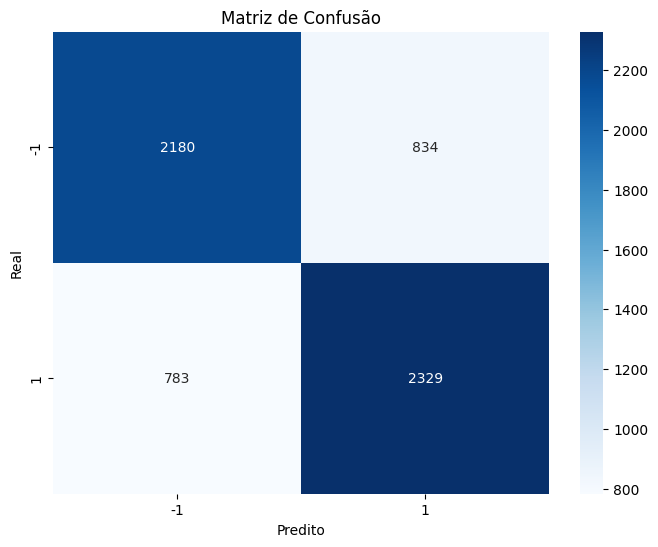

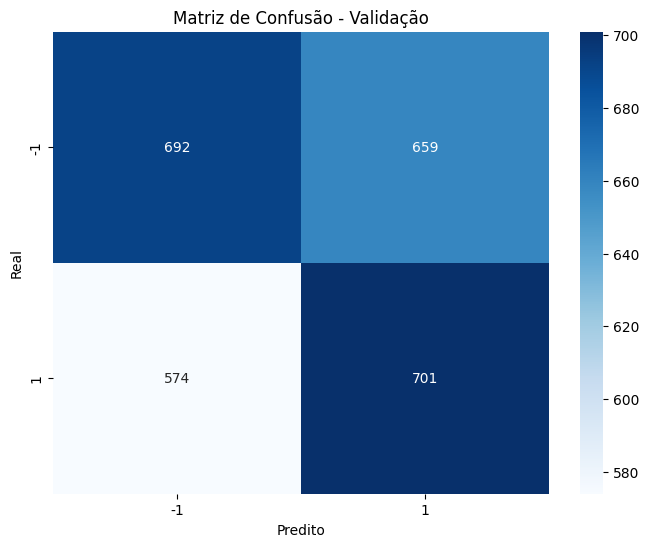

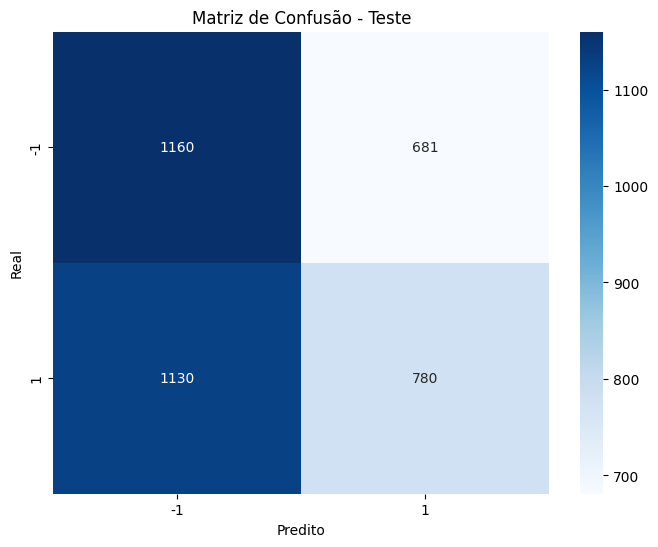

In [34]:
# 1) Seleciona features finais
X = X[selected_features].copy()

# Descobre o conjunto de classes na base inteira (ordem fixa)
classes = np.sort(y.unique())
n_classes = len(classes)

# 6. Treino/validação/teste clássico
model = lgb.LGBMClassifier(random_state=SEED, **best_params)

# Salvar índice original
X_index = X.index

# Split com os índices corretos preservados
X_train_full, X_test, y_train_full, y_test, idx_train_full, idx_test = train_test_split(
    X, y, X_index, test_size=0.30, shuffle=False
)

X_train, X_val, y_train, y_val, idx_train, idx_val = train_test_split(
    X_train_full, y_train_full, idx_train_full, test_size=0.30, shuffle=False
)



model.fit(X_train, y_train,
          eval_set=[(X_val, y_val)])

# --- salvar e recarregar, atribuindo a 'model' ---
MODEL_PATH = "/content/drive/MyDrive/Colab_Files/lightGBM.joblib"
dump(model, MODEL_PATH, compress=3)

# sobrescreve a variável 'model' com o pipeline recarregado do arquivo
model = load(MODEL_PATH)


# 7. Avaliar no conjunto de treino
y_pred_train = model.predict(X_train)
print("Acurácia no conjunto de treino:", accuracy_score(y_train, y_pred_train))
print(classification_report(y_train, y_pred_train))

# 8. Avaliar no conjunto de validação
y_pred_val = model.predict(X_val)
print("Acurácia no conjunto de validação:", accuracy_score(y_val, y_pred_val))
print(classification_report(y_val, y_pred_val))


# 9. Avaliar no conjunto de teste
y_pred = model.predict(X_test)
print("Acurácia no conjunto de teste:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


# Garante que classes é um array/lista de rótulos
labels = list(classes)  # ou model.classes_ se preferir

# 9. Plotar matriz de confusão do treino
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_train, y_pred_train, labels=labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[str(l) for l in labels],
            yticklabels=[str(l) for l in labels])
plt.title('Matriz de Confusão')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.show()

# 10. Plotar matriz de confusão do validação
cm_val = confusion_matrix(y_val, y_pred_val, labels=labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues',
            xticklabels=[str(l) for l in labels],
            yticklabels=[str(l) for l in labels])
plt.title('Matriz de Confusão - Validação')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.show()

# 11. Plotar matriz de confusão do teste
cm_test = confusion_matrix(y_test, y_pred, labels=labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues',
            xticklabels=[str(l) for l in labels],
            yticklabels=[str(l) for l in labels])
plt.title('Matriz de Confusão - Teste')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.show()

⚠️ Removendo 450 duplicatas de índice em X (keep='last')
⚠️ Removendo 450 duplicatas de índice em y (keep='last')
⚠️ Removendo 450 duplicatas de índice em DF_OHLC (keep='last')


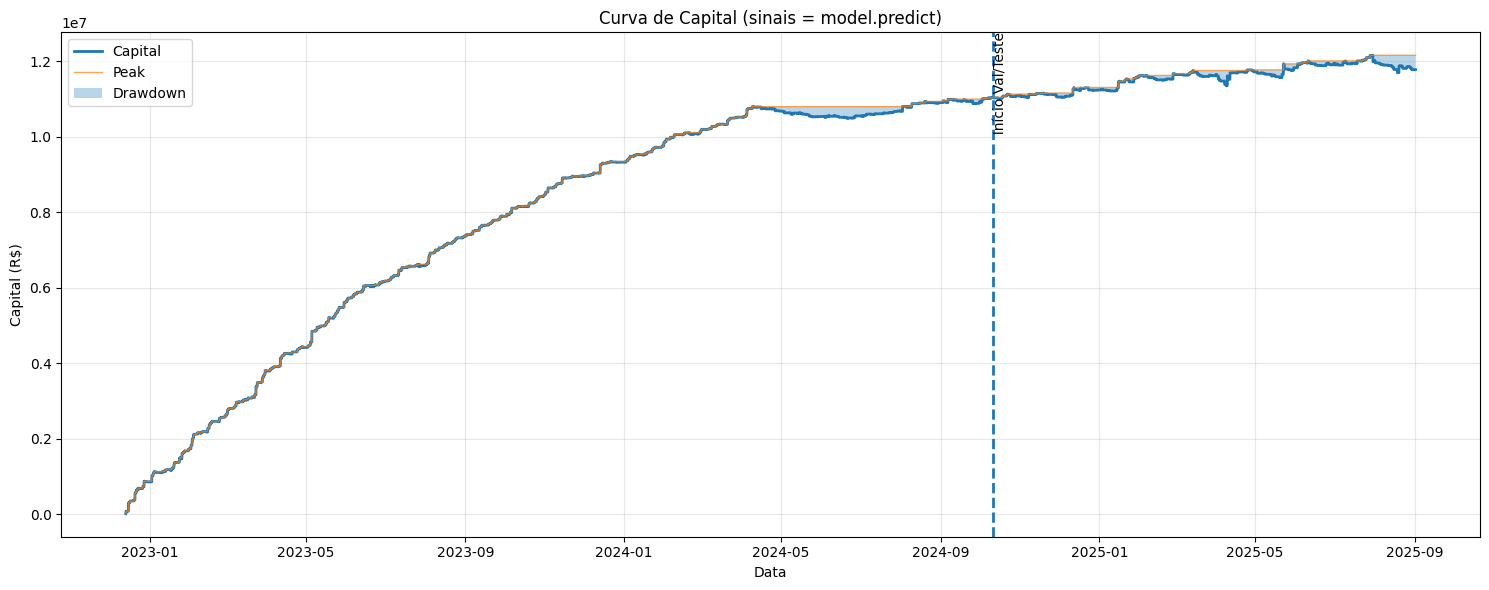

Trades: 9761 | Capital Final: R$ 11,781,166.20 | Retorno Total: 117711.66%
📈 Total de Trades (legs fechadas): 9761
✅ Trades Vencedores: 5611 (57.5%)
❌ Trades Perdedores: 4150
💰 Lucro Total: R$ 11,771,166.20
📊 Retorno Total: 117711.66%
📊 Lucro Médio por Trade: R$ 1,205.94
💚 Lucro Médio (Winners): R$ 3,303.06
💔 Perda Média (Losers): R$ -1,629.47
⚖️  Risk/Reward: 2.03
📈 Sharpe Ratio: 5.523
📉 Máximo Drawdown: R$ -462,320.95 (-3.8%)
🏁 Capital Inicial: R$ 10,000.00
🏁 Capital Final: R$ 11,781,166.20
⛔ Stop Diário (R$): 4,000.00
⛔ Dias com Stop Diário: 32


In [35]:
# =========================================================
# Parâmetros do Backtest
# =========================================================
VALOR_POR_PONTO  = 0.20
STOP_PONTOS      = 1500
SLIPPAGE         = 2
CUSTO_OPERACAO   = 0.0
CAPITAL_INICIAL  = 10000.0
HORA_FECHAMENTO  = dtime(18, 0)
NUM_CONTRATOS    = 25
MAX_PERDA_DIARIA = 4000.0
STOP_ANCHOR      = "entry"        # "entry" ou "signal_open"

# =========================================================
# 0) Carrega o modelo salvo (NÃO TREINA)
# =========================================================
MODEL_PATH = "/content/drive/MyDrive/Colab_Files/lightGBM.joblib"  # ajuste se necessário
model = load(MODEL_PATH)

# =========================================================
# Helpers de alinhamento e OHLC
# =========================================================
def ensure_ohlc(df_like: pd.DataFrame) -> pd.DataFrame:
    """
    Retorna um DF com colunas ['Date','Open','High','Low','Close'].
    Aceita nomes alternativos (PT/EN) e cria 'Date' a partir do índice se for DatetimeIndex.
    """
    tmp = df_like.copy()

    # 1) Garantir coluna Date
    if "Date" not in tmp.columns:
        if isinstance(tmp.index, pd.DatetimeIndex):
            tmp = tmp.reset_index()
            idx_name = tmp.columns[0]
            tmp = tmp.rename(columns={idx_name: "Date"})
        else:
            lower = {c.lower(): c for c in tmp.columns}
            for cand in ["date", "datetime", "timestamp", "data", "time"]:
                if cand in lower:
                    tmp = tmp.rename(columns={lower[cand]: "Date"})
                    break

    # 2) Mapear OHLC (case-insensitive)
    lower = {c.lower(): c for c in tmp.columns}
    def pick(*cands):
        for c in cands:
            if c in lower:
                return lower[c]
        return None

    ren = {}
    if "Open" not in tmp.columns:
        c = pick("open", "abertura", "o")
        if c: ren[c] = "Open"
    if "High" not in tmp.columns:
        c = pick("high", "max", "máxima", "maxima", "h")
        if c: ren[c] = "High"
    if "Low" not in tmp.columns:
        c = pick("low", "min", "mínima", "minima", "l")
        if c: ren[c] = "Low"
    if "Close" not in tmp.columns:
        c = pick("close", "fechamento", "c", "close_price", "price", "ultimo", "último")
        if c: ren[c] = "Close"

    if ren:
        tmp = tmp.rename(columns=ren)

    missing = [c for c in ["Date","Open","High","Low","Close"] if c not in tmp.columns]
    if missing:
        raise KeyError(
            f"Faltam colunas {missing}. Disponíveis: {list(df_like.columns)}. "
            "Se a data está no índice, este patch já faz reset_index automaticamente."
        )

    # 3) Tipos + validação
    tmp["Date"] = pd.to_datetime(tmp["Date"], errors="coerce")
    for c in ["Open","High","Low","Close"]:
        tmp[c] = pd.to_numeric(tmp[c], errors="coerce")
    if tmp[["Date","Open","High","Low","Close"]].isna().any().any():
        raise ValueError("NaNs encontrados em Date/Open/High/Low/Close após padronização.")

    return tmp[["Date","Open","High","Low","Close"]].copy()

def drop_dup_index(obj, keep="last", name="obj"):
    """
    Remove rótulos duplicados do índice (mantendo o último por padrão).
    Funciona para Series e DataFrames.
    """
    idx = obj.index
    if idx.has_duplicates:
        # mensagem opcional para depuração:
        print(f"⚠️ Removendo {idx.duplicated().sum()} duplicatas de índice em {name} (keep='{keep}')")
        return obj[~idx.duplicated(keep=keep)]
    return obj

def _tz_naive(idx: pd.Index) -> pd.Index:
    if isinstance(idx, pd.DatetimeIndex):
        return idx.tz_localize(None) if idx.tz is not None else idx
    return idx

def align_three(X_df: pd.DataFrame, y_s: pd.Series, ohlc_df: pd.DataFrame):
    """
    Alinha X, y e OHLC por:
      - interseção de índices (com normalização de timezone);
      - fallback posicional se não houver interseção mas os comprimentos forem iguais.
    Retorna X_al, y_al, D_al.
    """
    # normaliza timezone
    Xi = _tz_naive(X_df.index)
    yi = _tz_naive(y_s.index)
    Di = _tz_naive(ohlc_df.index)
    if not X_df.index.equals(Xi):   X_df = X_df.copy(); X_df.index = Xi
    if not y_s.index.equals(yi):    y_s  = y_s.copy();  y_s.index  = yi
    if not ohlc_df.index.equals(Di): ohlc_df = ohlc_df.copy(); ohlc_df.index = Di

    # remove duplicatas antes de intersectar
    X_df   = drop_dup_index(X_df, keep="last", name="X")
    y_s    = drop_dup_index(y_s,  keep="last", name="y")
    ohlc_df= drop_dup_index(ohlc_df, keep="last", name="DF_OHLC")

    inter = X_df.index.intersection(y_s.index).intersection(ohlc_df.index)

    # fallback posicional (mesmo tamanho, sem interseção)
    if len(inter) == 0 and (len(X_df) == len(y_s) == len(ohlc_df)):
        ohlc_df = ohlc_df.sort_values("Date").copy()
        X_df = X_df.sort_index()
        y_s = y_s.loc[X_df.index]
        ohlc_df.index = X_df.index
        inter = X_df.index

    if len(inter) == 0:
        raise RuntimeError(
            "Índices de X, y e DF_OHLC não se intersectam e o fallback posicional não pôde ser aplicado.\n"
            f"info: len(X)={len(X_df)}, len(y)={len(y_s)}, len(DF_OHLC)={len(ohlc_df)}\n"
            f"tipos de índice: X={type(X_df.index)}, y={type(y_s.index)}, OHLC={type(ohlc_df.index)}"
        )

    X_al = X_df.loc[inter]
    y_al = y_s.loc[inter]
    D_al = ohlc_df.loc[inter]
    return X_al, y_al, D_al

# =========================================================
# 1) PATCH OHLC a partir do seu 'df' de preços
#    -> se seu DF tem outro nome, troque 'df' por ele abaixo.
# =========================================================
base_prices = df.copy()                     # <<< troque se necessário
DF_OHLC     = ensure_ohlc(base_prices)

# =========================================================
# 2) Harmoniza features de X com o modelo
# =========================================================
feat_in = list(getattr(model, "feature_names_in_", []))
if feat_in:
    feature_cols = [c for c in feat_in if c in X.columns]
    if len(feature_cols) != len(feat_in):
        faltantes = [c for c in feat_in if c not in X.columns]
        print(f"⚠️ Aviso: features ausentes em X foram ignoradas: {faltantes}")
else:
    feature_cols = X.columns.tolist()

X_used = X[feature_cols].copy()
X_used = X_used.fillna(X_used.median(numeric_only=True))  # defesa contra NaN

# =========================================================
# 3) Alinha X, y, DF_OHLC (remove duplicatas e normaliza timezone)
# =========================================================
# Se X é DatetimeIndex, usar Date como índice para o OHLC facilita intersectar
if isinstance(X_used.index, pd.DatetimeIndex):
    DF_OHLC = DF_OHLC.set_index(pd.to_datetime(DF_OHLC["Date"]))

# y como Series (caso seja array)
if not isinstance(y, pd.Series):
    y = pd.Series(y, index=X_used.index)

X_used, y, DF_OHLC = align_three(X_used, y, DF_OHLC)

# =========================================================
# 4) Splits (sem embaralhar)
# =========================================================
X_index = X_used.index
X_train_full, X_test, y_train_full, y_test, idx_train_full, idx_test = train_test_split(
    X_used, y, X_index, test_size=0.20, shuffle=False
)
X_train, X_val, y_train, y_val, idx_train, idx_val = train_test_split(
    X_train_full, y_train_full, idx_train_full, test_size=0.20, shuffle=False
)

# =========================================================
# 5) PREVISÕES (modelo já carregado)
# =========================================================
yhat_train = pd.Series(model.predict(X_train), index=idx_train, name="pred")
yhat_val   = pd.Series(model.predict(X_val),   index=idx_val,   name="pred")
yhat_test  = pd.Series(model.predict(X_test),  index=idx_test,  name="pred")

# Concatena, ordena e REMOVE duplicatas no índice de previsões
yhat_all = pd.concat([yhat_train, yhat_val, yhat_test]).sort_index()
yhat_all = drop_dup_index(yhat_all.astype(int), keep="last", name="yhat_all")

# =========================================================
# 6) Monta DF do backtest com DF_OHLC já alinhado
# =========================================================
df_src_bt = DF_OHLC.loc[yhat_all.index].copy()

df_test = df_src_bt[["Date","Open","High","Low","Close"]].copy()
df_test["Date"] = pd.to_datetime(df_test["Date"])
df_test = df_test.sort_index()

# Garantir índice único em df_test também (por via das dúvidas)
df_test = drop_dup_index(df_test, keep="last", name="df_test")

df_test["date_only"] = df_test["Date"].dt.date
df_test["time_only"] = df_test["Date"].dt.time

# <<< AQUI ESTAVA O ERRO: use .loc com yhat_all já deduplicado >>>
df_test["prediction"] = yhat_all.loc[df_test.index].astype(int)

# Sinal válido no candle corrente = sinal do candle anterior
df_test["sig_prev"]  = df_test["prediction"].shift(1)
df_test["open_prev"] = df_test["Open"].shift(1)
df_test["is_last_candle_day"] = df_test["date_only"] != df_test["date_only"].shift(-1)

# Remove 1ª linha inválida pelo shift, mantendo índice original
df_test = df_test.dropna(subset=["sig_prev", "open_prev"]).copy()

# Marca OOS (val+test) pelos índices dos splits
oos_index = set(idx_val) | set(idx_test)
df_test["is_oos"] = df_test.index.isin(oos_index)
dt_oos_start = df_test.loc[df_test["is_oos"], "Date"].min() if df_test["is_oos"].any() else None

# =========================================================
# 7) Backtest
# =========================================================
capital = CAPITAL_INICIAL
legs = []
historico_trades = []
equity_curve = []
net_pos_vec = []
avg_entry_vec = []
closest_stop_vec = []

_leg_counter = 0
current_day = None
realized_pl_today = 0.0
halted_today = False

def apply_slippage(price, side, slippage_points):
    if slippage_points == 0: return price
    return price + (slippage_points if side == 1 else -slippage_points)

def trade_pl(exit_price, entry_price, side, contracts):
    pontos = (exit_price - entry_price) * side
    return pontos * VALOR_POR_PONTO * contracts

def net_side(legs):
    return 0 if len(legs) == 0 else legs[0]['side']

def avg_entry_price(legs):
    if not legs: return np.nan
    q = sum(l['qty'] for l in legs)
    return sum(l['entry'] * l['qty'] for l in legs) / q if q > 0 else np.nan

def closest_stop(legs):
    if not legs: return np.nan
    s = net_side(legs)
    stops = [l['stop'] for l in legs]
    if s == 1: return max(stops)
    if s == -1: return min(stops)
    return np.nan

def _calc_stop(sig, entry_px, oref):
    if STOP_ANCHOR == "entry":
        return entry_px - STOP_PONTOS if sig == 1 else entry_px + STOP_PONTOS
    elif STOP_ANCHOR == "signal_open":
        return oref - STOP_PONTOS if sig == 1 else oref + STOP_PONTOS
    else:
        raise ValueError("STOP_ANCHOR deve ser 'entry' ou 'signal_open'.")

def close_leg(leg, dt, exit_price, motivo):
    global capital, realized_pl_today, halted_today
    pl = trade_pl(exit_price, leg['entry'], leg['side'], leg['qty']) - CUSTO_OPERACAO
    capital += pl
    realized_pl_today += pl
    historico_trades.append({
        'data_entrada': leg['entry_time'],
        'data_saida': dt,
        'tipo': 'Compra' if leg['side'] == 1 else 'Venda',
        'contratos': leg['qty'],
        'preco_entrada': leg['entry'],
        'preco_saida': exit_price,
        'retorno_pontos': (exit_price - leg['entry']) * leg['side'],
        'pl': pl,
        'motivo_saida': motivo,
        'leg_id': leg['leg_id']
    })
    if realized_pl_today <= -MAX_PERDA_DIARIA:
        halted_today = True

for _, row in df_test.iterrows():
    dt   = row["Date"]
    d    = row["date_only"]
    t    = row["time_only"]
    o    = float(row["Open"])
    h    = float(row["High"])
    l    = float(row["Low"])
    c    = float(row["Close"])

    # Virada de dia reseta o stop diário
    if (current_day is None) or (d != current_day):
        current_day = d
        realized_pl_today = 0.0
        halted_today = False

    sig  = int(row["sig_prev"])    # {-1,0,1}
    oref = float(row["open_prev"]) # abertura do candle do sinal

    # 1) Flatten/Reverse no open
    if legs and (sig == 0 or (sig in (1, -1) and sig != net_side(legs))):
        exit_price_all = apply_slippage(o, -net_side(legs), SLIPPAGE)
        for leg in list(legs):
            close_leg(leg, dt, exit_price_all, "Flatten/Reverse no Open")
        legs.clear()

        if (not halted_today) and (sig in (1, -1)) and (NUM_CONTRATOS > 0):
            _leg_counter += 1
            entry_px = apply_slippage(o, sig, SLIPPAGE)
            stop_px  = _calc_stop(sig, entry_px, oref)
            legs.append({
                'side': sig, 'qty': NUM_CONTRATOS, 'entry': entry_px, 'entry_time': dt,
                'stop': stop_px, 'ref_open': oref, 'leg_id': _leg_counter
            })

    # 2) Abertura/Empilhamento
    elif (not halted_today) and (sig in (1, -1)) and NUM_CONTRATOS > 0:
        if (not legs) or (sig == net_side(legs)):
            _leg_counter += 1
            entry_px = apply_slippage(o, sig, SLIPPAGE)
            stop_px  = _calc_stop(sig, entry_px, oref)
            legs.append({
                'side': sig, 'qty': NUM_CONTRATOS, 'entry': entry_px, 'entry_time': dt,
                'stop': stop_px, 'ref_open': oref, 'leg_id': _leg_counter
            })

    # 3) Stops intrabar
    if legs:
        s = net_side(legs)
        if s == 1:
            triggered = [leg for leg in legs if l <= leg['stop']]
            for leg in list(triggered):
                exit_px = apply_slippage(leg['stop'], -leg['side'], SLIPPAGE)
                close_leg(leg, dt, exit_px, "Stop")
                legs.remove(leg)
        else:
            triggered = [leg for leg in legs if h >= leg['stop']]
            for leg in list(triggered):
                exit_px = apply_slippage(leg['stop'], -leg['side'], SLIPPAGE)
                close_leg(leg, dt, exit_px, "Stop")
                legs.remove(leg)

    # 4) Stop Diário
    if legs and halted_today:
        s = net_side(legs)
        exit_px_stopdia = apply_slippage(c, -s, SLIPPAGE)
        for leg in list(legs):
            close_leg(leg, dt, exit_px_stopdia, "Stop Diário (flatten)")
            legs.remove(leg)

    # 5) Fechamento obrigatório do dia
    if legs and (t >= HORA_FECHAMENTO or row["is_last_candle_day"]):
        s = net_side(legs)
        exit_px_day = apply_slippage(c, -s, SLIPPAGE)
        for leg in list(legs):
            close_leg(leg, dt, exit_px_day, "Fechamento Daytrade")
            legs.remove(leg)

    # Séries
    equity_curve.append(capital)
    net_pos_vec.append(net_side(legs))
    avg_entry_vec.append(avg_entry_price(legs))
    closest_stop_vec.append(closest_stop(legs))

# Fecha o que sobrou no fim
if legs:
    last_close = float(df_test.iloc[-1]["Close"])
    last_dt    = df_test.iloc[-1]["Date"]
    s = net_side(legs)
    exit_px_final = apply_slippage(last_close, -s, SLIPPAGE)
    for leg in list(legs):
        close_leg(leg, last_dt, exit_px_final, "Fechamento Série")
        legs.remove(leg)

# =========================================================
# 8) Resultados + Curva de Capital com linha vertical OOS
# =========================================================
df_test["capital"] = equity_curve
df_test["posicao"] = net_pos_vec
df_test["preco_entrada_media"] = avg_entry_vec
df_test["stop_mais_proximo"] = closest_stop_vec

df_test["peak"] = df_test["capital"].cummax()
df_test["drawdown"] = df_test["capital"] - df_test["peak"]

plt.figure(figsize=(15, 6))
ax = plt.gca()
ax.plot(df_test["Date"], df_test["capital"], label="Capital", linewidth=2)
ax.plot(df_test["Date"], df_test["peak"], label="Peak", linewidth=1, alpha=0.7)
ax.fill_between(df_test["Date"], df_test["peak"], df_test["capital"],
                where=(df_test["capital"] < df_test["peak"]),
                alpha=0.3, label='Drawdown')
if dt_oos_start is not None:
    ax.axvline(pd.to_datetime(dt_oos_start), linestyle="--", linewidth=2)
    ax.text(pd.to_datetime(dt_oos_start), ax.get_ylim()[1],
            "  Início Val/Teste", rotation=90, va='top', ha='left')
ax.set_title("Curva de Capital (sinais = model.predict)")
ax.set_xlabel("Data"); ax.set_ylabel("Capital (R$)")
ax.grid(True, alpha=0.3); ax.legend()
plt.tight_layout()
plt.show()

# Sumário simples
total_trades = len(pd.DataFrame(historico_trades))
capital_final = df_test["capital"].iloc[-1]
retorno_total = ((capital_final - CAPITAL_INICIAL) / CAPITAL_INICIAL) * 100.0
print(f"Trades: {total_trades} | Capital Final: R$ {capital_final:,.2f} | Retorno Total: {retorno_total:.2f}%")

# (Opcional) DF de sinais para inspecionar/guardar
df_signals = df_test[["Date","prediction","sig_prev","Open","High","Low","Close"]].copy()

# =========================================================
# 9) Métricas detalhadas + prints "executivo"
# =========================================================
df_historico = pd.DataFrame(historico_trades)

if not df_historico.empty:
    total_trades = int(len(df_historico))
    trades_vencedores = int((df_historico['pl'] > 0).sum())
    trades_perdedores = int((df_historico['pl'] <= 0).sum())
    win_rate = (trades_vencedores / total_trades * 100.0) if total_trades > 0 else 0.0

    total_pl = float(df_historico['pl'].sum())
    mean_pl  = float(df_historico['pl'].mean())
    std_pl   = float(df_historico['pl'].std(ddof=1)) if total_trades > 1 else 0.0

    lucro_medio = float(df_historico.loc[df_historico['pl'] > 0, 'pl'].mean()) if trades_vencedores > 0 else 0.0
    perda_media = float(df_historico.loc[df_historico['pl'] <= 0, 'pl'].mean()) if trades_perdedores > 0 else 0.0
    risk_reward = (abs(lucro_medio / perda_media) if perda_media < 0 else np.nan)

    sharpe = (mean_pl / std_pl * np.sqrt(252)) if (std_pl and std_pl > 0) else np.nan

    # drawdown já foi calculado acima; se quiser garantir:
    if "peak" not in df_test.columns:
        df_test["peak"] = df_test["capital"].cummax()
    if "drawdown" not in df_test.columns:
        df_test["drawdown"] = df_test["capital"] - df_test["peak"]

    max_dd = float(df_test["drawdown"].min())
    peak_max = float(df_test["peak"].max()) if len(df_test) else np.nan
    max_dd_pct = (max_dd / peak_max * 100.0) if peak_max and not np.isnan(peak_max) else np.nan

    capital_inicial = float(CAPITAL_INICIAL)
    capital_final   = float(df_test["capital"].iloc[-1]) if len(df_test) else capital_inicial
    retorno_total   = ((capital_final - capital_inicial) / capital_inicial) * 100.0 if capital_inicial else np.nan

    # Dias com Stop Diário (usa 'motivo_saida' do histórico)
    mask_stop = df_historico['motivo_saida'].astype(str).str.contains('Stop Diário', na=False)
    dias_stop_diario = pd.to_datetime(df_historico.loc[mask_stop, 'data_saida']).dt.date.nunique()

    # ======= PRINTS REQUERIDOS =======
    print(f"📈 Total de Trades (legs fechadas): {total_trades}")
    print(f"✅ Trades Vencedores: {trades_vencedores} ({win_rate:.1f}%)")
    print(f"❌ Trades Perdedores: {trades_perdedores}")
    print(f"💰 Lucro Total: R$ {total_pl:,.2f}")
    print(f"📊 Retorno Total: {retorno_total:.2f}%")
    print(f"📊 Lucro Médio por Trade: R$ {mean_pl:,.2f}")
    print(f"💚 Lucro Médio (Winners): R$ {lucro_medio:,.2f}")
    print(f"💔 Perda Média (Losers): R$ {perda_media:,.2f}")
    print(f"⚖️  Risk/Reward: {risk_reward:.2f}")
    print(f"📈 Sharpe Ratio: {sharpe:.3f}")
    print(f"📉 Máximo Drawdown: R$ {max_dd:,.2f} ({max_dd_pct:.1f}%)")
    print(f"🏁 Capital Inicial: R$ {capital_inicial:,.2f}")
    print(f"🏁 Capital Final: R$ {capital_final:,.2f}")
    print(f"⛔ Stop Diário (R$): {MAX_PERDA_DIARIA:,.2f}")
    print(f"⛔ Dias com Stop Diário: {dias_stop_diario}")

else:
    # Sem trades: ainda assim imprimimos um resumo consistente
    capital_inicial = float(CAPITAL_INICIAL)
    capital_final   = float(df_test["capital"].iloc[-1]) if len(df_test) else capital_inicial
    retorno_total   = ((capital_final - capital_inicial) / capital_inicial) * 100.0 if capital_inicial else np.nan

    # drawdown/peak (se não existirem)
    if "peak" not in df_test.columns:
        df_test["peak"] = df_test["capital"].cummax()
    if "drawdown" not in df_test.columns:
        df_test["drawdown"] = df_test["capital"] - df_test["peak"]

    max_dd = float(df_test["drawdown"].min())
    peak_max = float(df_test["peak"].max()) if len(df_test) else np.nan
    max_dd_pct = (max_dd / peak_max * 100.0) if peak_max and not np.isnan(peak_max) else np.nan

    print("⚠️ Nenhum trade foi executado no período de backtest.")
    print(f"🏁 Capital Inicial: R$ {capital_inicial:,.2f}")
    print(f"🏁 Capital Final: R$ {capital_final:,.2f}")
    print(f"📊 Retorno Total: {retorno_total:.2f}%")
    print(f"📉 Máximo Drawdown: R$ {max_dd:,.2f} ({max_dd_pct:.1f}%)")

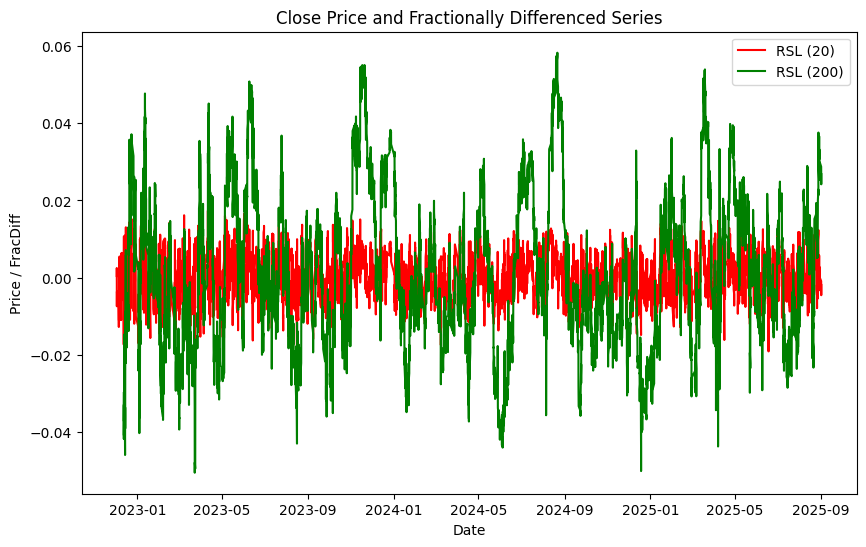

In [ ]:
# Plotar gráfico de fracdiff_renko_5
plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['RSL20'], label='RSL (20)', color='red')
plt.plot(df['Date'], df['RSL200'], label='RSL (200)', color='green')
plt.xlabel('Date')
plt.ylabel('Price / FracDiff')
plt.title('Close Price and Fractionally Differenced Series')
plt.legend()
plt.show()

In [ ]:

# === Carga dos dados ===

# Exemplo:
# df = pd.read_csv('dados.csv')

# Placeholder para não quebrar o template:
df = pd.DataFrame({
    "feature_num_1": np.random.normal(size=500),
    "feature_num_2": np.random.uniform(0, 10, size=500),
    "feature_cat_1": np.random.choice(["A","B","C"], size=500),
    "target_reg": np.random.normal(loc=50, scale=10, size=500),
    "target_clf": np.random.choice([0,1], size=500, p=[0.6,0.4]),
    "timestamp": pd.date_range('2024-01-01', periods=500, freq='D')
})
df.head()


,feature_num_1,feature_num_2,feature_cat_1,target_reg,target_clf,timestamp
0,0.496714,6.459172,B,46.969684,1,2024-01-01
1,-0.138264,5.707783,A,49.652967,1,2024-01-02
2,0.647689,3.560967,C,38.115133,0,2024-01-03
3,1.523030,9.865152,C,53.120794,1,2024-01-04
4,-0.234153,6.057748,C,62.691772,1,2024-01-05


In [ ]:

# === Verificações iniciais ===
display(df.sample(5))
print("\nFormato:", df.shape)
print("\nTipos:")
print(df.dtypes)
print("\nValores ausentes por coluna:")
print(df.isna().sum())


,feature_num_1,feature_num_2,feature_cat_1,target_reg,target_clf,timestamp
334,0.975120,2.721451,A,66.389408,0,2024-11-30
485,-1.422254,5.657320,C,42.705453,1,2025-04-30
444,-1.304470,8.837859,C,64.385425,1,2025-03-20
196,-0.883857,2.051396,B,44.071721,1,2024-07-15
242,0.504987,2.078863,C,25.682864,1,2024-08-30



Formato: (500, 6)

Tipos:
feature_num_1           float64
feature_num_2           float64
feature_cat_1            object
target_reg              float64
target_clf                int64
timestamp        datetime64[ns]
dtype: object

Valores ausentes por coluna:
feature_num_1    0
feature_num_2    0
feature_cat_1    0
target_reg       0
target_clf       0
timestamp        0
dtype: int64



### 3.1 Análise exploratória resumida (EDA)
**TODO:** inclua gráficos e tabelas essenciais para entender o problema e levantar hipóteses.  
Evite EDA muito extensa — foque no que afeta as decisões de modelagem.


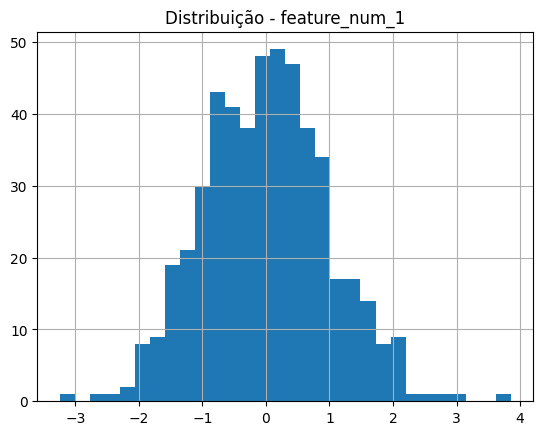

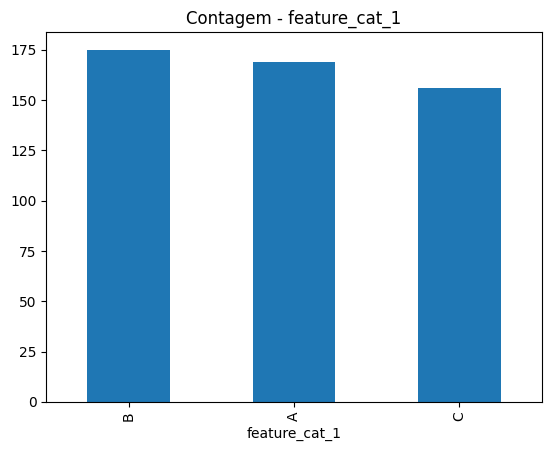

In [ ]:
# Histograma numérico (exemplo)
_ = df["feature_num_1"].hist(bins=30)
plt.title("Distribuição - feature_num_1")
plt.show()

# Contagem categórica (exemplo)
_ = df["feature_cat_1"].value_counts().plot(kind="bar")
plt.title("Contagem - feature_cat_1")
plt.show()



## 4. Definição do target, variáveis e divisão dos dados
**TODO:** escolha o **target** (ou defina a tarefa de clusterização/forecast).  
- Em **séries temporais**, **não embaralhe** e use divisões temporais (ex.: `TimeSeriesSplit`).
- Em **classificação desequilibrada**, considere **estratégias para desbalanceamento** (ex.: `class_weight`, undersampling/oversampling).

> **Atenção:** Todas as **transformações** aprendidas devem ser **ajustadas no treino** e **aplicadas no validação/teste**. Recomendamos usar **pipelines**.


In [ ]:
# Selecione o tipo de problema: 'classificacao' | 'regressao' | 'clusterizacao' | 'serie_temporal'
PROBLEM_TYPE = "classificacao"  # TODO: ajuste

# Defina features e target conforme o problema
if PROBLEM_TYPE == "classificacao":
    target = "target_clf"
    features = [c for c in df.columns if c not in [target, "timestamp"]]
elif PROBLEM_TYPE == "regressao":
    target = "target_reg"
    features = [c for c in df.columns if c not in [target, "timestamp"]]
elif PROBLEM_TYPE == "clusterizacao":
    target = None
    features = [c for c in df.columns if c not in ["target_clf","target_reg","timestamp"]]
elif PROBLEM_TYPE == "serie_temporal":
    target = "target_reg"  # Exemplo
    features = [c for c in df.columns if c not in [target]]
else:
    raise ValueError("PROBLEM_TYPE inválido.")

print("PROBLEM_TYPE:", PROBLEM_TYPE)
print("Target:", target)
print("N features:", len(features))

# Divisão dos dados
if PROBLEM_TYPE in ["classificacao", "regressao"]:
    X = df[features].copy()
    y = df[target].copy()
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=SEED, stratify=y if PROBLEM_TYPE=="classificacao" else None
    )
    print("Treino:", X_train.shape, "| Teste:", X_test.shape)
elif PROBLEM_TYPE == "clusterizacao":
    X = df[features].copy()
    # Sem target — você pode reservar um hold-out para avaliação externa se fizer sentido de negócio.
    X_train, X_test = train_test_split(X, test_size=0.2, random_state=SEED)
    print("Treino:", X_train.shape, "| Teste:", X_test.shape)
elif PROBLEM_TYPE == "serie_temporal":
    # Ordenar por tempo e criar cortes temporais (exemplo simples hold-out temporal)
    df_sorted = df.sort_values("timestamp")
    cutoff = int(len(df_sorted)*0.8)
    train, test = df_sorted.iloc[:cutoff], df_sorted.iloc[cutoff:]
    X_train, y_train = train.drop(columns=[target]), train[target]
    X_test, y_test   = test.drop(columns=[target]),  test[target]
    print("Treino:", X_train.shape, "| Teste:", X_test.shape)

PROBLEM_TYPE: classificacao
Target: target_clf
N features: 4
Treino: (400, 4) | Teste: (100, 4)



## 5. Tratamento de dados e **Pipeline** de pré-processamento
Crie um **Pipeline** com as etapas necessárias (limpeza, imputação, encoding, escala, seleção de atributos, etc.)  
Isso garante **reprodutibilidade** e evita **vazamento**.


In [ ]:
num_cols = [c for c in X_train.columns if str(X_train[c].dtype).startswith(("float","int"))]
cat_cols = [c for c in X_train.columns if c not in num_cols and c != "timestamp"]

numeric_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(transformers=[
    ("num", numeric_pipe, num_cols),
    ("cat", categorical_pipe, cat_cols)
])

print("num_cols:", num_cols[:5], "...")
print("cat_cols:", cat_cols[:5], "...")

num_cols: ['feature_num_1', 'feature_num_2', 'target_reg'] ...
cat_cols: ['feature_cat_1'] ...



## 6. Baseline e modelos candidatos
Se possivek, comece com uma **baseline simples** (ex.: DummyClassifier/Regressor) e evolua para modelos mais fortes. O baseline pode ser seu primeiro modelo!  

**Compare** ao menos **duas abordagens**.

> Para **deep learning** (visão computacional/NLP/séries), crie uma seção específica (p. ex., `TensorFlow`/`PyTorch`) e documente arquitetura, parâmetros e tempo de treino.


In [ ]:
# === Baselines ===
if PROBLEM_TYPE == "classificacao":
    baseline = Pipeline(steps=[("pre", preprocess),
                               ("model", DummyClassifier(strategy="most_frequent", random_state=SEED))])
    candidates = {
        "LogisticRegression": Pipeline([("pre", preprocess), ("model", LogisticRegression(max_iter=200, random_state=SEED))]),
        "RandomForest": Pipeline([("pre", preprocess), ("model", RandomForestClassifier(random_state=SEED))])
    }
elif PROBLEM_TYPE == "regressao":
    baseline = Pipeline(steps=[("pre", preprocess),
                               ("model", DummyRegressor(strategy="median"))])
    candidates = {
        "Ridge": Pipeline([("pre", preprocess), ("model", Ridge(random_state=SEED))]),
        "RandomForestReg": Pipeline([("pre", preprocess), ("model", RandomForestRegressor(random_state=SEED))])
    }
elif PROBLEM_TYPE == "clusterizacao":
    # baseline não se aplica diretamente; use um método simples (ex.: KMeans com k fixo) como referência.
    baseline = Pipeline(steps=[("pre", preprocess),
                               ("model", KMeans(n_clusters=3, random_state=SEED))])
    candidates = {
        "KMeans_k3": Pipeline([("pre", preprocess), ("model", KMeans(n_clusters=3, random_state=SEED))]),
        "KMeans_k5": Pipeline([("pre", preprocess), ("model", KMeans(n_clusters=5, random_state=SEED))])
    }
elif PROBLEM_TYPE == "serie_temporal":
    # Em séries temporais, a baseline pode ser "naive" (último valor) — aqui, apenas um placeholder.
    # Para modelos clássicos, pode considerar por exemplo Regressores com janelas (feature engineering temporal).
    baseline = None
    candidates = {}
else:
    raise ValueError("PROBLEM_TYPE inválido.")

baseline


Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['feature_num_1',
                                                   'feature_num_2',
                                                   'target_reg']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['feature_cat_1'])])),
                ('model',
                 DummyClassifier(random_state=42, strategy='most_frequent'))])


### 6.1 Treino e avaliação rápida (baseline vs candidatos)
Use **métricas adequadas** ao tipo de problema. Documente suas observações.


In [ ]:
results = {}

if PROBLEM_TYPE in ["classificacao", "regressao"]:
    # Baseline
    t0 = time.time()
    baseline.fit(X_train, y_train)
    t1 = time.time()
    if PROBLEM_TYPE == "classificacao":
        y_pred = baseline.predict(X_test)
        proba = baseline.predict_proba(X_test) if hasattr(baseline, "predict_proba") else None
        results["baseline"] = evaluate_classification(y_test, y_pred, proba)
    else:
        y_pred = baseline.predict(X_test)
        results["baseline"] = evaluate_regression(y_test, y_pred)
    results["baseline"]["train_time_s"] = round(t1 - t0, 3)

    # Candidatos
    for name, pipe in candidates.items():
        t0 = time.time()
        pipe.fit(X_train, y_train)
        t1 = time.time()
        if PROBLEM_TYPE == "classificacao":
            y_pred = pipe.predict(X_test)
            proba = pipe.predict_proba(X_test) if hasattr(pipe, "predict_proba") else None
            results[name] = evaluate_classification(y_test, y_pred, proba)
        else:
            y_pred = pipe.predict(X_test)
            results[name] = evaluate_regression(y_test, y_pred)
        results[name]["train_time_s"] = round(t1 - t0, 3)

elif PROBLEM_TYPE == "clusterizacao":
    # Baseline e candidatos (ex.: silhouette)
    # Observação: em um projeto real, evite refit em dados de teste fora de validação apropriada.
    results["baseline"] = evaluate_clustering(X_test, baseline)
    for name, pipe in candidates.items():
        results[name] = evaluate_clustering(X_test, pipe)

elif PROBLEM_TYPE == "serie_temporal":
    # TODO: implemente métricas específicas (ex.: MAE/MAPE/RMSE out-of-time)
    results["baseline_naive"] = {"MAE": None, "MAPE": None, "RMSE": None, "obs": "Implementar baseline temporal."}

pd.DataFrame(results).T


,accuracy,f1_weighted,roc_auc,train_time_s
baseline,0.60,0.450000,0.500000,0.093
LogisticRegression,0.57,0.465415,0.550000,0.095
RandomForest,0.57,0.549299,0.543333,0.728



## 7. Validação e Otimização de Hiperparâmetros
Use **validação cruzada** apropriada ao problema (Ex: **`StratifiedKFold`** para classificação; **`KFold`** para regressão).  
Faça **tuning** com `GridSearchCV`/`RandomizedSearchCV`.


In [ ]:
if PROBLEM_TYPE == "classificacao":
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    model = Pipeline([("pre", preprocess), ("model", RandomForestClassifier(random_state=SEED))])
    param_dist = {
        "model__n_estimators": randint(100, 400),
        "model__max_depth": randint(3, 20),
        "model__min_samples_split": randint(2, 10)
    }
    scorer = "f1_weighted"

elif PROBLEM_TYPE == "regressao":
    cv = KFold(n_splits=5, shuffle=True, random_state=SEED)
    model = Pipeline([("pre", preprocess), ("model", RandomForestRegressor(random_state=SEED))])
    param_dist = {
        "model__n_estimators": randint(100, 400),
        "model__max_depth": randint(3, 20),
        "model__min_samples_split": randint(2, 10)
    }
    scorer = "neg_root_mean_squared_error"

elif PROBLEM_TYPE == "clusterizacao":
    # Clusterização: tuning diferente (ex.: número de clusters). Métricas internas (silhouette) ou externas (se houver rótulos).
    cv = None
    model = Pipeline([("pre", preprocess), ("model", KMeans(random_state=SEED))])
    param_dist = {"model__n_clusters": randint(2, 10)}
    scorer = None

elif PROBLEM_TYPE == "serie_temporal":
    cv = TimeSeriesSplit(n_splits=5)
    # Ex.: usar um regressor com janelas/defasagens previamente criadas
    model = Pipeline([("pre", preprocess), ("model", RandomForestRegressor(random_state=SEED))])
    param_dist = {
        "model__n_estimators": randint(100, 300),
        "model__max_depth": randint(3, 15)
    }
    scorer = "neg_mean_absolute_error"

# Executar busca aleatória (exemplo geral — ajuste para seu caso)
if PROBLEM_TYPE != "clusterizacao":
    search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=10, cv=cv, scoring=scorer, random_state=SEED, n_jobs=-1, verbose=1)
    search.fit(X_train, y_train)
    print("Melhor score (CV):", search.best_score_)
    print("Melhores parâmetros:", search.best_params_)
else:
    print("Para clusterização, avalie k em um range e compare silhouette/indíces de validade. Ex.: varra k de 2 a 10.")


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Melhor score (CV): 0.5402276617001536
Melhores parâmetros: {'model__max_depth': 14, 'model__min_samples_split': 2, 'model__n_estimators': 148}



## 8. Avaliação final, análise de erros e limitações
- **Compare** baseline vs melhor modelo.  
- Faça **análise de erros** (ex.: matriz de confusão, casos pior previstos, resíduos).  
- Discuta **limitações**: dados, métricas, viés, generalização.


              precision    recall  f1-score   support

           0       0.60      0.72      0.65        60
           1       0.39      0.28      0.32        40

    accuracy                           0.54       100
   macro avg       0.50      0.50      0.49       100
weighted avg       0.52      0.54      0.52       100



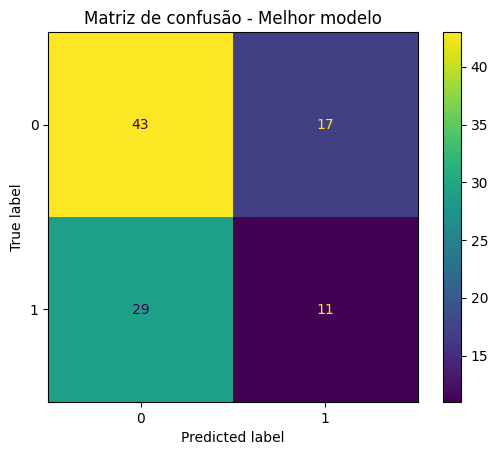

In [ ]:
# Exemplo de re-treino no conjunto de treino+validação (se aplicável) e avaliação no teste

if PROBLEM_TYPE in ["classificacao", "regressao"] and 'search' in globals() and hasattr(search, "best_estimator_"):
    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test)
    if PROBLEM_TYPE == "classificacao":
        from sklearn.metrics import classification_report, ConfusionMatrixDisplay
        print(classification_report(y_test, y_pred))
        try:
            ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test)
            plt.title("Matriz de confusão - Melhor modelo")
            plt.show()
        except Exception as e:
            print("Não foi possível plotar a matriz de confusão:", e)
    else:
        print('Metricas para avaliar a regressão: ', evaluate_regression(y_test, y_pred))
elif PROBLEM_TYPE == "clusterizacao":
    print("Realize análise qualitativa/negócio dos clusters. Visualize centros e perfis.")
elif PROBLEM_TYPE == "serie_temporal":
    print("Avalie métricas fora do tempo; plote série real vs prevista.")


## 9. Engenharia de atributos (detalhe)
**TODO:** Documente as escolhas: seleção/extração, encoding, criação de variáveis temporais (lags, médias móveis), TF-IDF/embeddings (NLP), augmentations (visão), etc.



## 10. (Opcional) Deep Learning / Fine-tuning
Se usar DL, descreva: arquitetura, hiperparâmetros, _early stopping_, tamanho do batch, épocas, e se houve **fine-tuning** de modelos pré-treinados.



## 11. Boas práticas e rastreabilidade
- **Baseline** claro e justificativas para melhorias.  
- **Pipelines** (evitar vazamento).  
- **Decisões de projeto** documentadas (o que tentou e por quê).



## 12. Conclusões e próximos passos
**TODO:** Resuma resultados, trade-offs, e proponha melhorias futuras (mais dados, features, modelos, tuning).



## 13. Salvando artefatos (modelos e pipeline)
Se o treinamento dos modelos demora mais de 3 minutos, recomendamos salvar o **modelo/pipeline** após o treinamento e depois apenas carregar o arquivo (ex: .pkl, .h5) salvo em outra célula, sem precisar treinar novamente.  